In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from lightgbm import LGBMClassifier
plt.rcParams['font.sans-serif'] = ['SimHei', 'cm10']
plt.rcParams['axes.unicode_minus'] = False
sns.set()
%config InlineBackend.figure_format = 'retina'

## 导入数据

In [612]:
base_dtype = {'ID':np.int,'注册时间':np.float64,'注册资本':np.float64,'行业':object,'区域':object,'企业类型':object,'控制人类型':object,'控制人持股比例':np.float64,'flag':"Int64"}
base_df = pd.read_csv("../data/base_train_sum.csv", dtype=base_dtype)
base_df.set_index('ID', inplace=True)
flag = base_df.flag
base_df.drop(columns="flag", inplace=True)
base_df

,注册时间,注册资本,行业,区域,企业类型,控制人类型,控制人持股比例
ID,,,,,,,
28,2007.0,2050.0,交通运输业,福建,农民专业合作社,企业法人,NaN
230,2008.0,3360.0,服务业,广东,农民专业合作社,企业法人,1.00
429,2005.0,9670.0,工业,江西,集体所有制企业,自然人,0.75
693,2011.0,8360.0,社区服务,山东,股份有限公司,企业法人,0.98
727,2001.0,8720.0,零售业,江西,股份有限公司,企业法人,0.54
...,...,...,...,...,...,...,...
5978029,2014.0,460.0,交通运输业,广西,农民专业合作社,企业法人,0.71
5978030,2004.0,1140.0,商业服务业,湖南,有限责任公司,自然人,0.95
5978031,2008.0,3290.0,交通运输业,湖南,集体所有制企业,自然人,0.63


In [432]:
knowledge_dtype = np.float64
knowledge_df = pd.read_csv("../data/knowledge_train_sum.csv", dtype=knowledge_dtype)
knowledge_df.set_index('ID', inplace=True)
knowledge_df

,专利,商标,著作权
ID,,,
28.0,0.0,1.0,1.0
230.0,0.0,0.0,0.0
429.0,1.0,0.0,0.0
693.0,0.0,0.0,0.0
727.0,0.0,0.0,0.0
...,...,...,...
5978029.0,1.0,1.0,1.0
5978030.0,0.0,0.0,0.0
5978031.0,0.0,1.0,1.0


In [72]:
money_dtype = {'ID':np.int,'year':np.float64,'债权融资额度':np.float64,'债权融资成本':np.float64,'股权融资额度':np.float64,'股权融资成本':np.float64,'内部融资和贸易融资额度':np.float64,'内部融资和贸易融资成本':np.float64,'项目融资和政策融资额度':np.float64,'项目融资和政策融资成本':np.float64}
money_df = pd.read_csv("../data/money_report_train_sum.csv", dtype=money_dtype)
money_df.set_index('ID', inplace=True)
money_df

,year,债权融资额度,债权融资成本,股权融资额度,股权融资成本,内部融资和贸易融资额度,内部融资和贸易融资成本,项目融资和政策融资额度,项目融资和政策融资成本
ID,,,,,,,,,
28,2015.0,0.0,0.0,0.00,0.0000,21648.0,1298.880,0.0,0.000
230,2015.0,0.0,0.0,0.00,0.0000,0.0,0.000,470.4,28.224
429,2015.0,19340.0,1547.2,0.00,0.0000,0.0,0.000,0.0,0.000
693,2015.0,0.0,0.0,0.00,0.0000,0.0,0.000,5350.4,321.024
727,2015.0,0.0,0.0,32229.12,1289.1648,0.0,0.000,0.0,0.000
...,...,...,...,...,...,...,...,...,...
5978029,2017.0,0.0,0.0,0.00,0.0000,1117.8,67.068,0.0,0.000
5978030,2017.0,0.0,0.0,0.00,0.0000,0.0,0.000,2371.2,142.272
5978031,2017.0,0.0,0.0,0.00,0.0000,0.0,0.000,2664.9,159.894


In [74]:
year_dtype = {'ID':np.int,'year':np.float64,'从业人数':np.float64,'资产总额':np.float64,'负债总额':np.float64,'营业总收入':np.float64,'主营业务收入':np.float64,'利润总额':np.float64,'净利润':np.float64,'纳税总额':np.float64,'所有者权益合计':np.float64}
year_df = pd.read_csv("../data/year_report_train_sum.csv", dtype=year_dtype)
year_df.set_index('ID', inplace=True)
year_df

,year,从业人数,资产总额,负债总额,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计
ID,,,,,,,,,,
28,2015.0,794.0,16400.0,28700.0,72160.0,28864.0,7216.0,-7216.0,0.0,-12300.0
230,2015.0,485.0,23520.0,10080.0,115248.0,57624.0,57624.0,-11524.8,0.0,13440.0
429,2015.0,136.0,193400.0,183730.0,502840.0,351988.0,NaN,-50284.0,0.0,9670.0
693,2015.0,534.0,133760.0,125400.0,655424.0,262169.6,196627.2,-65542.4,0.0,8360.0
727,2015.0,375.0,366240.0,536280.0,402864.0,282004.8,161145.6,-40286.4,0.0,-170040.0
...,...,...,...,...,...,...,...,...,...,...
5978029,2017.0,265.0,1380.0,1840.0,3726.0,1863.0,745.2,372.6,2235.6,-460.0
5978030,2017.0,1000.0,59280.0,58140.0,260832.0,208665.6,78249.6,-26083.2,0.0,1140.0
5978031,2017.0,357.0,88830.0,171080.0,106596.0,42638.4,10659.6,-10659.6,0.0,-82250.0


## 预处理

In [75]:
base_pre = pd.get_dummies(base_df, columns=["行业", "区域", "企业类型", "控制人类型"])
base_pre

,注册时间,注册资本,控制人持股比例,行业_交通运输业,行业_商业服务业,行业_工业,行业_服务业,行业_社区服务,行业_零售业,区域_山东,...,区域_湖北,区域_湖南,区域_福建,企业类型_农民专业合作社,企业类型_合伙企业,企业类型_有限责任公司,企业类型_股份有限公司,企业类型_集体所有制企业,控制人类型_企业法人,控制人类型_自然人
ID,,,,,,,,,,,,,,,,,,,,,
28,2007.0,2050.0,NaN,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
230,2008.0,3360.0,1.00,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
429,2005.0,9670.0,0.75,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
693,2011.0,8360.0,0.98,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0
727,2001.0,8720.0,0.54,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,2014.0,460.0,0.71,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
5978030,2004.0,1140.0,0.95,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
5978031,2008.0,3290.0,0.63,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


In [433]:
knowledge_pre = knowledge_df.copy()
knowledge_pre["创新能力"] = knowledge_pre.sum(axis=1)

In [77]:
money_pre = money_df.drop(columns=["year", "债权融资额度", "股权融资额度", "内部融资和贸易融资额度", "项目融资和政策融资额度"])
money_pre = money_pre.groupby("ID").mean()
money_pre["融资成本总和"] = money_pre.sum(axis=1)
money_pre

In [78]:
money_pre = money_pre.groupby("ID").mean()

In [79]:
money_pre["融资成本总和"] = money_pre.sum(axis=1)

In [80]:
money_pre

,债权融资成本,股权融资成本,内部融资和贸易融资成本,项目融资和政策融资成本,融资成本总和
ID,,,,,
28,0.000000,508.400000,432.960,0.000,941.360000
230,0.000000,40.320000,935.424,9.408,985.152000
429,515.733333,1412.851467,0.000,0.000,1928.584800
693,0.000000,428.032000,1103.520,107.008,1638.560000
727,0.000000,1769.113600,2903.760,0.000,4672.873600
...,...,...,...,...,...
5978029,0.000000,0.000000,72.036,1.380,73.416000
5978030,0.000000,0.000000,237.006,69.312,306.318000
5978031,0.000000,342.335467,0.000,53.298,395.633467


In [81]:
year_pre = year_df.drop(columns="year").groupby("ID").mean()

In [82]:
f1 = lambda row: row["净利润"] / row["营业总收入"] if row["营业总收入"] else None
f2 = lambda row: row["净利润"] / row["资产总额"] if row["资产总额"] else None
f3 = lambda row: row["负债总额"] / row["资产总额"] if row["资产总额"] else None
f4 = lambda row: row["净利润"] / row["所有者权益合计"] if row["所有者权益合计"] else None
year_pre["销售净利率"] = year_pre.apply(f1, axis=1)
year_pre["资产净利率"] = year_pre.apply(f2, axis=1)
year_pre["资产负债率"] = year_pre.apply(f3, axis=1)
year_pre["资金收益率"] = year_pre.apply(f4, axis=1)

In [83]:
year_pre

,从业人数,资产总额,负债总额,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计,销售净利率,资产净利率,资产负债率,资金收益率
ID,,,,,,,,,,,,,
28,527.666667,57400.000000,86783.333333,1.970733e+05,101871.333333,65955.333333,-19707.333333,0.000000,-29383.333333,-0.100000,-0.343333,1.511905,0.670698
230,480.666667,76160.000000,94080.000000,1.004640e+05,65822.400000,39838.400000,-10046.400000,0.000000,-17920.000000,-0.100000,-0.131912,1.235294,0.560625
429,448.666667,357790.000000,435150.000000,1.051774e+06,603279.066667,264909.650000,-105177.366667,0.000000,-77360.000000,-0.100000,-0.293964,1.216216,1.359583
693,553.333333,91960.000000,79420.000000,3.867893e+05,160846.400000,131307.733333,-38678.933333,0.000000,12540.000000,-0.100000,-0.420606,0.863636,-3.084444
727,610.333333,398213.333333,584240.000000,1.132728e+06,509509.600000,237271.200000,-113272.800000,0.000000,-186026.666667,-0.100000,-0.284453,1.467153,0.608906
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,635.000000,1840.000000,2453.333333,6.608667e+03,3289.000000,1582.400000,2010.200000,1818.533333,-613.333333,0.304176,1.092500,1.333333,-3.277500
5978030,914.000000,33060.000000,36290.000000,1.039300e+05,82266.200000,30358.200000,-4533.400000,3397.200000,-3230.000000,-0.043620,-0.137126,1.097701,1.403529
5978031,571.000000,103086.666667,148598.333333,2.226233e+05,110544.000000,46345.133333,23117.733333,58912.933333,-45511.666667,0.103842,0.224255,1.441489,-0.507952


基础特征表

In [89]:
union_feature = pd.concat([base_pre, knowledge_pre, money_pre, year_pre], axis=1, join_axes=[base_pre.index])

/Users/sameal/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  """Entry point for launching an IPython kernel.


In [90]:
union_feature

,注册时间,注册资本,控制人持股比例,行业_交通运输业,行业_商业服务业,行业_工业,行业_服务业,行业_社区服务,行业_零售业,区域_山东,...,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计,销售净利率,资产净利率,资产负债率,资金收益率
ID,,,,,,,,,,,,,,,,,,,,,
28,2007.0,2050.0,NaN,1,0,0,0,0,0,0,...,1.970733e+05,101871.333333,65955.333333,-19707.333333,0.000000,-29383.333333,-0.100000,-0.343333,1.511905,0.670698
230,2008.0,3360.0,1.00,0,0,0,1,0,0,0,...,1.004640e+05,65822.400000,39838.400000,-10046.400000,0.000000,-17920.000000,-0.100000,-0.131912,1.235294,0.560625
429,2005.0,9670.0,0.75,0,0,1,0,0,0,0,...,1.051774e+06,603279.066667,264909.650000,-105177.366667,0.000000,-77360.000000,-0.100000,-0.293964,1.216216,1.359583
693,2011.0,8360.0,0.98,0,0,0,0,1,0,1,...,3.867893e+05,160846.400000,131307.733333,-38678.933333,0.000000,12540.000000,-0.100000,-0.420606,0.863636,-3.084444
727,2001.0,8720.0,0.54,0,0,0,0,0,1,0,...,1.132728e+06,509509.600000,237271.200000,-113272.800000,0.000000,-186026.666667,-0.100000,-0.284453,1.467153,0.608906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,2014.0,460.0,0.71,1,0,0,0,0,0,0,...,6.608667e+03,3289.000000,1582.400000,2010.200000,1818.533333,-613.333333,0.304176,1.092500,1.333333,-3.277500
5978030,2004.0,1140.0,0.95,0,1,0,0,0,0,0,...,1.039300e+05,82266.200000,30358.200000,-4533.400000,3397.200000,-3230.000000,-0.043620,-0.137126,1.097701,1.403529
5978031,2008.0,3290.0,0.63,1,0,0,0,0,0,0,...,2.226233e+05,110544.000000,46345.133333,23117.733333,58912.933333,-45511.666667,0.103842,0.224255,1.441489,-0.507952


## PU-Learning

In [118]:
p = flag[flag == 1].index.to_numpy()
u = flag[flag.isna()].index.to_numpy()

In [119]:
row_rand_array = p.copy()
np.random.shuffle(row_rand_array)
n = int(len(p) * 0.15)
s = row_rand_array[:n]

In [123]:
flag_mod = flag.copy()
flag_mod[s] = -1
flag_mod[u] = -1

In [124]:
%%time
pu_clf = XGBClassifier()
pu_clf.fit(union_feature, flag_mod)

CPU times: user 4.28 s, sys: 33.5 ms, total: 4.31 s
Wall time: 4.43 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [125]:
pred_flag_s = pu_clf.predict_proba(union_feature.loc[s])

In [126]:
tr = 0
acc = 1
while acc >= 0.975:
    tr += 0.01
    acc = (pred_flag_s[:, 1] > tr).sum() / pred_flag_s.shape[0]

In [127]:
tr

0.48000000000000026

In [130]:
pred_flag_u = pu_clf.predict_proba(union_feature.loc[u])
rn = np.argwhere(pred_flag_u[:, 1] < tr).squeeze()
rn = u[rn]

rn: 判定为负类样本的index

In [575]:
rn[:100]

array([1082861, 1083999, 1084821, 1088646, 1090095, 1097950, 1106526,
       1106883, 1108930, 1110522, 1125126, 1126162, 1131578, 1139069,
       1144301, 1160863, 1168667, 1175449, 1191337, 1196870, 1218068,
       1228980, 1232137, 1235385, 1247601, 1248529, 1248542, 1251483,
       1256408, 1257248, 1259816, 1260597, 1270427, 1273466, 1275353,
       1282813, 1285292, 1289246, 1289391, 1299455, 1299697, 1310506,
       1317643, 1322105, 1326104, 1327078, 1328051, 1332494, 1337011,
       1339597, 1339893, 1353885, 1356419, 1356961, 1358379, 1361443,
       1366579, 1385302, 1394626, 1407105, 1420869, 1426585, 1458655,
       1463067, 1466444, 1466542, 1470035, 1473741, 1487425, 1490034,
       1491377, 1494727, 5970001, 5970002, 5970003, 5970004, 5970005,
       5970006, 5970007, 5970008, 5970009, 5970010, 5970011, 5970012,
       5970013, 5970014, 5970016, 5970017, 5970018, 5970019, 5970020,
       5970021, 5970022, 5970023, 5970024, 5970025, 5970026, 5970027,
       5970028, 5970

In [131]:
rn.shape

(8072,)

In [266]:
sel = np.concatenate([p, rn], axis=0)
train_feature = union_feature.loc[sel]
train_label = flag.loc[sel]
train_label.loc[rn] = -1
train_label = train_label.to_numpy(dtype=int)

In [509]:
train_feature

,注册时间,注册资本,控制人持股比例,行业_交通运输业,行业_商业服务业,行业_工业,行业_服务业,行业_社区服务,行业_零售业,区域_山东,...,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计,销售净利率,资产净利率,资产负债率,资金收益率
ID,,,,,,,,,,,,,,,,,,,,,
28,2007.0,2050.0,NaN,1,0,0,0,0,0,0,...,1.970733e+05,101871.333333,65955.333333,-19707.333333,0.000000,-29383.333333,-0.100000,-0.343333,1.511905,0.670698
230,2008.0,3360.0,1.00,0,0,0,1,0,0,0,...,1.004640e+05,65822.400000,39838.400000,-10046.400000,0.000000,-17920.000000,-0.100000,-0.131912,1.235294,0.560625
429,2005.0,9670.0,0.75,0,0,1,0,0,0,0,...,1.051774e+06,603279.066667,264909.650000,-105177.366667,0.000000,-77360.000000,-0.100000,-0.293964,1.216216,1.359583
693,2011.0,8360.0,0.98,0,0,0,0,1,0,1,...,3.867893e+05,160846.400000,131307.733333,-38678.933333,0.000000,12540.000000,-0.100000,-0.420606,0.863636,-3.084444
727,2001.0,8720.0,0.54,0,0,0,0,0,1,0,...,1.132728e+06,509509.600000,237271.200000,-113272.800000,0.000000,-186026.666667,-0.100000,-0.284453,1.467153,0.608906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,2014.0,460.0,0.71,1,0,0,0,0,0,0,...,6.608667e+03,3289.000000,1582.400000,2010.200000,1818.533333,-613.333333,0.304176,1.092500,1.333333,-3.277500
5978030,2004.0,1140.0,0.95,0,1,0,0,0,0,0,...,1.039300e+05,82266.200000,30358.200000,-4533.400000,3397.200000,-3230.000000,-0.043620,-0.137126,1.097701,1.403529
5978031,2008.0,3290.0,0.63,1,0,0,0,0,0,0,...,2.226233e+05,110544.000000,46345.133333,23117.733333,58912.933333,-45511.666667,0.103842,0.224255,1.441489,-0.507952


## XGBoost模型训练

In [627]:
X_train, X_val, y_train, y_val = train_test_split(train_feature, train_label, test_size=0.4, random_state=17)

In [502]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train)

CPU times: user 2.24 s, sys: 16.4 ms, total: 2.26 s
Wall time: 2.34 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [713]:
def plot_metrics(y_true, y_pred):
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    sns.heatmap(confusion_matrix(y_true, y_pred), square=True, annot=True, fmt='g', cbar=False, annot_kws={'size': 30})
    plt.xlabel("Predicted")
    plt.ylabel("True")
    P = accuracy_score(y_true, y_pred) * 100
    R = recall_score(y_true, y_pred) * 100
    F = f1_score(y_true, y_pred) * 100
    AUC = roc_auc_score(y_true, y_pred) * 100
    plt.title("P: {:.2f}, R: {:.2f}, F: {:.2f}, AUC: {:.2f}".format(P, R, F, AUC))

In [504]:
%%time
pred_label = clf.predict(train_feature)

CPU times: user 32.5 ms, sys: 5.54 ms, total: 38 ms
Wall time: 41.4 ms


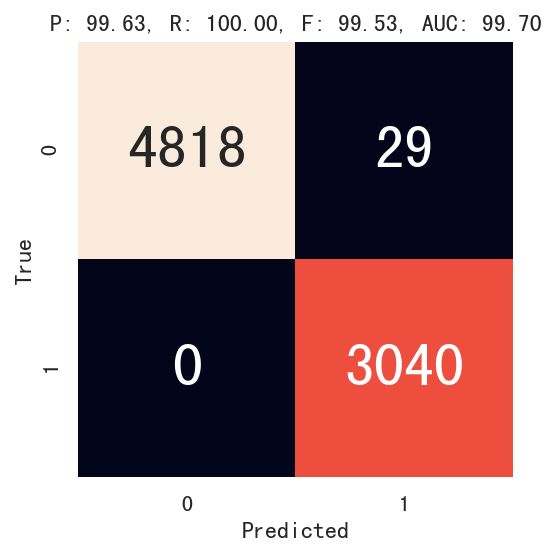

In [714]:
pred_y_train = clf.predict(X_train)
plot_metrics(y_train, pred_y_train)

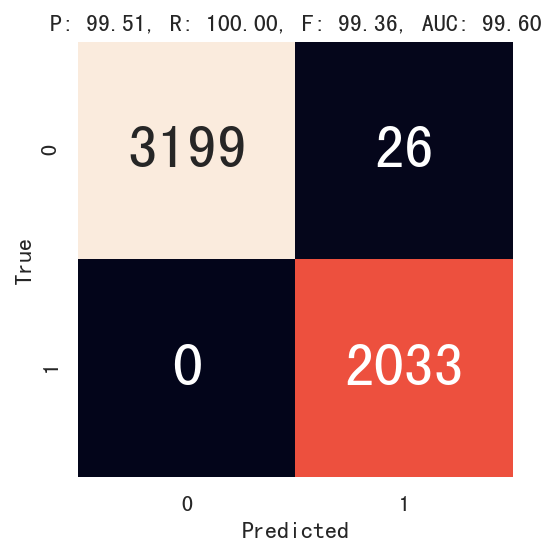

In [715]:
pred_y_val = clf.predict(X_val)
plot_metrics(y_val, pred_y_val)

查看特征排序

In [473]:
def plot_feature_importance(clf, columns, yscale="log"):
    fea_importance = clf.feature_importances_
    columns = columns[np.argsort(-fea_importance)]
    scores = np.sort(fea_importance)[::-1]
    import logging
    logging.getLogger("matplotlib").setLevel(logging.CRITICAL)
    plt.figure(figsize=(20, 10))
    plt.bar(x=range(len(columns)), height=scores, tick_label=columns)
    plt.xticks(rotation=90)
    plt.yscale(yscale)

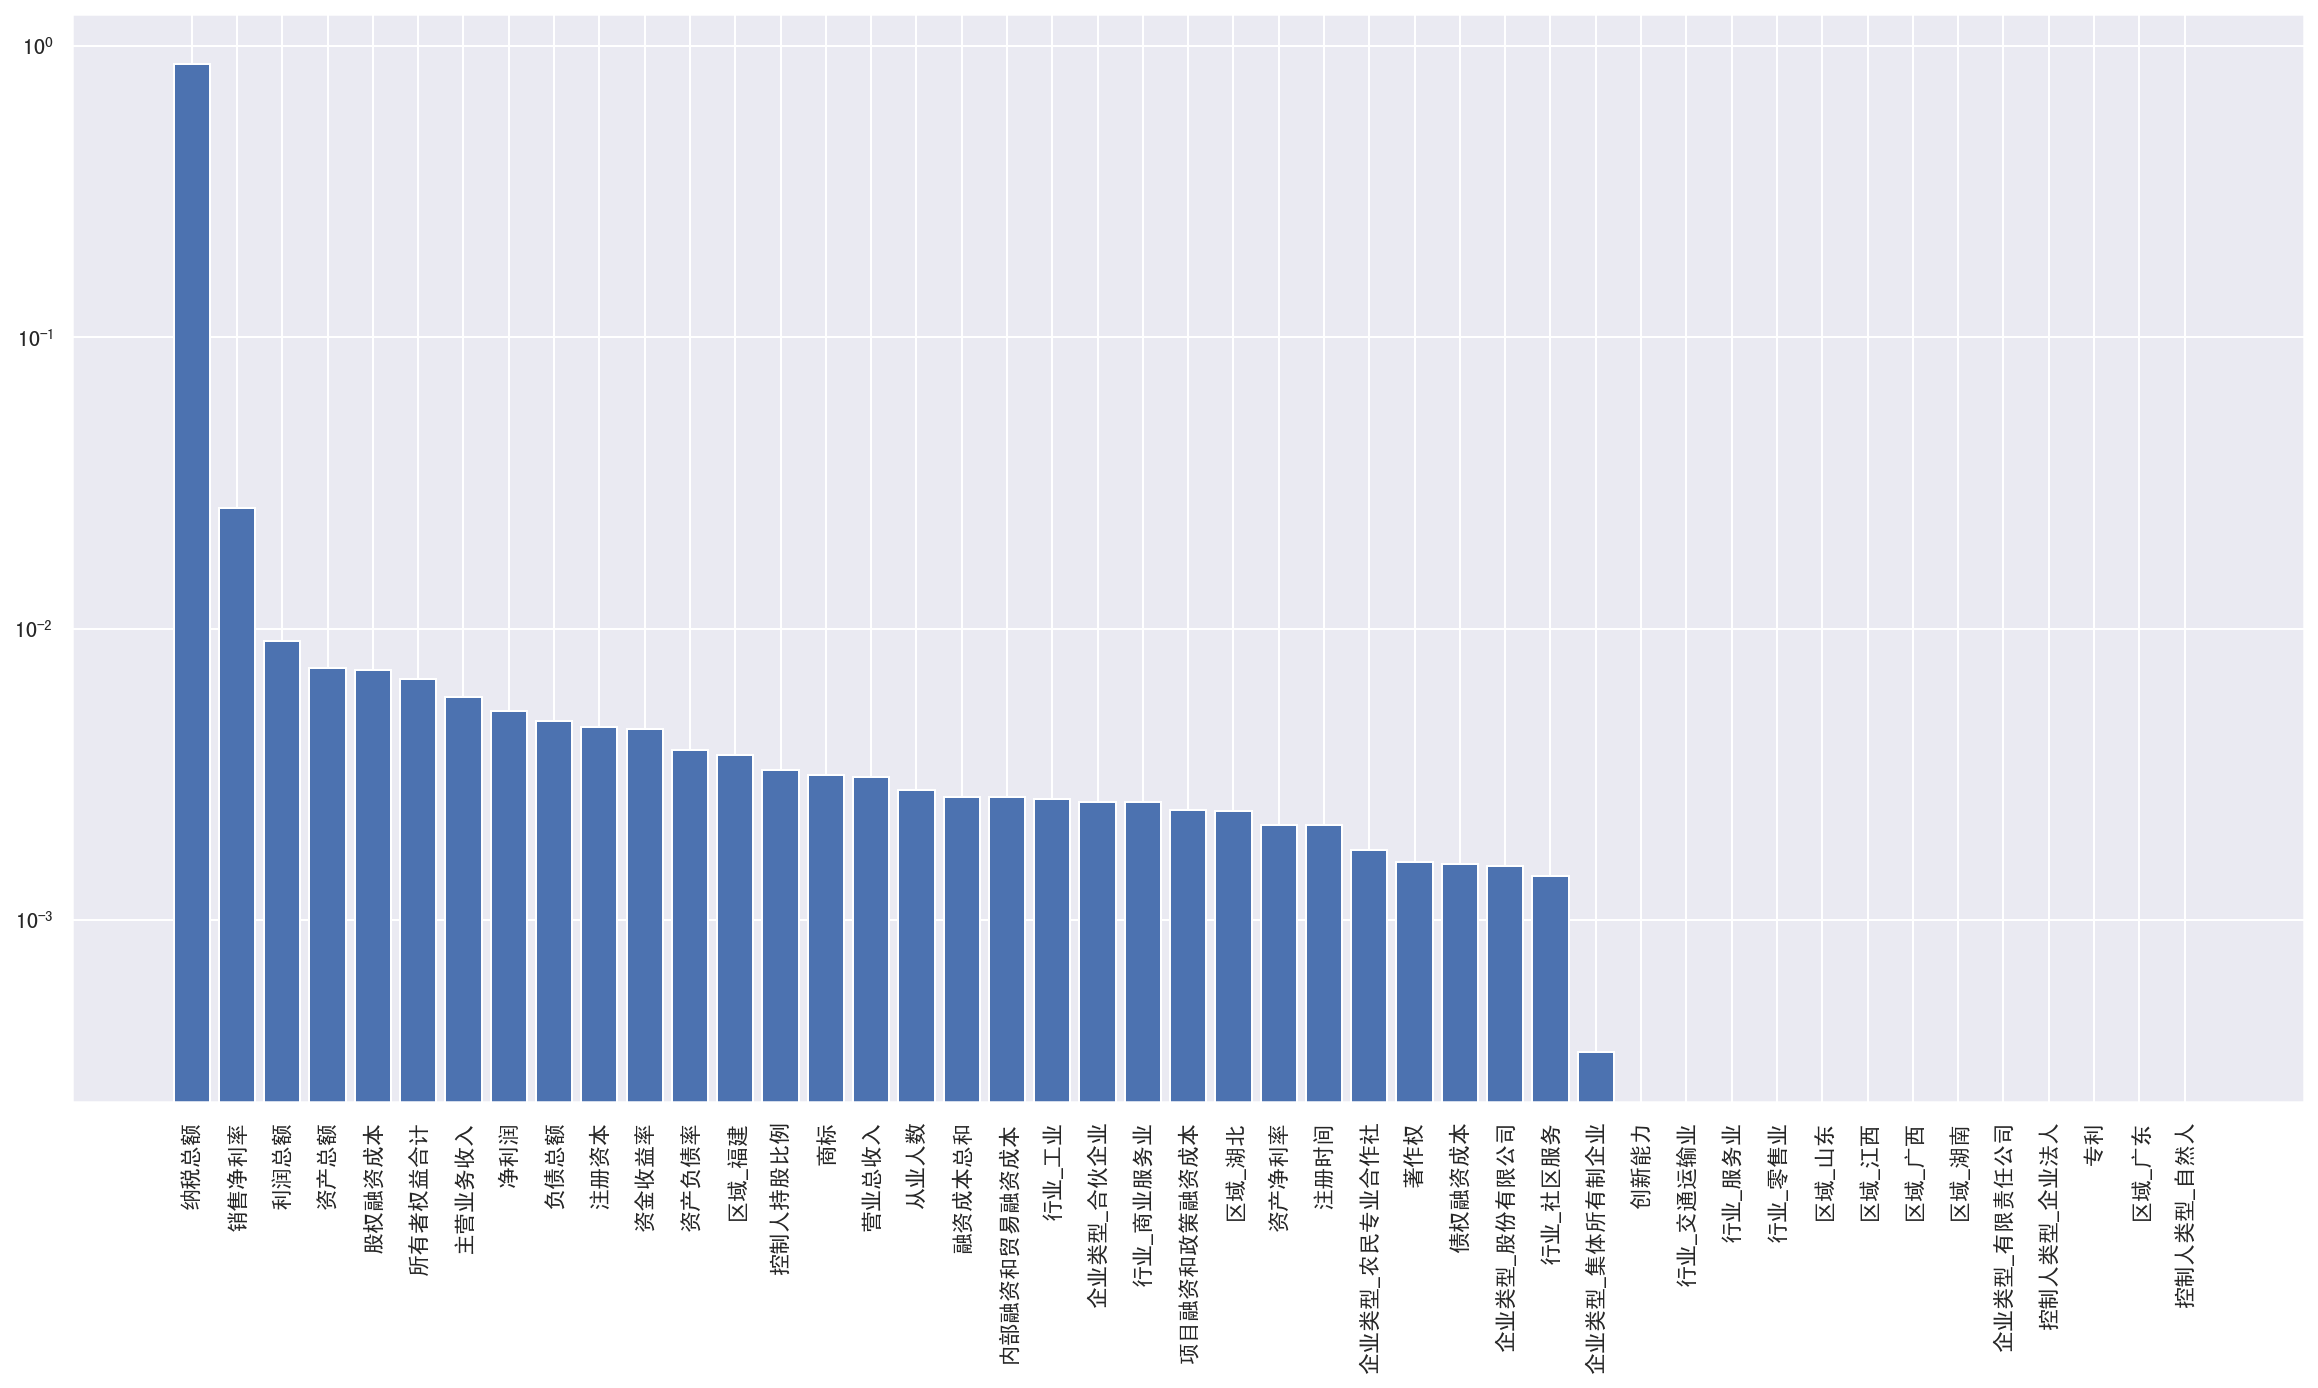

In [510]:
plot_feature_importance(clf, train_feature.columns)

### 参数调整

max_depth + min_child_weight

In [524]:
param_set1 = {
    "max_depth": range(2, 11, 2),
    "min_child_weight": range(1, 10, 2)
}
gs_clf1 = GridSearchCV(estimator=XGBClassifier(), param_grid=param_set1, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf1.fit(train_feature, train_label)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  4.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(2, 11, 2),
                         'min_child_weight': range(1, 10, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_trai

In [525]:
gs_clf1.best_params_

{'max_depth': 2, 'min_child_weight': 3}

In [526]:
pd.DataFrame(gs_clf1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.301547,0.134313,0.010967,0.002187,2,1,"{'max_depth': 2, 'min_child_weight': 1}",0.966667,0.999507,0.999014,1.000000,0.999507,0.992939,0.013140,5
1,5.066432,0.245040,0.013315,0.001557,2,3,"{'max_depth': 2, 'min_child_weight': 3}",0.965747,0.999507,0.999507,1.000000,1.000000,0.992952,0.013604,1
2,4.999397,0.284616,0.016511,0.004411,2,5,"{'max_depth': 2, 'min_child_weight': 5}",0.965747,1.000000,0.999014,1.000000,1.000000,0.992952,0.013608,3
3,4.944624,0.381486,0.012965,0.003716,2,7,"{'max_depth': 2, 'min_child_weight': 7}",0.965747,1.000000,0.999507,1.000000,0.999507,0.992952,0.013604,4
4,4.964234,0.353185,0.014015,0.002516,2,9,"{'max_depth': 2, 'min_child_weight': 9}",0.965747,1.000000,0.999507,0.999507,1.000000,0.992952,0.013604,1
5,7.578379,0.996042,0.019126,0.001249,4,1,"{'max_depth': 4, 'min_child_weight': 1}",0.966667,0.998520,0.998520,0.999507,1.000000,0.992643,0.013001,15
6,8.933113,1.666861,0.024360,0.010092,4,3,"{'max_depth': 4, 'min_child_weight': 3}",0.965747,0.998520,0.999014,1.000000,0.999507,0.992557,0.013414,16
7,8.215042,1.411771,0.019412,0.007656,4,5,"{'max_depth': 4, 'min_child_weight': 5}",0.965747,0.999507,0.999507,0.999507,0.999507,0.992755,0.013504,8
8,8.585535,1.234626,0.014664,0.003811,4,7,"{'max_depth': 4, 'min_child_weight': 7}",0.965747,0.999507,0.999507,1.000000,0.999507,0.992854,0.013555,6
9,8.266176,1.217103,0.017493,0.003097,4,9,"{'max_depth': 4, 'min_child_weight': 9}",0.965747,0.999507,0.999507,1.000000,0.999013,0.992755,0.013508,9


In [527]:
%%time
pred_label1 = gs_clf1.predict(train_feature)

CPU times: user 27.2 ms, sys: 4.71 ms, total: 31.9 ms
Wall time: 42.6 ms


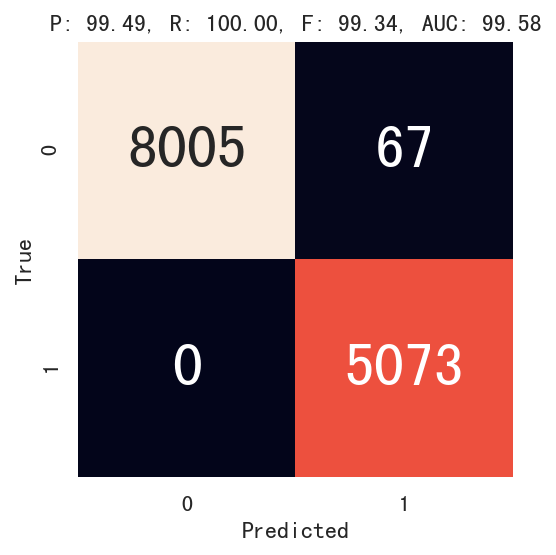

In [716]:
plot_metrics(train_label, pred_label1)

In [529]:
param_set2 = {
    "max_depth": [1, 2, 3],
    "min_child_weight": range(1, 6, 2)
}
gs_clf2 = GridSearchCV(estimator=XGBClassifier(), param_grid=param_set2, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf2.fit(train_feature, train_label)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3],
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score

In [530]:
gs_clf2.best_params_

{'max_depth': 1, 'min_child_weight': 1}

In [531]:
pd.DataFrame(gs_clf2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.477860,0.053149,0.012595,0.004114,1,1,"{'max_depth': 1, 'min_child_weight': 1}",0.965747,1.000000,1.000000,1.0,1.000000,0.993149,0.013701,1
1,3.623792,0.153380,0.012770,0.001563,1,3,"{'max_depth': 1, 'min_child_weight': 3}",0.965747,1.000000,1.000000,1.0,1.000000,0.993149,0.013701,1
2,3.541914,0.106189,0.018511,0.006831,1,5,"{'max_depth': 1, 'min_child_weight': 5}",0.965747,1.000000,0.999507,1.0,1.000000,0.993051,0.013653,3
3,5.124240,0.135171,0.017337,0.005049,2,1,"{'max_depth': 2, 'min_child_weight': 1}",0.966667,0.999507,0.999014,1.0,0.999507,0.992939,0.013140,6
4,5.115986,0.235011,0.015524,0.006653,2,3,"{'max_depth': 2, 'min_child_weight': 3}",0.965747,0.999507,0.999507,1.0,1.000000,0.992952,0.013604,4
5,5.176265,0.264384,0.012522,0.004225,2,5,"{'max_depth': 2, 'min_child_weight': 5}",0.965747,1.000000,0.999014,1.0,1.000000,0.992952,0.013608,5
6,6.588581,0.355482,0.015456,0.002763,3,1,"{'max_depth': 3, 'min_child_weight': 1}",0.966667,0.998520,0.998520,1.0,1.000000,0.992741,0.013054,9
7,6.216456,0.499393,0.016541,0.003922,3,3,"{'max_depth': 3, 'min_child_weight': 3}",0.965747,0.999507,0.999014,1.0,0.999507,0.992755,0.013508,8
8,5.503640,0.743529,0.012206,0.003459,3,5,"{'max_depth': 3, 'min_child_weight': 5}",0.965747,0.999507,0.999507,1.0,0.999507,0.992854,0.013555,7


In [532]:
%%time
pred_label2 = gs_clf2.predict(train_feature)

CPU times: user 21.8 ms, sys: 3.91 ms, total: 25.7 ms
Wall time: 26.1 ms


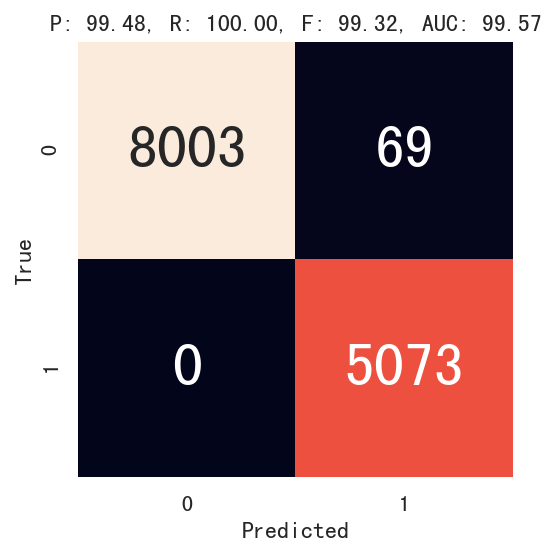

In [717]:
plot_metrics(train_label, pred_label2)

gamma

In [534]:
param_set3 = {
    "gamma": [i/10 for i in range(0, 11)]
}
gs_clf3 = GridSearchCV(estimator=XGBClassifier(max_depth=2, min_child_weight=5), param_grid=param_set3, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf3.fit(train_feature, train_label)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=5,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, re

In [535]:
gs_clf3.best_params_

{'gamma': 0.0}

In [536]:
pd.DataFrame(gs_clf3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.088914,0.336127,0.017046,0.009690,0,{'gamma': 0.0},0.965747,1.0,0.999014,1.0,1.0,0.992952,0.013608,1
1,5.126418,0.273219,0.014812,0.003436,0.1,{'gamma': 0.1},0.965747,1.0,0.999014,1.0,1.0,0.992952,0.013608,1
2,5.086758,0.351517,0.013073,0.002678,0.2,{'gamma': 0.2},0.965747,1.0,0.999014,1.0,1.0,0.992952,0.013608,1
3,4.976639,0.216214,0.016891,0.003602,0.3,{'gamma': 0.3},0.965747,1.0,0.999014,1.0,1.0,0.992952,0.013608,1
4,5.065419,0.308963,0.017628,0.003297,0.4,{'gamma': 0.4},0.965747,1.0,0.999014,1.0,1.0,0.992952,0.013608,1
5,4.981150,0.324603,0.015906,0.005783,0.5,{'gamma': 0.5},0.965747,1.0,0.999014,1.0,1.0,0.992952,0.013608,1
6,5.034506,0.246746,0.014482,0.004738,0.6,{'gamma': 0.6},0.965747,1.0,0.999014,1.0,1.0,0.992952,0.013608,1
7,5.013965,0.269262,0.016719,0.003133,0.7,{'gamma': 0.7},0.965747,1.0,0.999014,1.0,1.0,0.992952,0.013608,1
8,4.971887,0.267765,0.016789,0.004566,0.8,{'gamma': 0.8},0.965747,1.0,0.999014,1.0,1.0,0.992952,0.013608,1
9,5.134705,0.367904,0.011664,0.001796,0.9,{'gamma': 0.9},0.965747,1.0,0.999014,1.0,1.0,0.992952,0.013608,1


In [537]:
param_set4 = {
    "gamma": [i*100 for i in range(0, 11)]
}
gs_clf4 = GridSearchCV(estimator=XGBClassifier(max_depth=2, min_child_weight=5), param_grid=param_set4, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf4.fit(train_feature, train_label)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=5,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 100, 200, 300, 400, 500, 600, 700, 800,
                                   900, 1000]},
             pre_dispatch='2*n_jobs', refit=True, ret

In [538]:
gs_clf4.best_params_

{'gamma': 100}

In [539]:
pd.DataFrame(gs_clf4.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.985213,0.313920,0.014462,0.001323,0,{'gamma': 0},0.965747,1.000000,0.999014,1.000000,1.0,0.992952,0.013608,11
1,5.247292,0.042794,0.011282,0.001549,100,{'gamma': 100},0.965747,0.999508,1.000000,0.999507,1.0,0.992952,0.013604,1
2,5.292332,0.060337,0.011061,0.002085,200,{'gamma': 200},0.965747,0.999508,1.000000,0.999507,1.0,0.992952,0.013604,1
3,5.330513,0.043981,0.013769,0.005559,300,{'gamma': 300},0.965747,0.999508,1.000000,0.999507,1.0,0.992952,0.013604,1
4,5.232570,0.052625,0.013312,0.002357,400,{'gamma': 400},0.965747,0.999508,1.000000,0.999507,1.0,0.992952,0.013604,1
5,5.281847,0.115490,0.011348,0.002024,500,{'gamma': 500},0.965747,0.999508,1.000000,0.999507,1.0,0.992952,0.013604,1
6,5.361624,0.062477,0.010642,0.001564,600,{'gamma': 600},0.965747,0.999508,1.000000,0.999507,1.0,0.992952,0.013604,1
7,5.301517,0.087431,0.016096,0.005138,700,{'gamma': 700},0.965747,0.999508,1.000000,0.999507,1.0,0.992952,0.013604,1
8,5.344873,0.019521,0.013424,0.005409,800,{'gamma': 800},0.965747,0.999508,1.000000,0.999507,1.0,0.992952,0.013604,1
9,5.283149,0.035648,0.011310,0.001706,900,{'gamma': 900},0.965747,0.999508,1.000000,0.999507,1.0,0.992952,0.013604,1


subsample + colsample_bytree

In [546]:
param_set5 = {
    "subsample": [i/10 for i in range(6, 11)],
    "colsample_bytree": [i/10 for i in range(6, 11)]
}
gs_clf5 = GridSearchCV(estimator=XGBClassifier(max_depth=2, min_child_weight=3, gamma=0), param_grid=param_set5, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf5.fit(train_feature, train_label)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=3,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
                         'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
             pre_dispatch='2*n_jobs', ref

In [547]:
gs_clf5.best_params_

{'colsample_bytree': 0.6, 'subsample': 0.8}

In [548]:
pd.DataFrame(gs_clf5.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.775464,0.198676,0.015988,0.003889,0.6,0.6,"{'colsample_bytree': 0.6, 'subsample': 0.6}",0.965747,0.999507,0.999507,0.999507,1.0,0.992854,0.013555,21
1,3.798737,0.147061,0.015755,0.006173,0.6,0.7,"{'colsample_bytree': 0.6, 'subsample': 0.7}",0.965747,0.999507,0.999507,1.000000,1.0,0.992952,0.013604,10
2,3.939600,0.130903,0.018044,0.008114,0.6,0.8,"{'colsample_bytree': 0.6, 'subsample': 0.8}",0.965747,1.000000,0.999507,1.000000,1.0,0.993051,0.013653,1
3,3.793941,0.191066,0.014157,0.002845,0.6,0.9,"{'colsample_bytree': 0.6, 'subsample': 0.9}",0.965747,0.999507,0.999014,1.000000,1.0,0.992854,0.013558,19
4,3.891977,0.134261,0.011901,0.001415,0.6,1,"{'colsample_bytree': 0.6, 'subsample': 1.0}",0.966667,0.999507,0.999014,1.000000,1.0,0.993038,0.013190,6
5,4.092705,0.231748,0.012242,0.002875,0.7,0.6,"{'colsample_bytree': 0.7, 'subsample': 0.6}",0.965747,0.999507,0.999507,0.999507,1.0,0.992854,0.013555,21
6,4.170879,0.104626,0.014822,0.002974,0.7,0.7,"{'colsample_bytree': 0.7, 'subsample': 0.7}",0.965747,0.999507,0.999507,1.000000,1.0,0.992952,0.013604,10
7,4.279414,0.259398,0.017776,0.003064,0.7,0.8,"{'colsample_bytree': 0.7, 'subsample': 0.8}",0.965747,1.000000,0.999507,1.000000,1.0,0.993051,0.013653,1
8,4.139137,0.097540,0.012197,0.003825,0.7,0.9,"{'colsample_bytree': 0.7, 'subsample': 0.9}",0.965747,0.999507,0.999507,1.000000,1.0,0.992952,0.013604,10
9,4.105744,0.143783,0.012310,0.001627,0.7,1,"{'colsample_bytree': 0.7, 'subsample': 1.0}",0.966667,0.999507,0.999014,1.000000,1.0,0.993038,0.013190,6


learning_rate

In [549]:
param_set6 = {
    "learning_rate": [0.001, 0.01, 0.1, 1]
}
gs_clf6 = GridSearchCV(estimator=XGBClassifier(max_depth=2, min_child_weight=3, gamma=0, colsample_bytree=0.6, subsample=0.8), param_grid=param_set6, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf6.fit(train_feature, train_label)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   25.0s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   25.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=3,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(

In [550]:
gs_clf6.best_params_

{'learning_rate': 0.001}

In [551]:
pd.DataFrame(gs_clf6.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.018006,0.082373,0.012191,0.001912,0.001,{'learning_rate': 0.001},0.965747,0.999508,1.000000,1.000000,1.000000,0.993051,0.013653,1
1,4.057401,0.063398,0.018240,0.006395,0.01,{'learning_rate': 0.01},0.965747,0.999508,1.000000,0.999507,1.000000,0.992952,0.013604,3
2,3.882714,0.165952,0.012545,0.002865,0.1,{'learning_rate': 0.1},0.965747,1.000000,0.999507,1.000000,1.000000,0.993051,0.013653,2
3,3.566015,0.396743,0.015656,0.003652,1,{'learning_rate': 1},0.965747,0.997036,0.999508,0.997531,0.997038,0.991372,0.012845,4


In [552]:
param_set7 = {
    "learning_rate": [0.0001, 0.0002, 0.0005, 0.0008, 0.001, 0.002, 0.005]
}
gs_clf7 = GridSearchCV(estimator=XGBClassifier(max_depth=2, min_child_weight=3, gamma=0, colsample_bytree=0.6, subsample=0.8), param_grid=param_set7, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf7.fit(train_feature, train_label)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   42.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=3,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.0002, 0.0005, 0.0008,
                                           0.001, 0.002, 0.005]},
             pre_dispatch='2*n_job

In [553]:
gs_clf7.best_params_

{'learning_rate': 0.0001}

In [554]:
pd.DataFrame(gs_clf7.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.028148,0.120240,0.012348,0.001481,0.0001,{'learning_rate': 0.0001},0.965747,0.999508,1.0,1.000000,1.0,0.993051,0.013653,1
1,4.018215,0.177536,0.021800,0.010337,0.0002,{'learning_rate': 0.0002},0.965747,0.999508,1.0,1.000000,1.0,0.993051,0.013653,1
2,4.176757,0.147719,0.029152,0.021110,0.0005,{'learning_rate': 0.0005},0.965747,0.999508,1.0,1.000000,1.0,0.993051,0.013653,1
3,4.152500,0.060459,0.020036,0.004707,0.0008,{'learning_rate': 0.0008},0.965747,0.999508,1.0,1.000000,1.0,0.993051,0.013653,1
4,4.214666,0.135211,0.013795,0.003651,0.001,{'learning_rate': 0.001},0.965747,0.999508,1.0,1.000000,1.0,0.993051,0.013653,1
5,4.004422,0.070254,0.015363,0.006388,0.002,{'learning_rate': 0.002},0.965747,0.999508,1.0,0.999507,1.0,0.992952,0.013604,6
6,3.400132,0.489234,0.014563,0.005665,0.005,{'learning_rate': 0.005},0.965747,0.999508,1.0,0.999507,1.0,0.992952,0.013604,6


n_estimators

In [555]:
param_set8 = {
    "n_estimators": [1, 5, 10, 50, 100, 500]
}
gs_clf8 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.001, max_depth=2, min_child_weight=3, gamma=0, colsample_bytree=0.6, subsample=0.8), param_grid=param_set8, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf8.fit(train_feature, train_label)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   42.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   42.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.001, max_delta_step=0,
                                     max_depth=2, min_child_weight=3,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [1, 5, 10, 50, 100, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_sco

In [556]:
gs_clf8.best_params_

{'n_estimators': 500}

In [557]:
pd.DataFrame(gs_clf8.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.129562,0.010356,0.013984,0.007169,1,{'n_estimators': 1},0.952981,0.982474,0.981546,0.984000,0.982526,0.976705,0.011888,6
1,0.290471,0.004766,0.019424,0.007154,5,{'n_estimators': 5},0.965747,0.999507,0.999507,1.000000,1.000000,0.992952,0.013604,5
2,0.470162,0.037418,0.012179,0.004738,10,{'n_estimators': 10},0.965747,0.999508,1.000000,0.999507,1.000000,0.992952,0.013604,3
3,2.019506,0.050282,0.011181,0.001707,50,{'n_estimators': 50},0.965747,0.999508,1.000000,0.999507,1.000000,0.992952,0.013604,3
4,4.090593,0.080771,0.014914,0.004052,100,{'n_estimators': 100},0.965747,0.999508,1.000000,1.000000,1.000000,0.993051,0.013653,2
5,17.373422,3.848984,0.026141,0.005663,500,{'n_estimators': 500},0.965747,1.000000,1.000000,1.000000,1.000000,0.993149,0.013701,1


In [558]:
param_set9 = {
    "n_estimators": [100, 300, 500, 700, 900]
}
gs_clf9 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.001, max_depth=2, min_child_weight=3, gamma=0, colsample_bytree=0.6, subsample=0.8), param_grid=param_set9, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf9.fit(train_feature, train_label)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.001, max_delta_step=0,
                                     max_depth=2, min_child_weight=3,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [100, 300, 500, 700, 900]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_sc

In [559]:
gs_clf9.best_params_

{'n_estimators': 500}

In [560]:
pd.DataFrame(gs_clf9.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.288011,0.095229,0.012511,0.002367,100,{'n_estimators': 100},0.965747,0.999508,1.0,1.0,1.0,0.993051,0.013653,4
1,11.697536,0.138864,0.023979,0.002325,300,{'n_estimators': 300},0.965747,0.999507,1.0,1.0,1.0,0.993051,0.013653,5
2,20.197326,0.938237,0.034877,0.004205,500,{'n_estimators': 500},0.965747,1.000000,1.0,1.0,1.0,0.993149,0.013701,1
3,31.262421,0.885330,0.061018,0.026712,700,{'n_estimators': 700},0.965747,1.000000,1.0,1.0,1.0,0.993149,0.013701,1
4,32.954805,2.790364,0.054902,0.011896,900,{'n_estimators': 900},0.965747,1.000000,1.0,1.0,1.0,0.993149,0.013701,1


In [561]:
param_set10 = {
    "n_estimators": [500, 1000, 1500]
}
gs_clf10 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.001, max_depth=2, min_child_weight=3, gamma=0, colsample_bytree=0.6, subsample=0.8), param_grid=param_set10, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf10.fit(train_feature, train_label)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.2min remaining:   32.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.001, max_delta_step=0,
                                     max_depth=2, min_child_weight=3,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [500, 1000, 1500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_

In [562]:
gs_clf10.best_params_

{'n_estimators': 500}

In [563]:
pd.DataFrame(gs_clf10.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,23.164027,0.151622,0.043801,0.008107,500,{'n_estimators': 500},0.965747,1.000000,1.0,1.000000,1.0,0.993149,0.013701,1
1,41.207342,2.412021,0.068133,0.012201,1000,{'n_estimators': 1000},0.965747,1.000000,1.0,1.000000,1.0,0.993149,0.013701,1
2,49.057715,8.521743,0.073370,0.020917,1500,{'n_estimators': 1500},0.965747,0.999508,1.0,0.999507,1.0,0.992952,0.013604,3


In [564]:
param_set11 = {
    "n_estimators": [300, 350, 400, 450, 500, 550, 600]
}
gs_clf11 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.001, max_depth=2, min_child_weight=3, gamma=0, colsample_bytree=0.6, subsample=0.8), param_grid=param_set11, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf11.fit(train_feature, train_label)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.001, max_delta_step=0,
                                     max_depth=2, min_child_weight=3,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [300, 350, 400, 450, 500, 550, 600]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scori

In [565]:
gs_clf11.best_params_

{'n_estimators': 350}

In [566]:
pd.DataFrame(gs_clf11.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.261638,0.092617,0.027602,0.010611,300,{'n_estimators': 300},0.965747,0.999507,1.0,1.0,1.0,0.993051,0.013653,7
1,13.084586,0.107448,0.024053,0.006277,350,{'n_estimators': 350},0.965747,1.000000,1.0,1.0,1.0,0.993149,0.013701,1
2,14.943895,0.178923,0.028636,0.003929,400,{'n_estimators': 400},0.965747,1.000000,1.0,1.0,1.0,0.993149,0.013701,1
3,17.289394,0.228101,0.028720,0.002306,450,{'n_estimators': 450},0.965747,1.000000,1.0,1.0,1.0,0.993149,0.013701,1
4,18.701155,0.141528,0.035398,0.004359,500,{'n_estimators': 500},0.965747,1.000000,1.0,1.0,1.0,0.993149,0.013701,1
5,20.978822,0.683577,0.037817,0.004635,550,{'n_estimators': 550},0.965747,1.000000,1.0,1.0,1.0,0.993149,0.013701,1
6,20.125371,3.151566,0.031098,0.008218,600,{'n_estimators': 600},0.965747,1.000000,1.0,1.0,1.0,0.993149,0.013701,1


all

In [567]:
param_set12 = {
    "max_depth": [1, 2, 3],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7],
    "learning_rate": [0.0005, 0.001],
    "n_estimators": [100, 350, 500]
}
gs_clf12 = GridSearchCV(estimator=XGBClassifier(), param_grid=param_set12, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf12.fit(train_feature, train_label)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 42.9min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 71.0min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 80.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po..., seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7],
                         'learning_rate': [0.0005, 0.001],
                         'max_depth': [1, 2, 3], 'min_child_weigh

In [568]:
gs_clf12.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.001,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 500,
 'subsample': 0.8}

In [569]:
df = pd.DataFrame(gs_clf12.cv_results_)
df[df.rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
95,25.63396,0.991513,0.0515,0.016885,0.5,0.001,3,1,500,0.8,"{'colsample_bytree': 0.5, 'learning_rate': 0.0...",0.967588,0.999507,1.0,1.0,1.0,0.993419,0.012917,1


In [570]:
%%time
pred_label12 = gs_clf12.predict(train_feature)

CPU times: user 135 ms, sys: 5.64 ms, total: 141 ms
Wall time: 172 ms


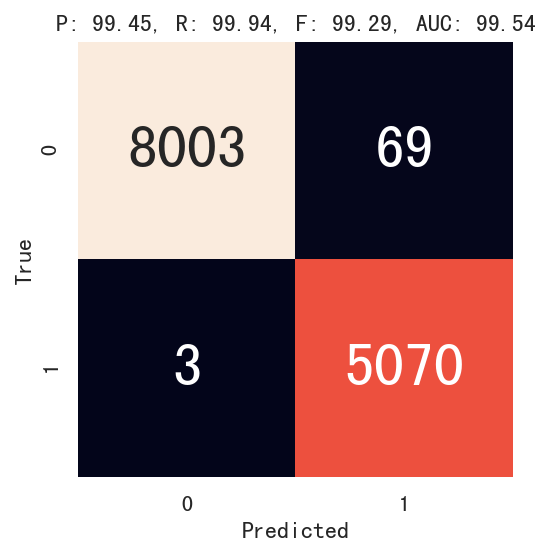

In [718]:
plot_metrics(train_label, pred_label12)

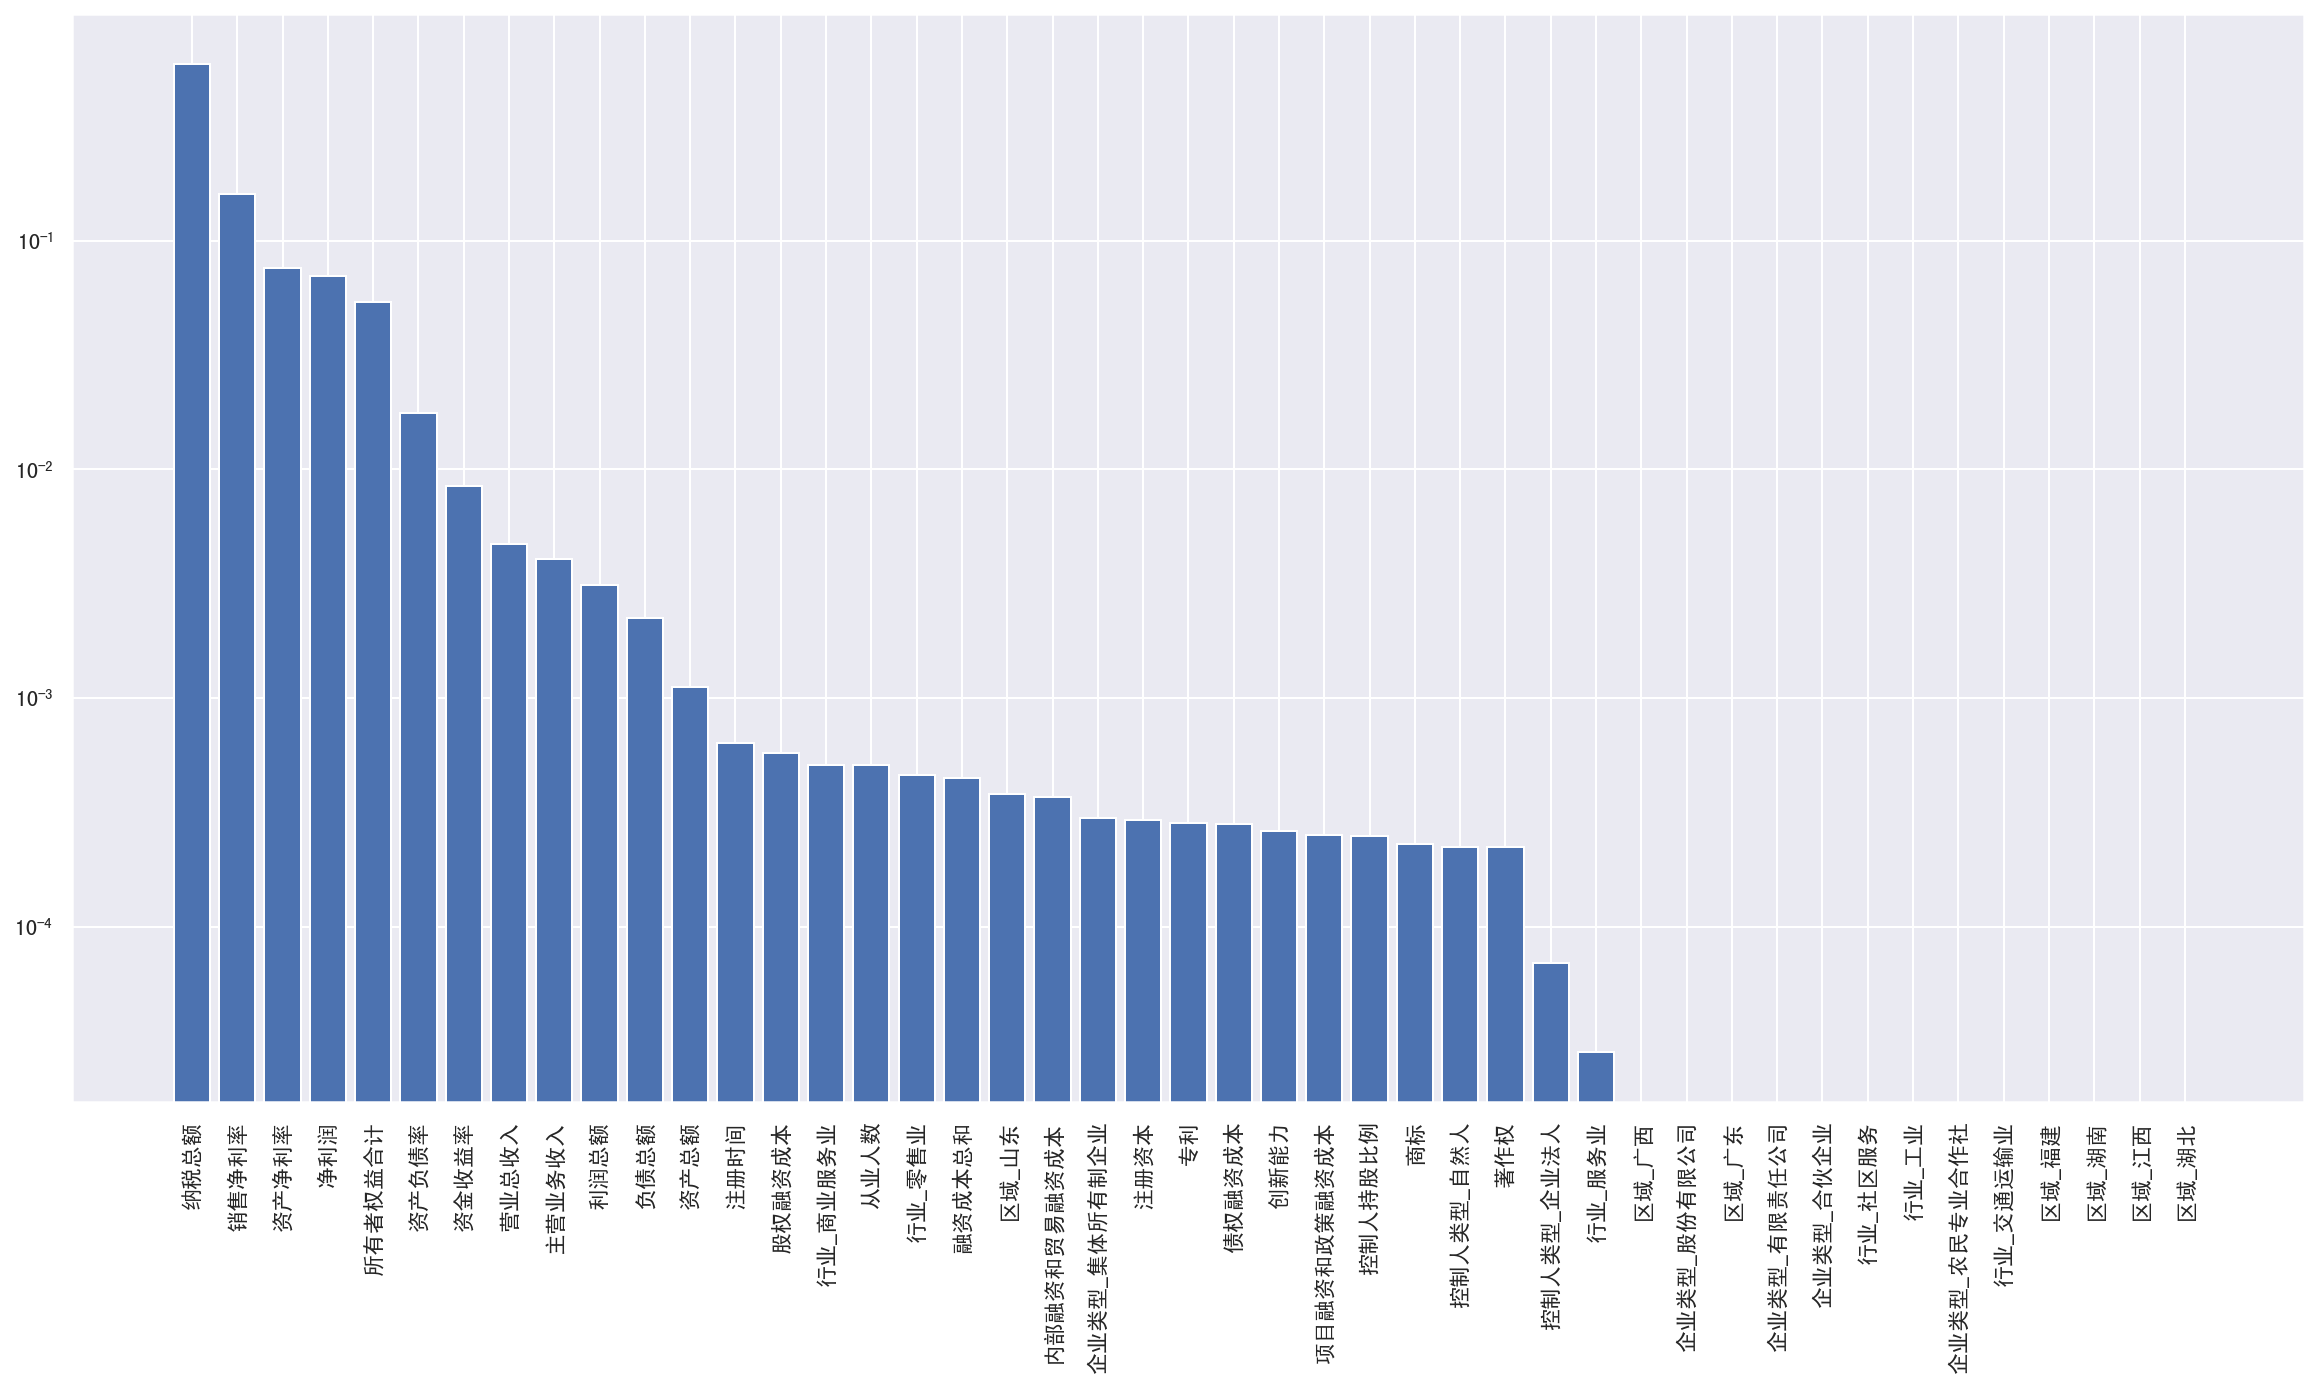

In [572]:
plot_feature_importance(gs_clf12.best_estimator_, train_feature.columns)

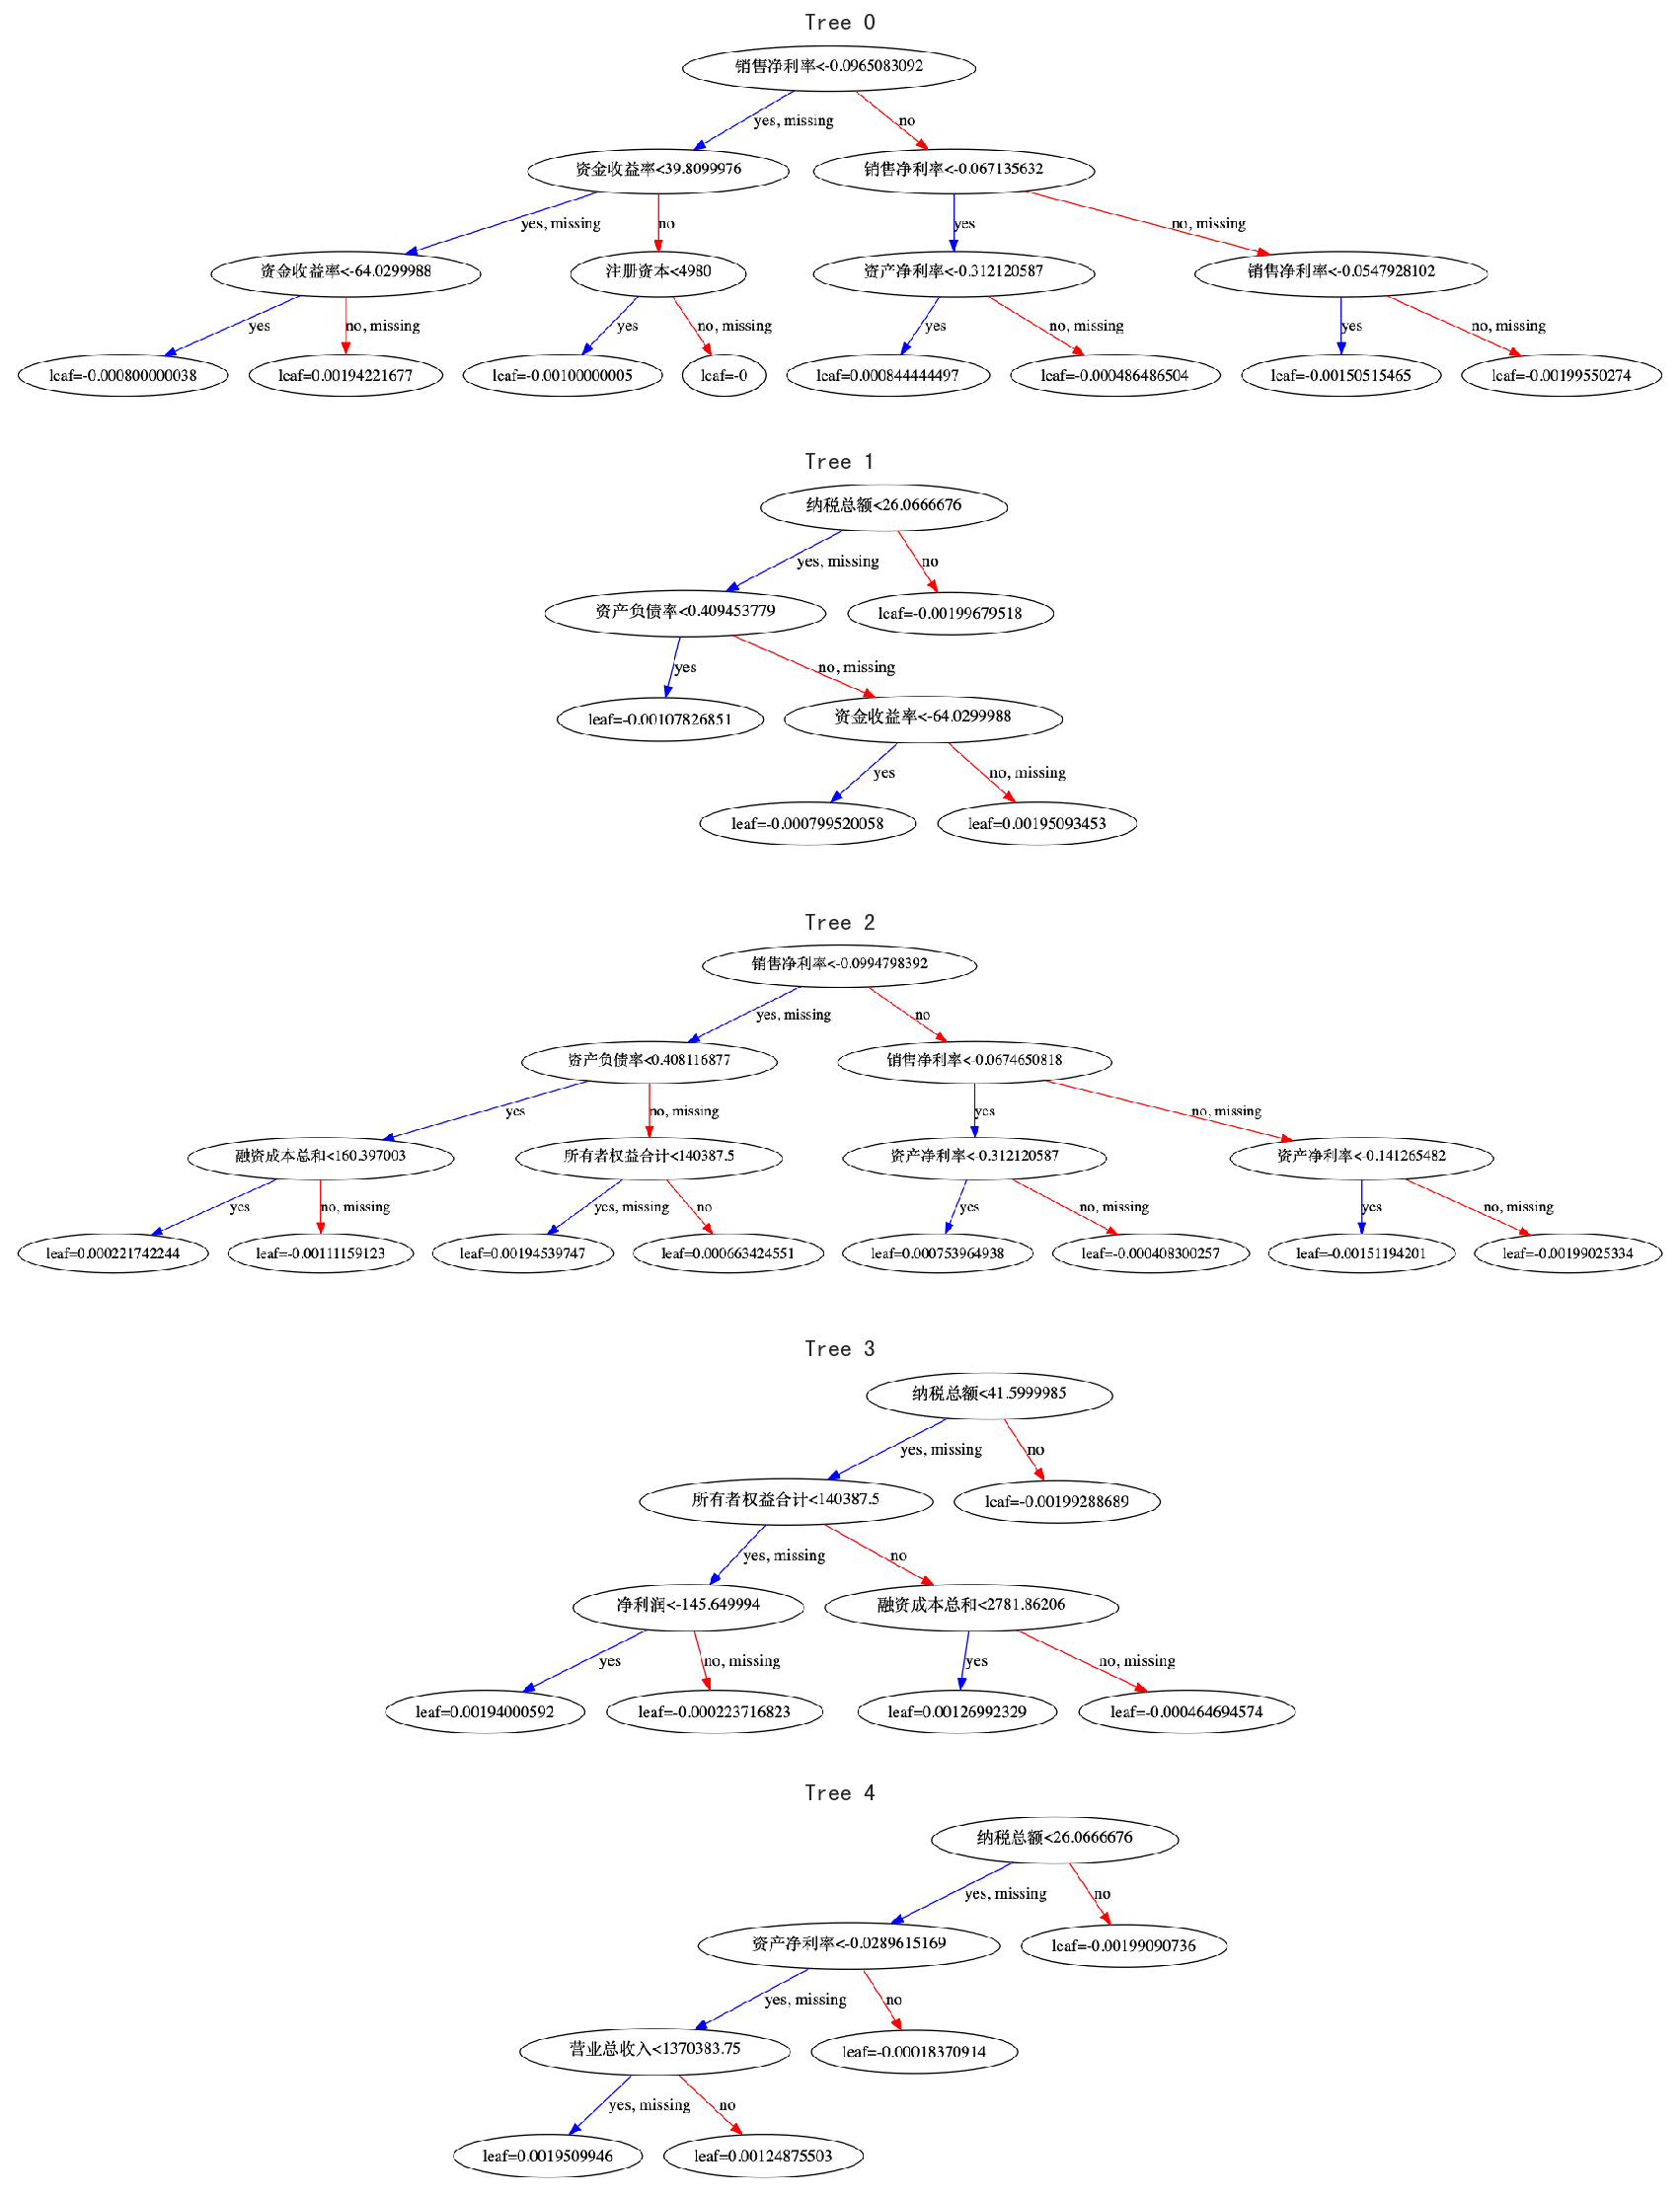

In [573]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))
for i, axi in enumerate(axes.flat):
    axi.set_title("Tree {}".format(i))
    plot_tree(gs_clf12.best_estimator_, num_trees=i, ax=axi);

## LightGBM模型训练

In [576]:
%%time
lgb_clf = LGBMClassifier()
lgb_clf.fit(X_train.values, y_train)

CPU times: user 1.59 s, sys: 37.8 ms, total: 1.62 s
Wall time: 700 ms


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [577]:
%%time
pred_label = lgb_clf.predict(train_feature.values)

CPU times: user 133 ms, sys: 8.02 ms, total: 141 ms
Wall time: 121 ms


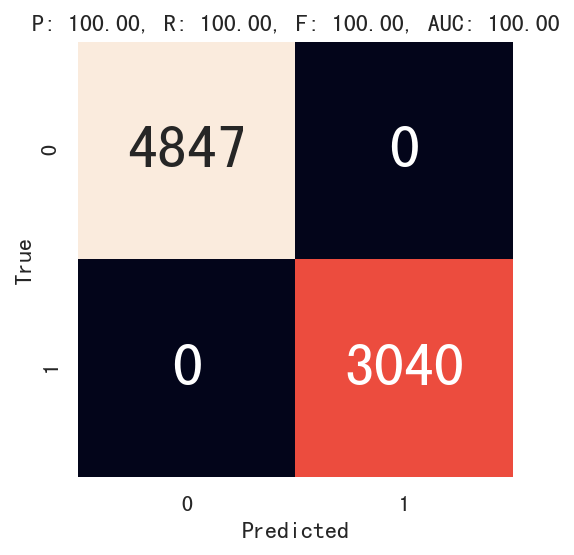

In [719]:
pred_y_train = lgb_clf.predict(X_train.values)
plot_metrics(y_train, pred_y_train)

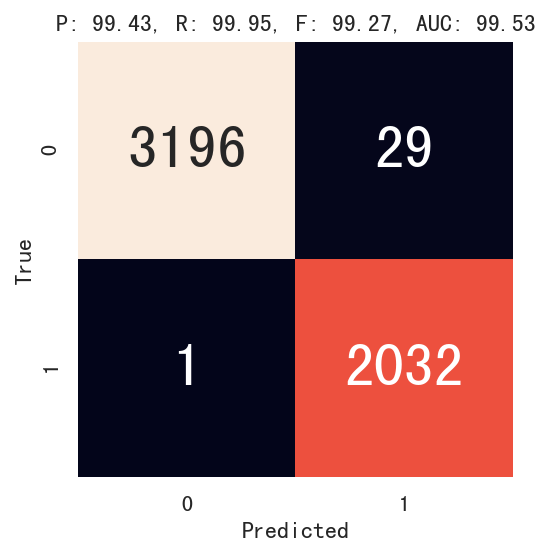

In [720]:
pred_y_val = lgb_clf.predict(X_val.values)
plot_metrics(y_val, pred_y_val)

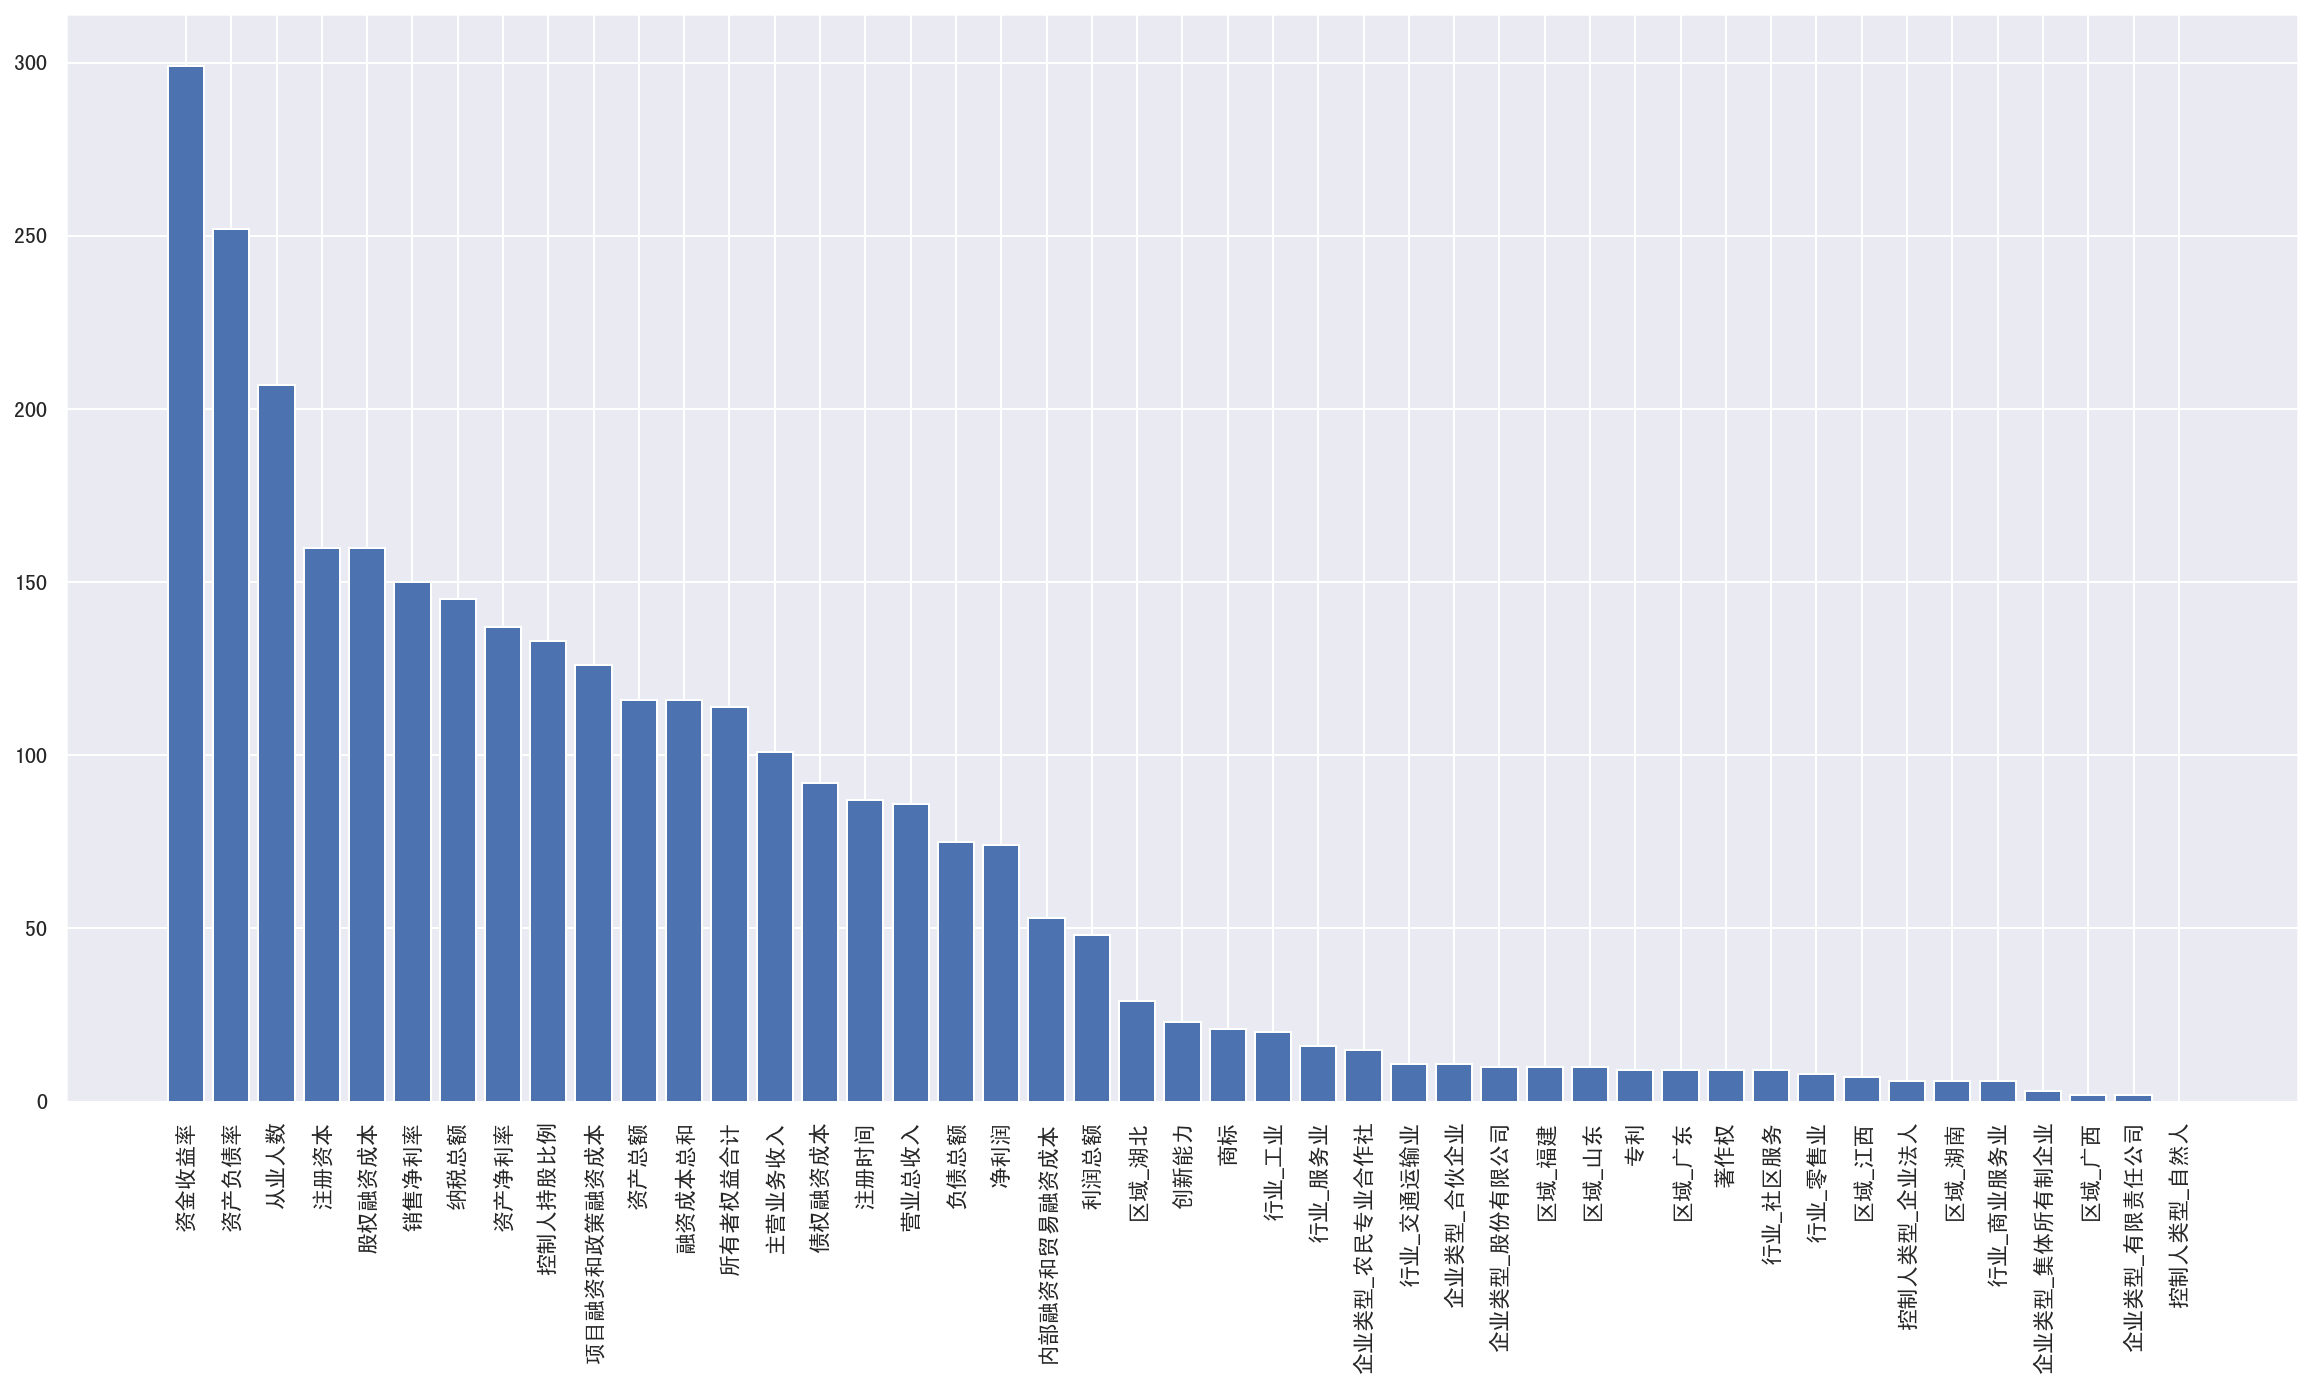

In [580]:
plot_feature_importance(lgb_clf, train_feature.columns, yscale="linear")

### 参数调整

max_depth + num_leaves

In [581]:
param_set13 = {
    "max_depth": range(2, 11, 2),
    "num_leaves": range(10, 100, 20)
}
gs_clf13 = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_set13, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf13.fit(train_feature.values, train_label)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   38.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(2, 11, 2),
                         'num_leaves': ra

In [582]:
gs_clf13.best_params_

{'max_depth': 10, 'num_leaves': 30}

In [583]:
pd.DataFrame(gs_clf13.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.371734,0.021739,0.018258,0.004506,2,10,"{'max_depth': 2, 'num_leaves': 10}",0.967127,0.999014,0.999014,0.999507,0.999507,0.992834,0.012855,4
1,0.392614,0.022229,0.016644,0.001780,2,30,"{'max_depth': 2, 'num_leaves': 30}",0.967127,0.999014,0.999014,0.999507,0.999507,0.992834,0.012855,4
2,0.460271,0.042786,0.020587,0.006964,2,50,"{'max_depth': 2, 'num_leaves': 50}",0.967127,0.999014,0.999014,0.999507,0.999507,0.992834,0.012855,4
3,0.415715,0.049692,0.016839,0.003393,2,70,"{'max_depth': 2, 'num_leaves': 70}",0.967127,0.999014,0.999014,0.999507,0.999507,0.992834,0.012855,4
4,0.371379,0.017723,0.020517,0.006109,2,90,"{'max_depth': 2, 'num_leaves': 90}",0.967127,0.999014,0.999014,0.999507,0.999507,0.992834,0.012855,4
5,0.574069,0.010288,0.022110,0.002469,4,10,"{'max_depth': 4, 'num_leaves': 10}",0.967127,0.997531,0.999014,0.999507,0.999507,0.992537,0.012726,20
6,0.590118,0.024644,0.026754,0.008272,4,30,"{'max_depth': 4, 'num_leaves': 30}",0.967127,0.998026,0.999014,0.999013,0.998519,0.992340,0.012612,22
7,0.623226,0.024846,0.023588,0.003116,4,50,"{'max_depth': 4, 'num_leaves': 50}",0.967127,0.998026,0.999014,0.999013,0.998519,0.992340,0.012612,22
8,0.600110,0.002724,0.019786,0.002869,4,70,"{'max_depth': 4, 'num_leaves': 70}",0.967127,0.998026,0.999014,0.999013,0.998519,0.992340,0.012612,22
9,0.581815,0.019256,0.019353,0.003528,4,90,"{'max_depth': 4, 'num_leaves': 90}",0.967127,0.998026,0.999014,0.999013,0.998519,0.992340,0.012612,22


In [584]:
param_set14 = {
    "max_depth": [10, 15, 20],
    "num_leaves": [30, 50, 70]
}
gs_clf14 = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_set14, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf14.fit(train_feature.values, train_label)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20], 'num_leaves': [30, 50, 70]},
             pr

In [585]:
gs_clf14.best_params_

{'max_depth': 15, 'num_leaves': 30}

In [586]:
pd.DataFrame(gs_clf14.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.260562,0.162754,0.034610,0.010191,10,30,"{'max_depth': 10, 'num_leaves': 30}",0.967127,0.999014,0.999507,1.000000,0.999507,0.993031,0.012956,3
1,1.842050,0.266474,0.047788,0.012570,10,50,"{'max_depth': 10, 'num_leaves': 50}",0.967127,0.999014,0.999507,1.000000,0.999507,0.993031,0.012956,3
2,1.695582,0.175210,0.042367,0.008857,10,70,"{'max_depth': 10, 'num_leaves': 70}",0.967127,0.999014,0.999014,1.000000,0.999013,0.992834,0.012859,8
3,1.394930,0.144183,0.038839,0.008286,15,30,"{'max_depth': 15, 'num_leaves': 30}",0.967127,0.999014,0.999507,1.000000,1.000000,0.993130,0.013006,1
4,1.749850,0.161214,0.047233,0.012742,15,50,"{'max_depth': 15, 'num_leaves': 50}",0.967127,0.999014,0.999507,1.000000,1.000000,0.993130,0.013006,1
5,2.007608,0.301145,0.048079,0.014241,15,70,"{'max_depth': 15, 'num_leaves': 70}",0.967127,0.999014,0.999507,0.999507,0.999013,0.992834,0.012855,9
6,1.277086,0.091931,0.029086,0.005248,20,30,"{'max_depth': 20, 'num_leaves': 30}",0.967127,0.999014,0.999507,1.000000,0.999507,0.993031,0.012956,3
7,1.513498,0.160024,0.038933,0.009809,20,50,"{'max_depth': 20, 'num_leaves': 50}",0.967127,0.999014,0.999507,1.000000,0.999507,0.993031,0.012956,3
8,1.609468,0.282675,0.032931,0.007577,20,70,"{'max_depth': 20, 'num_leaves': 70}",0.967127,0.999014,0.999507,1.000000,0.999507,0.993031,0.012956,3


min_child_samples + min_child_weight

In [587]:
param_set15 = {
    "min_child_samples": [10, 20, 50, 100],
    "min_child_weight": [0.0001, 0.001, 0.01, 1]
}
gs_clf15 = GridSearchCV(estimator=LGBMClassifier(max_depth=15, num_leaves=30), param_grid=param_set15, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf15.fit(train_feature.values, train_label)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   28.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=15,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=30, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_child_samples': [10, 20, 50, 100],
                         'min_c

In [588]:
gs_clf15.best_params_

{'min_child_samples': 100, 'min_child_weight': 0.0001}

In [589]:
pd.DataFrame(gs_clf15.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_samples,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.188836,0.079647,0.028672,0.003529,10,0.0001,"{'min_child_samples': 10, 'min_child_weight': ...",0.967127,0.997531,0.999507,1.000000,0.999507,0.992734,0.012832,12
1,1.184772,0.064905,0.028308,0.005748,10,0.001,"{'min_child_samples': 10, 'min_child_weight': ...",0.967127,0.997531,0.999507,1.000000,0.999507,0.992734,0.012832,12
2,1.188552,0.110599,0.035046,0.009948,10,0.01,"{'min_child_samples': 10, 'min_child_weight': ...",0.967127,0.997531,0.999507,0.999507,0.999507,0.992636,0.012777,15
3,0.861949,0.149101,0.031434,0.010777,10,1,"{'min_child_samples': 10, 'min_child_weight': 1}",0.967127,0.997531,0.999507,0.999013,0.999507,0.992537,0.012726,16
4,1.187139,0.054565,0.027451,0.005266,20,0.0001,"{'min_child_samples': 20, 'min_child_weight': ...",0.967127,0.999014,0.999507,1.000000,1.000000,0.993130,0.013006,8
5,1.137788,0.055417,0.027858,0.006800,20,0.001,"{'min_child_samples': 20, 'min_child_weight': ...",0.967127,0.999014,0.999507,1.000000,1.000000,0.993130,0.013006,8
6,1.134576,0.115179,0.031220,0.004399,20,0.01,"{'min_child_samples': 20, 'min_child_weight': ...",0.967127,0.999014,0.999507,1.000000,1.000000,0.993130,0.013006,8
7,0.860271,0.173186,0.030139,0.007673,20,1,"{'min_child_samples': 20, 'min_child_weight': 1}",0.966667,0.998520,0.999507,0.999013,0.999507,0.992643,0.012993,14
8,1.077060,0.059366,0.028531,0.003177,50,0.0001,"{'min_child_samples': 50, 'min_child_weight': ...",0.967127,0.999014,1.000000,1.000000,1.000000,0.993228,0.013056,5
9,1.108486,0.064881,0.033776,0.004029,50,0.001,"{'min_child_samples': 50, 'min_child_weight': ...",0.967127,0.999014,1.000000,1.000000,1.000000,0.993228,0.013056,5


In [590]:
param_set16 = {
    "min_child_samples": [80, 100, 200, 500, 1000],
    "min_child_weight": [0, 1, 100, 1000]
}
gs_clf16 = GridSearchCV(estimator=LGBMClassifier(max_depth=15, num_leaves=30), param_grid=param_set16, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf16.fit(train_feature.values, train_label)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=15,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=30, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_child_samples': [80, 100, 200, 500, 1000],
                       

In [591]:
gs_clf16.best_params_

{'min_child_samples': 500, 'min_child_weight': 1}

In [592]:
pd.DataFrame(gs_clf16.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_samples,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.105558,0.018879,0.032100,0.001757,80,0,"{'min_child_samples': 80, 'min_child_weight': 0}",0.967127,0.999014,0.999507,1.000000,0.999507,0.993031,0.012956,8
1,0.905519,0.113353,0.038540,0.008544,80,1,"{'min_child_samples': 80, 'min_child_weight': 1}",0.966667,0.999507,0.999507,1.000000,1.000000,0.993136,0.013237,6
2,0.312605,0.039934,0.016977,0.007243,80,100,"{'min_child_samples': 80, 'min_child_weight': ...",0.965747,0.999508,1.000000,0.999507,1.000000,0.992952,0.013604,9
3,0.227430,0.022931,0.009484,0.004176,80,1000,"{'min_child_samples': 80, 'min_child_weight': ...",0.965747,0.999508,1.000000,0.999507,1.000000,0.992952,0.013604,9
4,1.090598,0.023691,0.032620,0.004526,100,0,"{'min_child_samples': 100, 'min_child_weight': 0}",0.967127,0.999507,0.999507,1.000000,1.000000,0.993228,0.013052,2
5,0.902671,0.109301,0.034654,0.006115,100,1,"{'min_child_samples': 100, 'min_child_weight': 1}",0.967127,0.999507,0.999507,1.000000,1.000000,0.993228,0.013052,2
6,0.317329,0.014050,0.012104,0.000888,100,100,"{'min_child_samples': 100, 'min_child_weight':...",0.965747,0.999508,1.000000,0.999507,1.000000,0.992952,0.013604,9
7,0.241559,0.011166,0.007044,0.001611,100,1000,"{'min_child_samples': 100, 'min_child_weight':...",0.965747,0.999508,1.000000,0.999507,1.000000,0.992952,0.013604,9
8,1.066514,0.089055,0.046781,0.004862,200,0,"{'min_child_samples': 200, 'min_child_weight': 0}",0.967127,0.999507,0.999507,1.000000,1.000000,0.993228,0.013052,2
9,0.829222,0.116997,0.034908,0.008552,200,1,"{'min_child_samples': 200, 'min_child_weight': 1}",0.967127,0.999507,0.999014,1.000000,1.000000,0.993130,0.013006,7


feature_fraction + bagging_fraction

In [595]:
param_set17 = {
    "feature_fraction": [i/10 for i in range(6, 11)],
    "bagging_fraction": [i/10 for i in range(6, 11)]
}
gs_clf17 = GridSearchCV(estimator=LGBMClassifier(max_depth=15, num_leaves=30, min_child_samples=500, min_child_weight=1), param_grid=param_set17, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf17.fit(train_feature.values, train_label)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   26.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=15,
                                      min_child_samples=500, min_child_weight=1,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=30, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
                         'feature_fraction': [0.6, 0.7, 0.8, 0.9,

In [596]:
gs_clf17.best_params_

{'bagging_fraction': 0.6, 'feature_fraction': 1.0}

In [597]:
pd.DataFrame(gs_clf17.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_fraction,param_feature_fraction,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.577810,0.050579,0.041245,0.005003,0.6,0.6,"{'bagging_fraction': 0.6, 'feature_fraction': ...",0.966207,0.999507,0.999507,1.0,1.0,0.993044,0.013421,11
1,0.521708,0.068118,0.034268,0.008587,0.6,0.7,"{'bagging_fraction': 0.6, 'feature_fraction': ...",0.966207,0.999507,0.999507,1.0,1.0,0.993044,0.013421,11
2,0.594174,0.064902,0.038119,0.009905,0.6,0.8,"{'bagging_fraction': 0.6, 'feature_fraction': ...",0.966207,0.999507,0.999507,1.0,1.0,0.993044,0.013421,11
3,0.640841,0.032213,0.033488,0.005613,0.6,0.9,"{'bagging_fraction': 0.6, 'feature_fraction': ...",0.967127,0.999507,0.999507,1.0,1.0,0.993228,0.013052,6
4,0.582684,0.050322,0.030781,0.006520,0.6,1,"{'bagging_fraction': 0.6, 'feature_fraction': ...",0.967127,1.000000,0.999507,1.0,1.0,0.993327,0.013101,1
5,0.518925,0.026123,0.033808,0.004960,0.7,0.6,"{'bagging_fraction': 0.7, 'feature_fraction': ...",0.966207,0.999507,0.999507,1.0,1.0,0.993044,0.013421,11
6,0.539199,0.048503,0.043634,0.012031,0.7,0.7,"{'bagging_fraction': 0.7, 'feature_fraction': ...",0.966207,0.999507,0.999507,1.0,1.0,0.993044,0.013421,11
7,0.625888,0.044916,0.029327,0.004830,0.7,0.8,"{'bagging_fraction': 0.7, 'feature_fraction': ...",0.966207,0.999507,0.999507,1.0,1.0,0.993044,0.013421,11
8,0.661992,0.116135,0.032198,0.007747,0.7,0.9,"{'bagging_fraction': 0.7, 'feature_fraction': ...",0.967127,0.999507,0.999507,1.0,1.0,0.993228,0.013052,6
9,0.583611,0.048208,0.029894,0.006320,0.7,1,"{'bagging_fraction': 0.7, 'feature_fraction': ...",0.967127,1.000000,0.999507,1.0,1.0,0.993327,0.013101,1


n_estimators

In [598]:
param_set18 = {
    "n_estimators": [10, 50, 100, 150, 200, 500, 1000]
}
gs_clf18 = GridSearchCV(estimator=LGBMClassifier(max_depth=15, num_leaves=30, min_child_samples=500, min_child_weight=1, bagging_fraction=0.6, feature_fraction=1), param_grid=param_set18, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf18.fit(train_feature.values, train_label)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   16.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.6,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0, feature_fraction=1,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=15,
                                      min_child_samples=500, min_child_weight=1,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=30, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [10, 50, 100, 15

In [599]:
gs_clf18.best_params_

{'n_estimators': 100}

In [600]:
pd.DataFrame(gs_clf18.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.173351,0.006524,0.015612,0.007127,10,{'n_estimators': 10},0.965747,0.999508,1.000000,0.999507,1.000000,0.992952,0.013604,4
1,0.342059,0.021399,0.014687,0.004179,50,{'n_estimators': 50},0.965747,1.000000,0.999507,0.999507,1.000000,0.992952,0.013604,5
2,0.589422,0.058946,0.028392,0.004264,100,{'n_estimators': 100},0.967127,1.000000,0.999507,1.000000,1.000000,0.993327,0.013101,1
3,0.810475,0.098965,0.036072,0.007343,150,{'n_estimators': 150},0.967127,1.000000,0.999014,1.000000,0.999507,0.993130,0.013006,2
4,1.007238,0.163325,0.059170,0.015172,200,{'n_estimators': 200},0.967127,1.000000,0.999014,1.000000,0.999507,0.993130,0.013006,2
5,2.073899,0.424609,0.112384,0.037263,500,{'n_estimators': 500},0.966667,1.000000,0.998026,0.999507,0.999014,0.992643,0.013004,7
6,3.047891,0.520881,0.143784,0.046988,1000,{'n_estimators': 1000},0.966667,1.000000,0.998520,0.999507,0.998521,0.992643,0.013001,6


all

In [601]:
param_set19 = {
    "max_depth": [12, 15, 18],
    "num_leaves": [25, 30, 35],
    "min_child_sample": [400, 500, 600],
    "feature_fraction": [0.9, 1],
    "bagging_fraction": [0.6, 0.7],
    "n_estimators": [80, 100, 120]
}
gs_clf19 = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_set19, scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
gs_clf19.fit(train_feature.values, train_label)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  8.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'bagging_fraction': [0.6, 0.7],
                         'feature_fract

In [833]:
gs_clf19.best_params_

{'bagging_fraction': 0.6,
 'feature_fraction': 0.9,
 'max_depth': 15,
 'min_child_sample': 400,
 'n_estimators': 100,
 'num_leaves': 35}

In [841]:
df = pd.DataFrame(gs_clf19.cv_results_)
df[df.rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_fraction,param_feature_fraction,param_max_depth,param_min_child_sample,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
32,1.156790,0.034341,0.032728,0.002376,0.6,0.9,15,400,100,35,"{'bagging_fraction': 0.6, 'feature_fraction': ...",0.967127,0.999014,1.0,1.0,1.0,0.993228,0.013056,1
35,1.439501,0.031146,0.040268,0.009118,0.6,0.9,15,400,120,35,"{'bagging_fraction': 0.6, 'feature_fraction': ...",0.967127,0.999014,1.0,1.0,1.0,0.993228,0.013056,1
41,1.157649,0.017727,0.028869,0.002969,0.6,0.9,15,500,100,35,"{'bagging_fraction': 0.6, 'feature_fraction': ...",0.967127,0.999014,1.0,1.0,1.0,0.993228,0.013056,1
44,1.399938,0.031332,0.036778,0.003837,0.6,0.9,15,500,120,35,"{'bagging_fraction': 0.6, 'feature_fraction': ...",0.967127,0.999014,1.0,1.0,1.0,0.993228,0.013056,1
50,1.161667,0.028368,0.029234,0.004739,0.6,0.9,15,600,100,35,"{'bagging_fraction': 0.6, 'feature_fraction': ...",0.967127,0.999014,1.0,1.0,1.0,0.993228,0.013056,1
53,1.375780,0.033177,0.036285,0.001594,0.6,0.9,15,600,120,35,"{'bagging_fraction': 0.6, 'feature_fraction': ...",0.967127,0.999014,1.0,1.0,1.0,0.993228,0.013056,1
194,1.240942,0.086816,0.033312,0.007385,0.7,0.9,15,400,100,35,"{'bagging_fraction': 0.7, 'feature_fraction': ...",0.967127,0.999014,1.0,1.0,1.0,0.993228,0.013056,1
197,1.410103,0.052363,0.042126,0.008194,0.7,0.9,15,400,120,35,"{'bagging_fraction': 0.7, 'feature_fraction': ...",0.967127,0.999014,1.0,1.0,1.0,0.993228,0.013056,1
203,1.229640,0.091118,0.030352,0.009285,0.7,0.9,15,500,100,35,"{'bagging_fraction': 0.7, 'feature_fraction': ...",0.967127,0.999014,1.0,1.0,1.0,0.993228,0.013056,1
206,1.418086,0.025988,0.036711,0.005387,0.7,0.9,15,500,120,35,"{'bagging_fraction': 0.7, 'feature_fraction': ...",0.967127,0.999014,1.0,1.0,1.0,0.993228,0.013056,1


In [839]:
%%time
pred_label19 = gs_clf19.predict(train_feature.values)

CPU times: user 100 ms, sys: 12.6 ms, total: 113 ms
Wall time: 107 ms


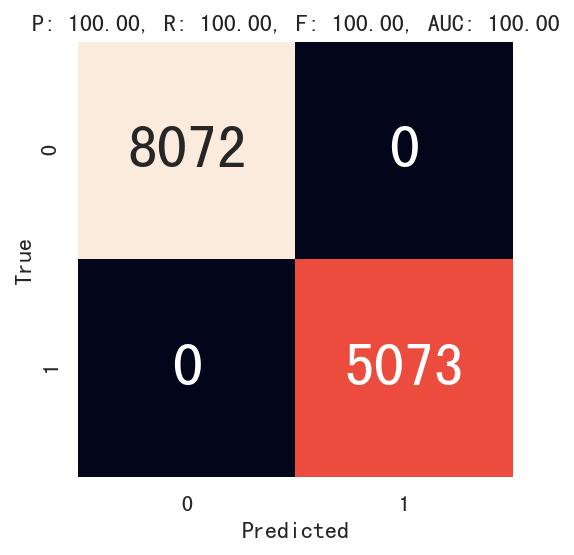

In [840]:
plot_metrics(train_label, pred_label19)

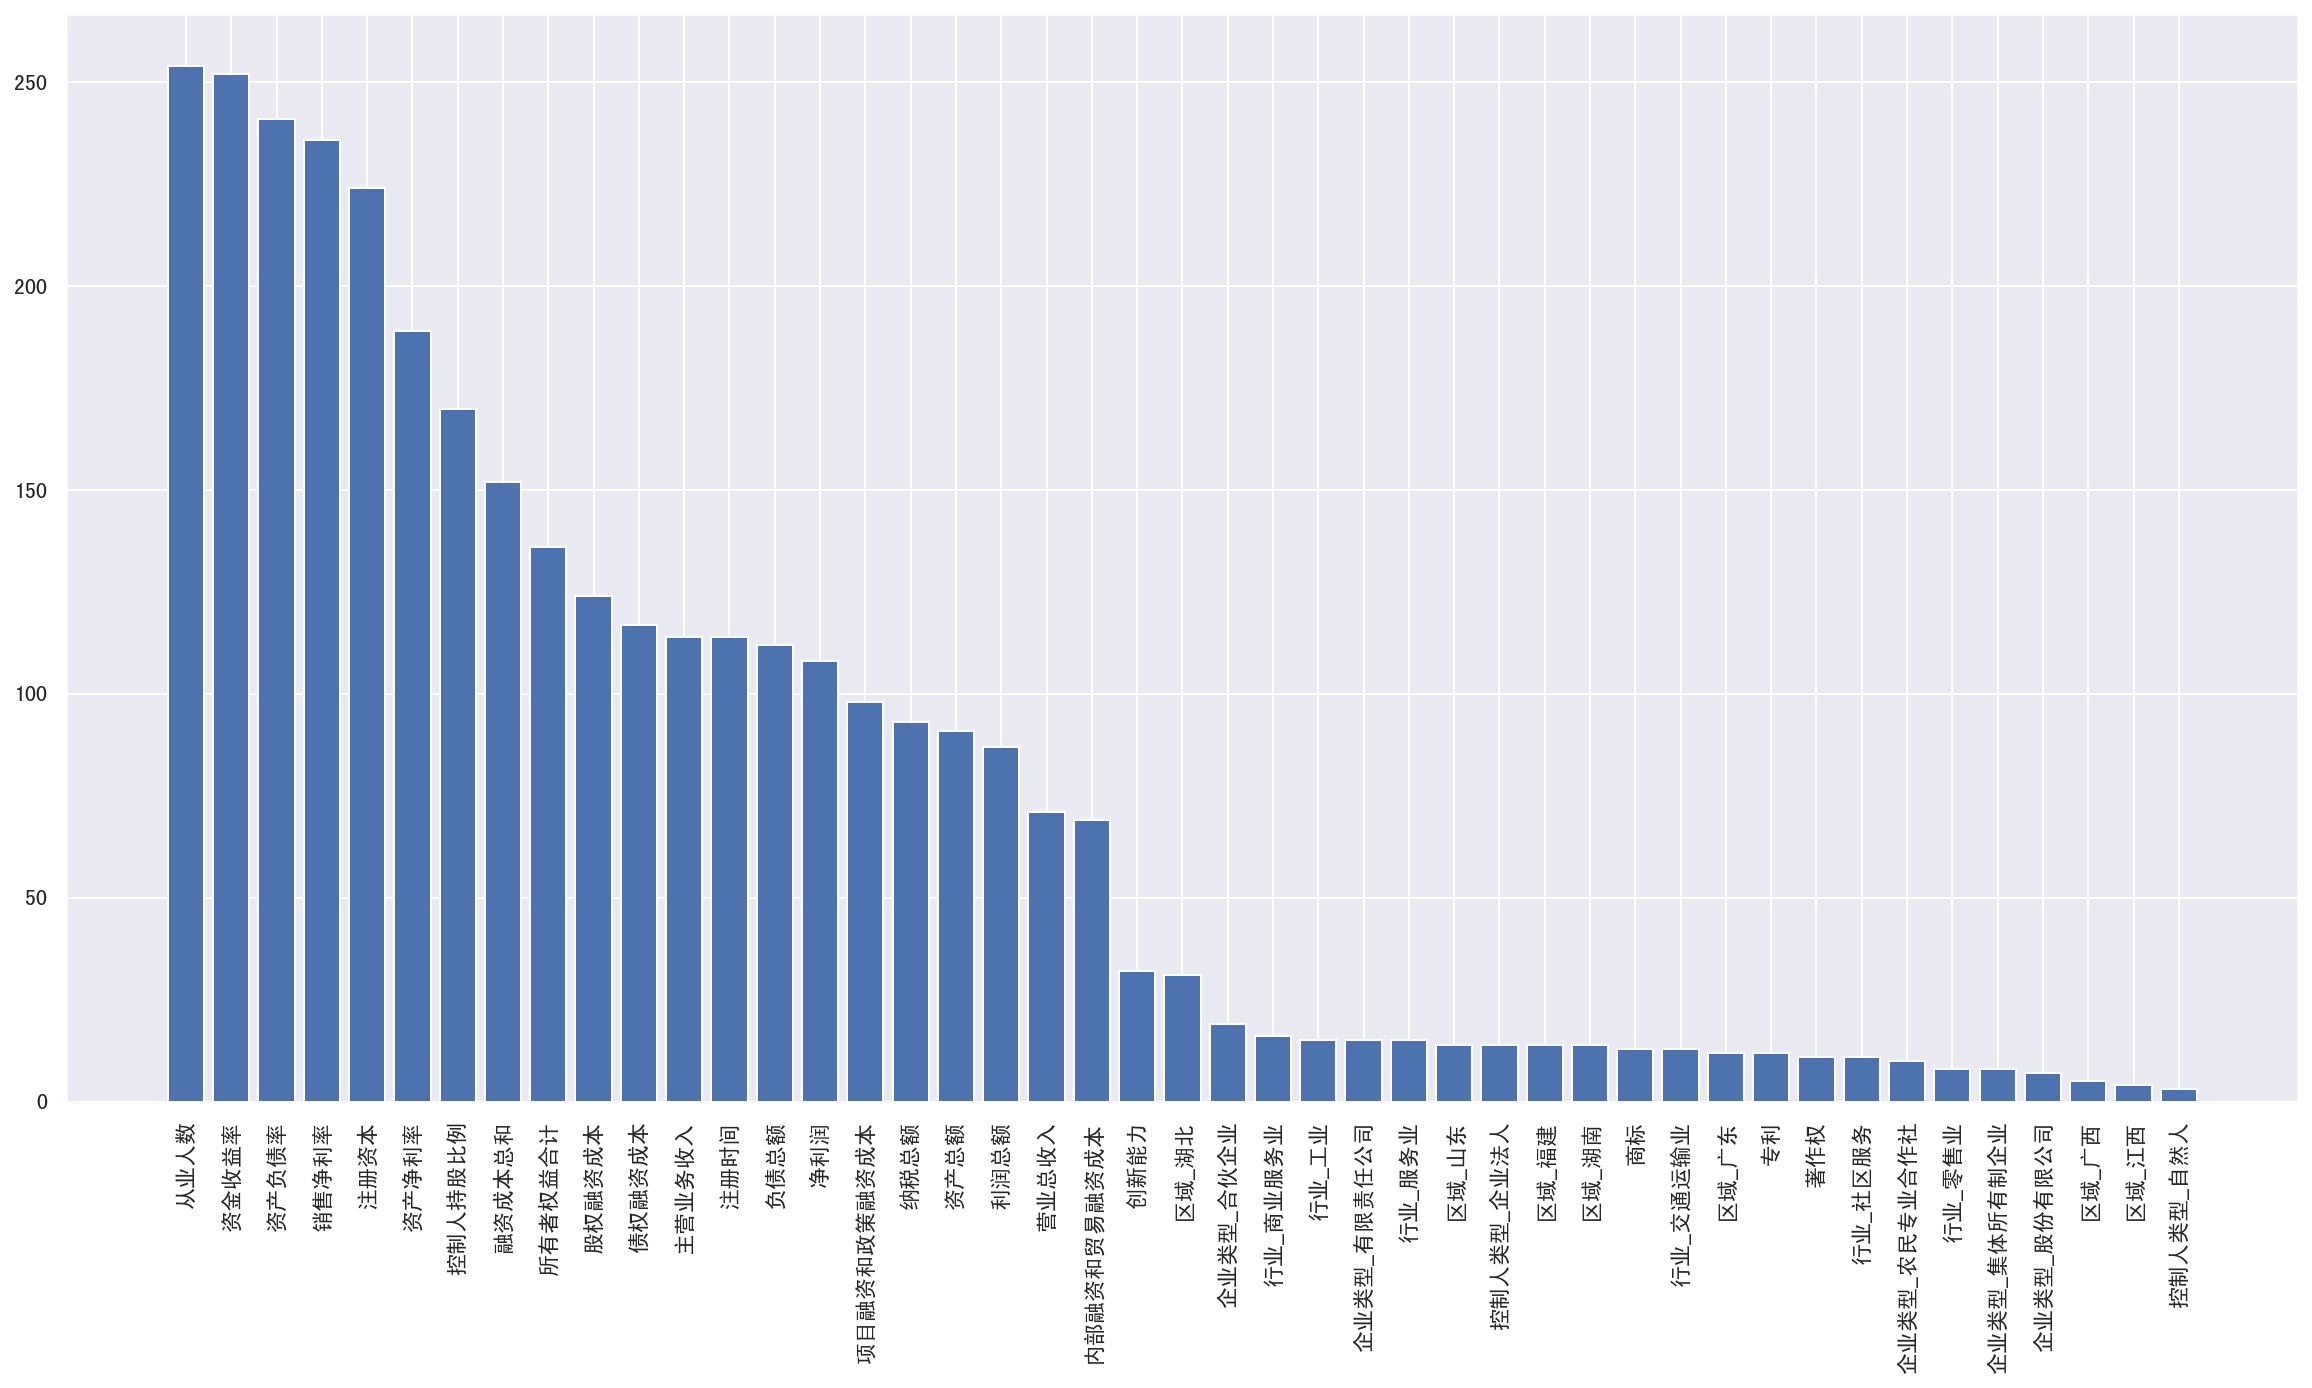

In [724]:
plot_feature_importance(gs_clf19.best_estimator_, train_feature.columns, yscale="linear")

## 特征处理

In [462]:
feature_df = pd.concat([base_df, knowledge_pre, money_pre, year_df.drop(columns="year").groupby("ID").mean()], axis=1, join_axes=[base_df.index])
feature_df = feature_df.loc[sel]
feature_df

,注册时间,注册资本,行业,区域,企业类型,控制人类型,控制人持股比例,专利,商标,著作权,...,融资成本总和,从业人数,资产总额,负债总额,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计
ID,,,,,,,,,,,,,,,,,,,,,
28,2007.0,2050.0,交通运输业,福建,农民专业合作社,企业法人,NaN,0.0,1.0,1.0,...,941.360000,527.666667,57400.000000,86783.333333,1.970733e+05,101871.333333,65955.333333,-19707.333333,0.000000,-29383.333333
230,2008.0,3360.0,服务业,广东,农民专业合作社,企业法人,1.00,0.0,0.0,0.0,...,985.152000,480.666667,76160.000000,94080.000000,1.004640e+05,65822.400000,39838.400000,-10046.400000,0.000000,-17920.000000
429,2005.0,9670.0,工业,江西,集体所有制企业,自然人,0.75,1.0,0.0,0.0,...,1928.584800,448.666667,357790.000000,435150.000000,1.051774e+06,603279.066667,264909.650000,-105177.366667,0.000000,-77360.000000
693,2011.0,8360.0,社区服务,山东,股份有限公司,企业法人,0.98,0.0,0.0,0.0,...,1638.560000,553.333333,91960.000000,79420.000000,3.867893e+05,160846.400000,131307.733333,-38678.933333,0.000000,12540.000000
727,2001.0,8720.0,零售业,江西,股份有限公司,企业法人,0.54,0.0,0.0,0.0,...,4672.873600,610.333333,398213.333333,584240.000000,1.132728e+06,509509.600000,237271.200000,-113272.800000,0.000000,-186026.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,2014.0,460.0,交通运输业,广西,农民专业合作社,企业法人,0.71,1.0,1.0,1.0,...,73.416000,635.000000,1840.000000,2453.333333,6.608667e+03,3289.000000,1582.400000,2010.200000,1818.533333,-613.333333
5978030,2004.0,1140.0,商业服务业,湖南,有限责任公司,自然人,0.95,0.0,0.0,0.0,...,306.318000,914.000000,33060.000000,36290.000000,1.039300e+05,82266.200000,30358.200000,-4533.400000,3397.200000,-3230.000000
5978031,2008.0,3290.0,交通运输业,湖南,集体所有制企业,自然人,0.63,0.0,1.0,1.0,...,395.633467,571.000000,103086.666667,148598.333333,2.226233e+05,110544.000000,46345.133333,23117.733333,58912.933333,-45511.666667


In [447]:
feature_df.columns

Index(['注册时间', '注册资本', '行业', '区域', '企业类型', '控制人类型', '控制人持股比例', '专利', '商标',
       '著作权', '创新能力', '债权融资成本', '股权融资成本', '内部融资和贸易融资成本', '项目融资和政策融资成本',
       '融资成本总和', '从业人数', '资产总额', '负债总额', '营业总收入', '主营业务收入', '利润总额', '净利润',
       '纳税总额', '所有者权益合计'],
      dtype='object')

### 交叉特征

In [463]:
numeric_feature = feature_df.drop(columns=["注册时间", "控制人持股比例", "行业", "区域", "企业类型", "控制人类型", "专利", "商标", "著作权", "创新能力"])
numeric_feature

,注册资本,债权融资成本,股权融资成本,内部融资和贸易融资成本,项目融资和政策融资成本,融资成本总和,从业人数,资产总额,负债总额,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计
ID,,,,,,,,,,,,,,,
28,2050.0,0.000000,508.400000,432.960,0.000,941.360000,527.666667,57400.000000,86783.333333,1.970733e+05,101871.333333,65955.333333,-19707.333333,0.000000,-29383.333333
230,3360.0,0.000000,40.320000,935.424,9.408,985.152000,480.666667,76160.000000,94080.000000,1.004640e+05,65822.400000,39838.400000,-10046.400000,0.000000,-17920.000000
429,9670.0,515.733333,1412.851467,0.000,0.000,1928.584800,448.666667,357790.000000,435150.000000,1.051774e+06,603279.066667,264909.650000,-105177.366667,0.000000,-77360.000000
693,8360.0,0.000000,428.032000,1103.520,107.008,1638.560000,553.333333,91960.000000,79420.000000,3.867893e+05,160846.400000,131307.733333,-38678.933333,0.000000,12540.000000
727,8720.0,0.000000,1769.113600,2903.760,0.000,4672.873600,610.333333,398213.333333,584240.000000,1.132728e+06,509509.600000,237271.200000,-113272.800000,0.000000,-186026.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,460.0,0.000000,0.000000,72.036,1.380,73.416000,635.000000,1840.000000,2453.333333,6.608667e+03,3289.000000,1582.400000,2010.200000,1818.533333,-613.333333
5978030,1140.0,0.000000,0.000000,237.006,69.312,306.318000,914.000000,33060.000000,36290.000000,1.039300e+05,82266.200000,30358.200000,-4533.400000,3397.200000,-3230.000000
5978031,3290.0,0.000000,342.335467,0.000,53.298,395.633467,571.000000,103086.666667,148598.333333,2.226233e+05,110544.000000,46345.133333,23117.733333,58912.933333,-45511.666667


In [464]:
cross_feature = pd.DataFrame()

In [465]:
c_columns = numeric_feature.columns
for column_i in c_columns:
    for column_j in c_columns.drop(column_i):
        cross_feature[column_i+'/'+column_j] = numeric_feature[column_i] / numeric_feature[column_j]

In [466]:
cross_feature

,注册资本/债权融资成本,注册资本/股权融资成本,注册资本/内部融资和贸易融资成本,注册资本/项目融资和政策融资成本,注册资本/融资成本总和,注册资本/从业人数,注册资本/资产总额,注册资本/负债总额,注册资本/营业总收入,注册资本/主营业务收入,...,所有者权益合计/项目融资和政策融资成本,所有者权益合计/融资成本总和,所有者权益合计/从业人数,所有者权益合计/资产总额,所有者权益合计/负债总额,所有者权益合计/营业总收入,所有者权益合计/主营业务收入,所有者权益合计/利润总额,所有者权益合计/净利润,所有者权益合计/纳税总额
ID,,,,,,,,,,,,,,,,,,,,,
28,inf,4.032258,4.734848,inf,2.177700,3.885028,0.035714,0.023622,0.010402,0.020123,...,-inf,-31.213705,-55.685407,-0.511905,-0.338583,-0.149098,-0.288436,-0.445504,1.490985,-inf
230,inf,83.333333,3.591954,357.142857,3.410641,6.990291,0.044118,0.035714,0.033445,0.051046,...,-1904.761905,-18.190086,-37.281553,-0.235294,-0.190476,-0.178372,-0.272248,-0.449817,1.783724,-inf
429,18.750000,6.844315,inf,inf,5.014039,21.552749,0.027027,0.022222,0.009194,0.016029,...,-inf,-40.112314,-172.421991,-0.216216,-0.177778,-0.073552,-0.128233,-0.292024,0.735519,-inf
693,inf,19.531250,7.575758,78.125000,5.102041,15.108434,0.090909,0.105263,0.021614,0.051975,...,117.187500,7.653061,22.662651,0.136364,0.157895,0.032421,0.077963,0.095501,-0.324207,inf
727,inf,4.929022,3.003003,inf,1.866089,14.287275,0.021898,0.014925,0.007698,0.017114,...,-inf,-39.809908,-304.795194,-0.467153,-0.318408,-0.164229,-0.365109,-0.784025,1.642289,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,inf,inf,6.385696,333.333333,6.265664,0.724409,0.250000,0.187500,0.069606,0.139860,...,-444.444444,-8.354219,-0.965879,-0.333333,-0.250000,-0.092807,-0.186480,-0.387597,-0.305111,-0.337268
5978030,inf,inf,4.810005,16.447368,3.721623,1.247265,0.034483,0.031414,0.010969,0.013857,...,-46.600877,-10.544597,-3.533917,-0.097701,-0.089005,-0.031079,-0.039263,-0.106396,0.712490,-0.950783
5978031,inf,9.610456,inf,61.728395,8.315778,5.761821,0.031915,0.022140,0.014778,0.029762,...,-853.909465,-115.034926,-79.705196,-0.441489,-0.306273,-0.204433,-0.411706,-0.982016,-1.968691,-0.772524


In [518]:
X_cross_train, X_cross_val, y_cross_train, y_cross_val = train_test_split(cross_feature, train_label, test_size=0.4, random_state=17)

In [801]:
cross_clf = XGBClassifier(colsample_bytree=0.6, subsample=0.8)
cross_clf.fit(X_cross_train, y_cross_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [802]:
pred_y_cross_train = cross_clf.predict(X_cross_train)
pred_y_cross_val = cross_clf.predict(X_cross_val)

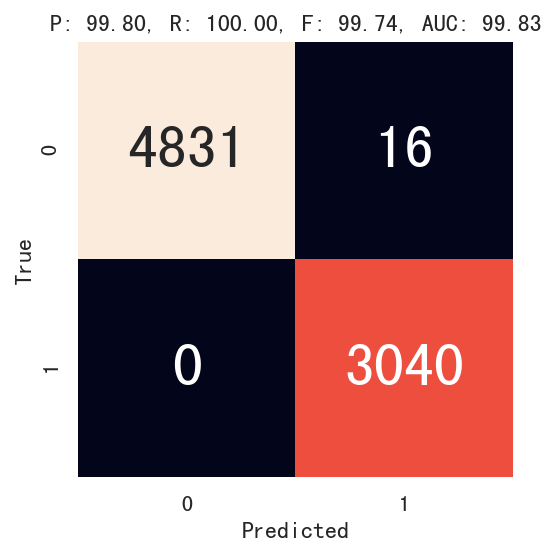

In [803]:
plot_metrics(y_cross_train, pred_y_cross_train)

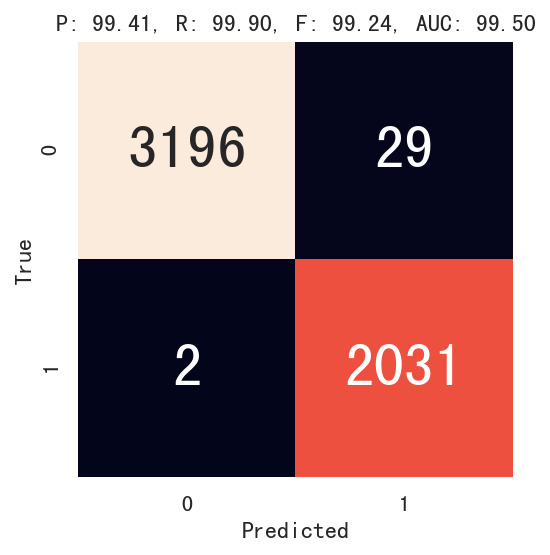

In [804]:
plot_metrics(y_cross_val, pred_y_cross_val)

In [805]:
cross_feature.columns[np.argsort(-cross_clf.feature_importances_)[:10]]

Index(['股权融资成本/纳税总额', '债权融资成本/纳税总额', '项目融资和政策融资成本/纳税总额', '内部融资和贸易融资成本/纳税总额',
       '净利润/营业总收入', '净利润/利润总额', '从业人数/净利润', '从业人数/股权融资成本', '净利润/债权融资成本',
       '从业人数/主营业务收入'],
      dtype='object')

### 考虑企业ID作为强特征

In [511]:
feature_withID = train_feature.copy()
feature_withID["ID"] = feature_withID.index

In [682]:
feature_withID

,注册时间,注册资本,控制人持股比例,行业_交通运输业,行业_商业服务业,行业_工业,行业_服务业,行业_社区服务,行业_零售业,区域_山东,...,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计,销售净利率,资产净利率,资产负债率,资金收益率,ID
ID,,,,,,,,,,,,,,,,,,,,,
28,2007.0,2050.0,NaN,1,0,0,0,0,0,0,...,101871.333333,65955.333333,-19707.333333,0.000000,-29383.333333,-0.100000,-0.343333,1.511905,0.670698,28
230,2008.0,3360.0,1.00,0,0,0,1,0,0,0,...,65822.400000,39838.400000,-10046.400000,0.000000,-17920.000000,-0.100000,-0.131912,1.235294,0.560625,230
429,2005.0,9670.0,0.75,0,0,1,0,0,0,0,...,603279.066667,264909.650000,-105177.366667,0.000000,-77360.000000,-0.100000,-0.293964,1.216216,1.359583,429
693,2011.0,8360.0,0.98,0,0,0,0,1,0,1,...,160846.400000,131307.733333,-38678.933333,0.000000,12540.000000,-0.100000,-0.420606,0.863636,-3.084444,693
727,2001.0,8720.0,0.54,0,0,0,0,0,1,0,...,509509.600000,237271.200000,-113272.800000,0.000000,-186026.666667,-0.100000,-0.284453,1.467153,0.608906,727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,2014.0,460.0,0.71,1,0,0,0,0,0,0,...,3289.000000,1582.400000,2010.200000,1818.533333,-613.333333,0.304176,1.092500,1.333333,-3.277500,5978029
5978030,2004.0,1140.0,0.95,0,1,0,0,0,0,0,...,82266.200000,30358.200000,-4533.400000,3397.200000,-3230.000000,-0.043620,-0.137126,1.097701,1.403529,5978030
5978031,2008.0,3290.0,0.63,1,0,0,0,0,0,0,...,110544.000000,46345.133333,23117.733333,58912.933333,-45511.666667,0.103842,0.224255,1.441489,-0.507952,5978031


In [683]:
X_train_withID, X_val_withID, y_train_withID, y_val_withID = train_test_split(feature_withID, train_label, test_size=0.4, random_state=17)

In [684]:
withid_clf = XGBClassifier(colsample_bytree=0.5, subsample=0.8)
withid_clf.fit(X_train_withID, y_train_withID)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [685]:
pred_y_train_withID = withid_clf.predict(X_train_withID)
pred_y_val_withID = withid_clf.predict(X_val_withID)

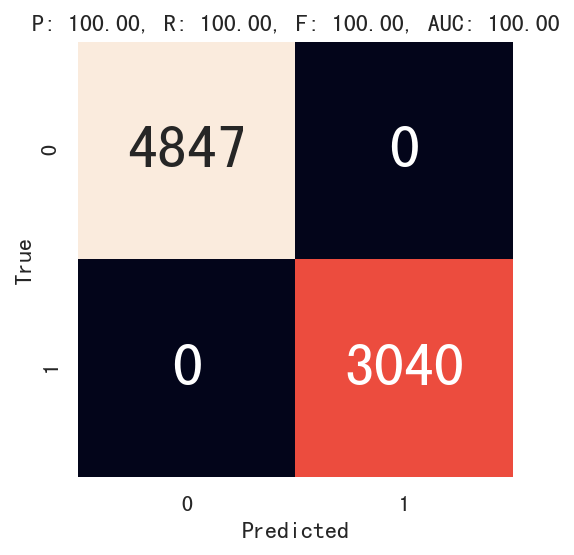

In [727]:
plot_metrics(y_train_withID, pred_y_train_withID)

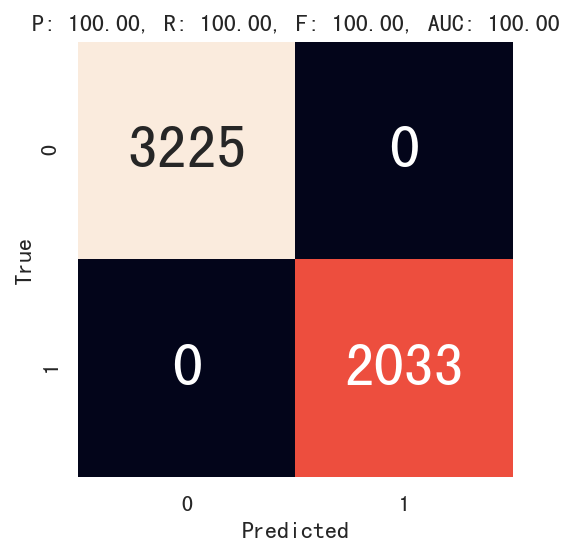

In [728]:
plot_metrics(y_val_withID, pred_y_val_withID)

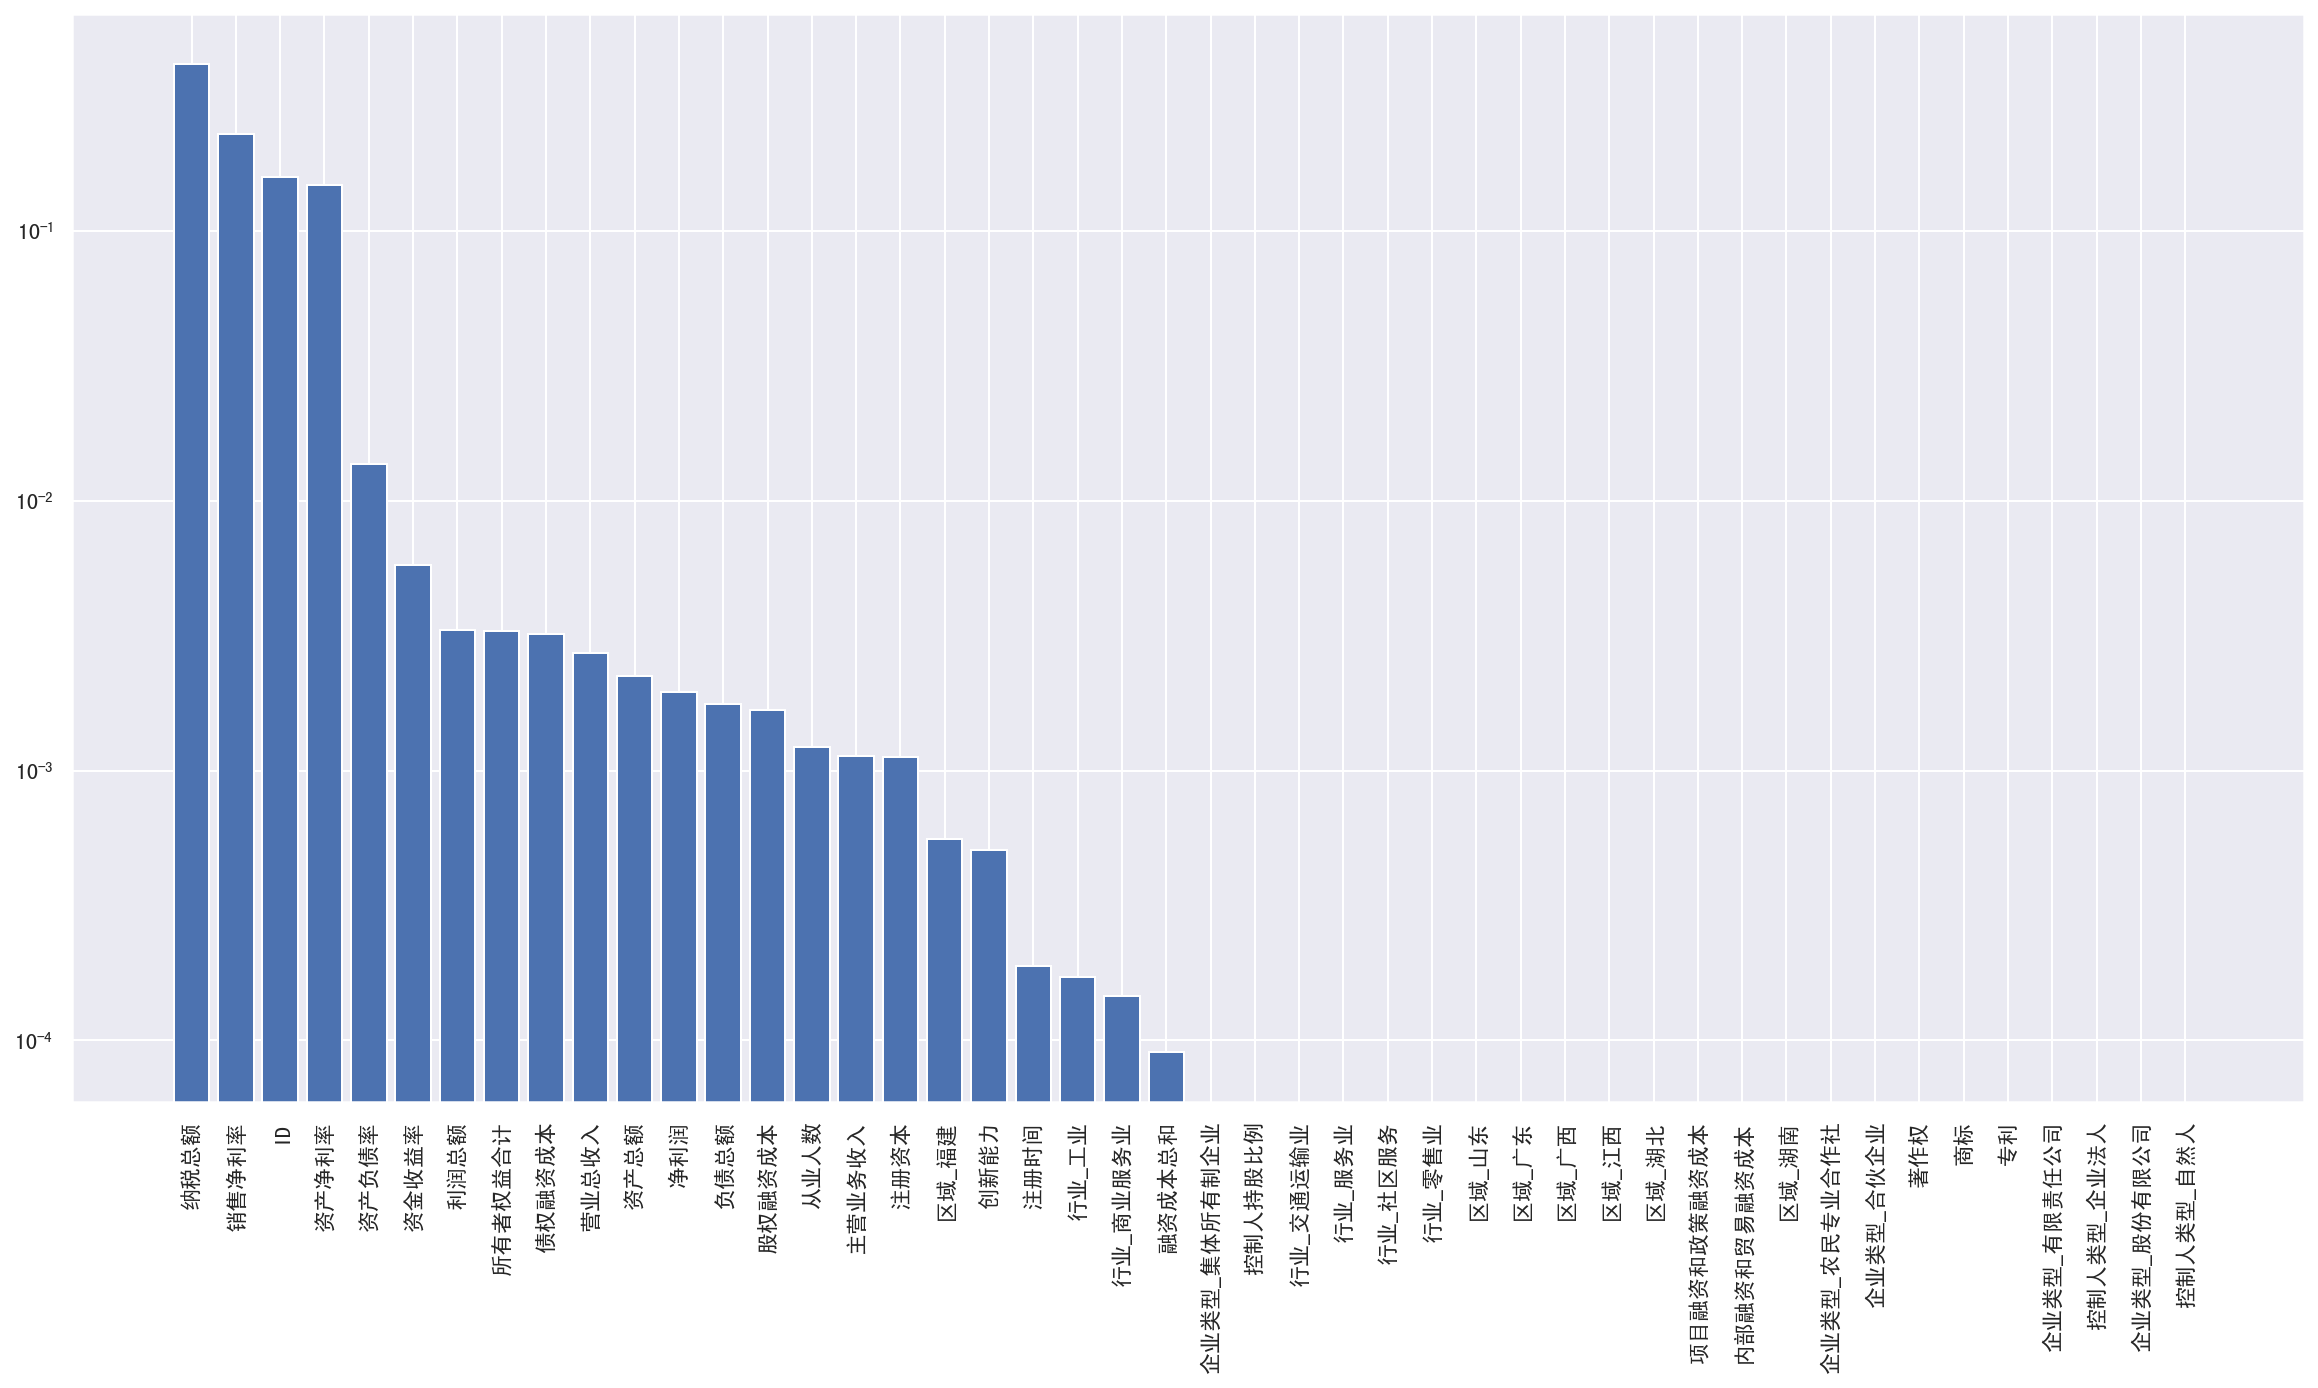

In [688]:
plot_feature_importance(withid_clf, feature_withID.columns)

### 使用企业ID划分NA数据

In [613]:
true_label = flag.copy()
true_label.loc[:5970001] = 1
true_label.loc[5970001:] = -1
true_label = true_label.to_numpy(dtype=int)

In [622]:
X_train_, X_val_, y_train_, y_val_ = train_test_split(union_feature, true_label, test_size=0.4, random_state=17)

In [635]:
clf_ = XGBClassifier(subsample=0.8, colsample_bytree=0.5)
clf_.fit(X_train_, y_train_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [636]:
pred_y_train_ = clf_.predict(X_train_)
pred_y_val_ = clf_.predict(X_val_)

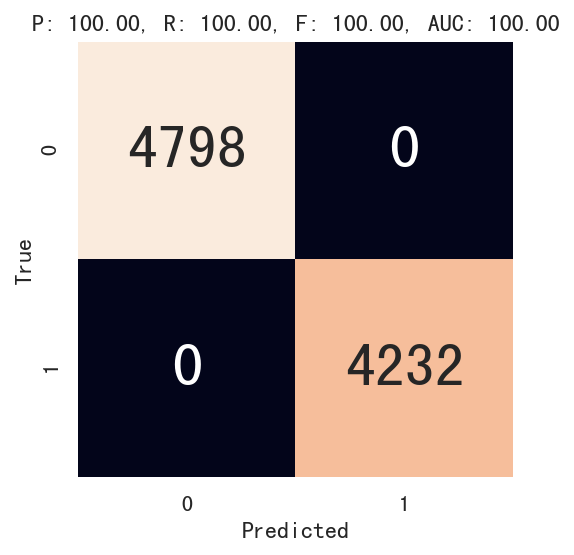

In [729]:
plot_metrics(y_train_, pred_y_train_)

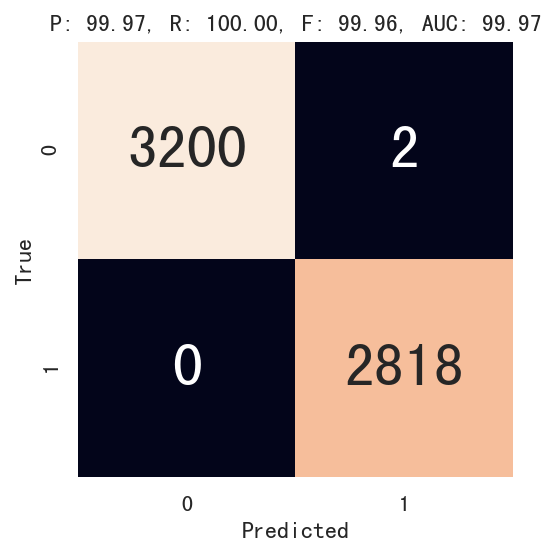

In [730]:
plot_metrics(y_val_, pred_y_val_)

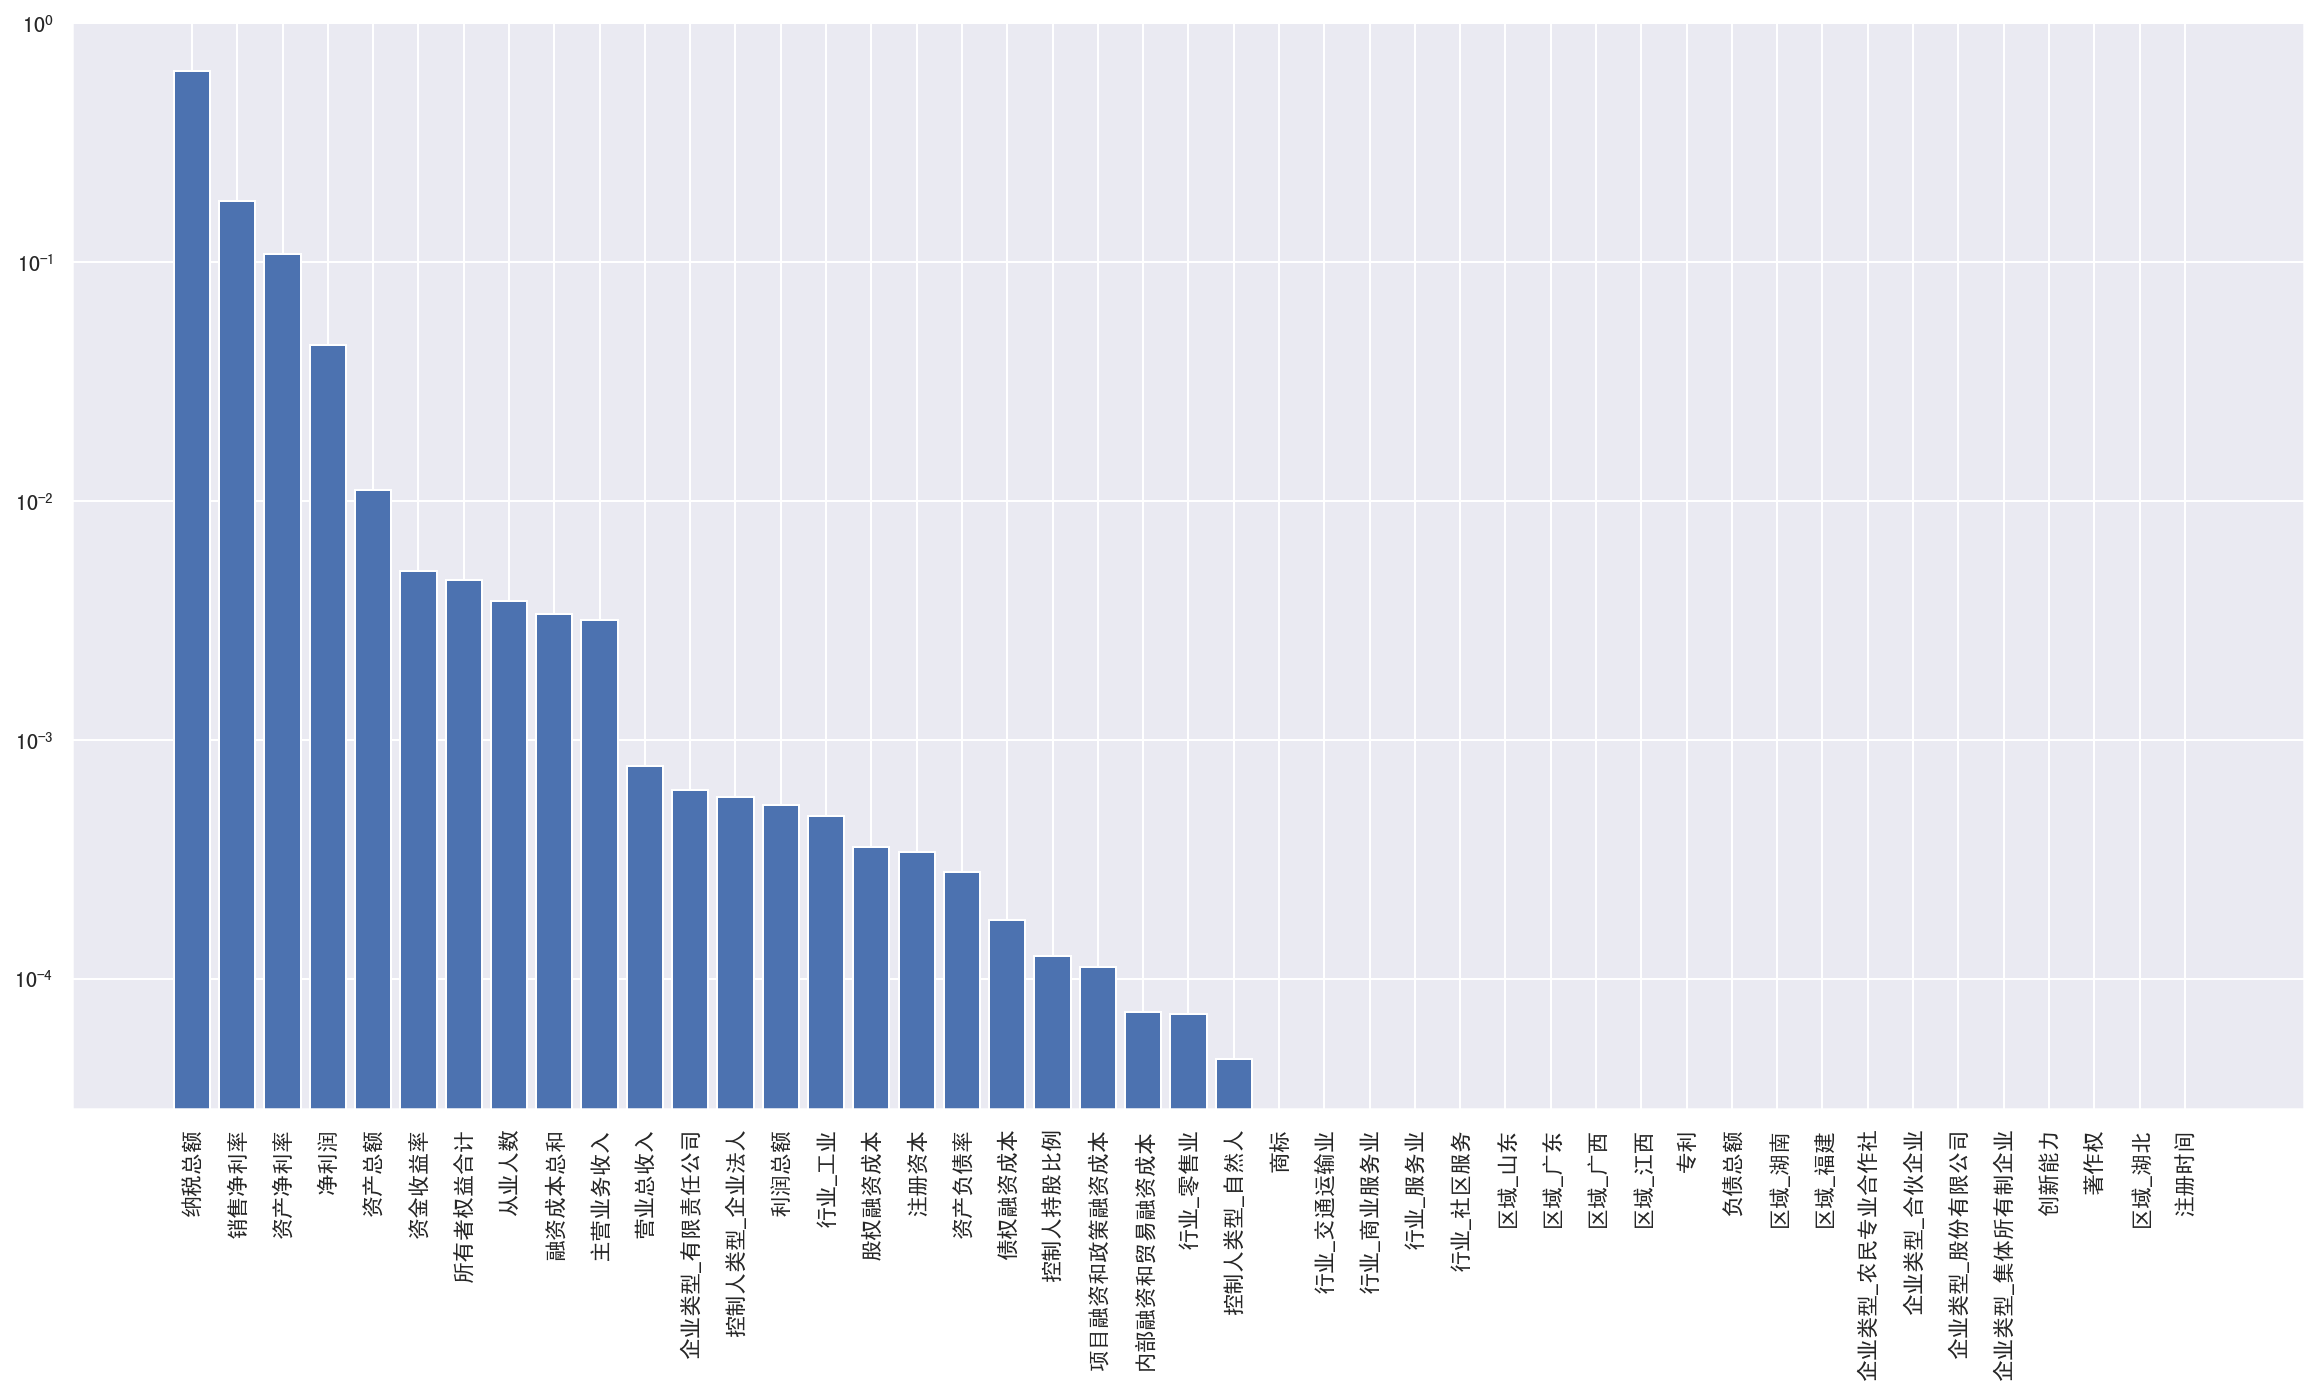

In [639]:
plot_feature_importance(clf_, union_feature.columns)

### 偏离值特征

In [737]:
feature_df

,注册时间,注册资本,行业,区域,企业类型,控制人类型,控制人持股比例,专利,商标,著作权,...,融资成本总和,从业人数,资产总额,负债总额,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计
ID,,,,,,,,,,,,,,,,,,,,,
28,2007.0,2050.0,交通运输业,福建,农民专业合作社,企业法人,NaN,0.0,1.0,1.0,...,941.360000,527.666667,57400.000000,86783.333333,1.970733e+05,101871.333333,65955.333333,-19707.333333,0.000000,-29383.333333
230,2008.0,3360.0,服务业,广东,农民专业合作社,企业法人,1.00,0.0,0.0,0.0,...,985.152000,480.666667,76160.000000,94080.000000,1.004640e+05,65822.400000,39838.400000,-10046.400000,0.000000,-17920.000000
429,2005.0,9670.0,工业,江西,集体所有制企业,自然人,0.75,1.0,0.0,0.0,...,1928.584800,448.666667,357790.000000,435150.000000,1.051774e+06,603279.066667,264909.650000,-105177.366667,0.000000,-77360.000000
693,2011.0,8360.0,社区服务,山东,股份有限公司,企业法人,0.98,0.0,0.0,0.0,...,1638.560000,553.333333,91960.000000,79420.000000,3.867893e+05,160846.400000,131307.733333,-38678.933333,0.000000,12540.000000
727,2001.0,8720.0,零售业,江西,股份有限公司,企业法人,0.54,0.0,0.0,0.0,...,4672.873600,610.333333,398213.333333,584240.000000,1.132728e+06,509509.600000,237271.200000,-113272.800000,0.000000,-186026.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,2014.0,460.0,交通运输业,广西,农民专业合作社,企业法人,0.71,1.0,1.0,1.0,...,73.416000,635.000000,1840.000000,2453.333333,6.608667e+03,3289.000000,1582.400000,2010.200000,1818.533333,-613.333333
5978030,2004.0,1140.0,商业服务业,湖南,有限责任公司,自然人,0.95,0.0,0.0,0.0,...,306.318000,914.000000,33060.000000,36290.000000,1.039300e+05,82266.200000,30358.200000,-4533.400000,3397.200000,-3230.000000
5978031,2008.0,3290.0,交通运输业,湖南,集体所有制企业,自然人,0.63,0.0,1.0,1.0,...,395.633467,571.000000,103086.666667,148598.333333,2.226233e+05,110544.000000,46345.133333,23117.733333,58912.933333,-45511.666667


In [739]:
def scale_classify(row):
    if row["行业"] == "交通运输业":
        x, y = row["从业人数"], row["营业总收入"]
        i = ((x>=20) + (y>=100) + (x>=300) + (y>=3000) + (x>=1000) + (y>=30000)) // 2
    elif row["行业"] == "工业":
        x, y = row["从业人数"], row["营业总收入"]
        i = ((x>=20) + (y>=300) + (x>=300) + (y>=2000) + (x>=1000) + (y>=40000)) // 2
    elif row["行业"] == "零售业":
        x, y = row["从业人数"], row["营业总收入"]
        i = ((x>=10) + (y>=100) + (x>=50) + (y>=500) + (x>=300) + (y>=20000)) // 2
    elif row["行业"] in ["服务业", "商业服务业", "社区服务"]:
        x, y = row["从业人数"], row["资产总额"]
        i = ((x>=10) + (y>=100) + (x>=100) + (y>=8000) + (x>=300) + (y>=120000)) // 2
    else:
        x = row["从业人数"]
        i = (x>=10) + (x>=100) + (x>=300)
    
    scales = ["微型", "小型", "中型", "大型"]
    return scales[i]

In [740]:
feature_df["企业规模"] = feature_df.apply(scale_classify, axis=1)

In [775]:
class_columns = ["行业", "区域", "企业类型", "控制人类型", "企业规模"]
numeric_columns = feature_df.columns.drop(class_columns)
numeric_columns                             

Index(['注册时间', '注册资本', '控制人持股比例', '专利', '商标', '著作权', '创新能力', '债权融资成本',
       '股权融资成本', '内部融资和贸易融资成本', '项目融资和政策融资成本', '融资成本总和', '从业人数', '资产总额',
       '负债总额', '营业总收入', '主营业务收入', '利润总额', '净利润', '纳税总额', '所有者权益合计'],
      dtype='object')

In [790]:
class_df = {}
class_df["行业"] = feature_df.groupby("行业").agg([np.mean, sum, min, max])
class_df["区域"] = feature_df.groupby("区域").agg([np.mean, sum, min, max])
class_df["企业类型"] = feature_df.groupby("企业类型").agg([np.mean, sum, min, max])
class_df["控制人类型"] = feature_df.groupby("控制人类型").agg([np.mean, sum, min, max])
class_df["企业规模"] = feature_df.groupby("企业规模").agg([np.mean, sum, min, max])

In [807]:
deviation_df = pd.DataFrame()
for coli in class_columns:
    tmp = pd.merge(feature_df, class_df[coli], on=coli, how="left")
    for colj in numeric_columns:
        deviation_df[colj + "_" + coli + "_均值偏差"] = tmp[colj] - tmp[(colj, "mean")]
        deviation_df[colj + "_" + coli + "_总和偏差"] = tmp[colj] / tmp[(colj, "sum")]
        deviation_df[colj + "_" + coli + "_最小值偏差"] = tmp[colj] - tmp[(colj, "min")]
        deviation_df[colj + "_" + coli + "_最大值偏差"] = tmp[colj] - tmp[(colj, "max")]

In [816]:
deviation_df.set_index(feature_df.index, inplace=True)
deviation_df

,注册时间_行业_均值偏差,注册时间_行业_总和偏差,注册时间_行业_最小值偏差,注册时间_行业_最大值偏差,注册资本_行业_均值偏差,注册资本_行业_总和偏差,注册资本_行业_最小值偏差,注册资本_行业_最大值偏差,控制人持股比例_行业_均值偏差,控制人持股比例_行业_总和偏差,...,净利润_企业规模_最小值偏差,净利润_企业规模_最大值偏差,纳税总额_企业规模_均值偏差,纳税总额_企业规模_总和偏差,纳税总额_企业规模_最小值偏差,纳税总额_企业规模_最大值偏差,所有者权益合计_企业规模_均值偏差,所有者权益合计_企业规模_总和偏差,所有者权益合计_企业规模_最小值偏差,所有者权益合计_企业规模_最大值偏差
ID,,,,,,,,,,,,,,,,,,,,,
28,-0.118525,0.000467,7.0,-7.0,-2991.170709,0.000190,1940.0,-7950.0,NaN,NaN,...,264300.500000,-643248.666667,-52958.633259,0.000000,0.000000,-1.257824e+06,-9467.542274,0.000172,496596.666667,-276553.333333
230,1.147867,0.000474,8.0,-6.0,-1731.806604,0.000311,3260.0,-6640.0,0.246263,0.000625,...,273961.433333,-633587.733333,-52958.633259,0.000000,0.000000,-1.257824e+06,1995.791059,0.000105,508060.000000,-265090.000000
429,-1.816565,0.000468,5.0,-9.0,4715.205033,0.000909,9570.0,-330.0,-0.005389,0.000463,...,178830.466667,-728718.700000,-52958.633259,0.000000,0.000000,-1.257824e+06,-57444.208941,0.000453,448620.000000,-324530.000000
693,4.085434,0.000468,11.0,-3.0,3343.576097,0.000778,8260.0,-1640.0,0.223041,0.000604,...,245328.900000,-662220.266667,-52958.633259,0.000000,0.000000,-1.257824e+06,32455.791059,-0.000073,538520.000000,-234630.000000
727,-5.902954,0.000467,1.0,-13.0,3742.553789,0.000819,8620.0,-1280.0,-0.214075,0.000334,...,116074.266667,-968226.133333,-107337.502692,0.000000,0.000000,-1.375243e+06,-144587.706381,0.001002,330223.333333,-507420.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,6.881475,0.000468,14.0,0.0,-4581.170709,0.000043,350.0,-9540.0,-0.044693,0.000441,...,286018.033333,-621531.133333,-51140.099926,0.000004,1818.533333,-1.256005e+06,19302.457726,0.000004,525366.666667,-247783.333333
5978030,-2.784323,0.000452,4.0,-10.0,-3818.022624,0.000104,1040.0,-8860.0,0.189421,0.000565,...,279474.433333,-628074.733333,-49561.433259,0.000007,3397.200000,-1.254427e+06,16685.791059,0.000019,522750.000000,-250400.000000
5978031,0.881475,0.000467,8.0,-6.0,-1751.170709,0.000304,3180.0,-6710.0,-0.124693,0.000391,...,307125.566667,-600423.600000,5954.300074,0.000130,58912.933333,-1.198911e+06,-25595.875607,0.000266,480468.333333,-292681.666667


In [809]:
X_train_dev, X_val_dev, y_train_dev, y_val_dev = train_test_split(deviation_df, train_label, test_size=0.4, random_state=17)

In [810]:
dev_clf = XGBClassifier(colsample_bytree=0.6, subsample=0.8)
dev_clf.fit(X_train_dev, y_train_dev)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [811]:
pred_y_train_dev = dev_clf.predict(X_train_dev)
pred_y_val_dev = dev_clf.predict(X_val_dev)

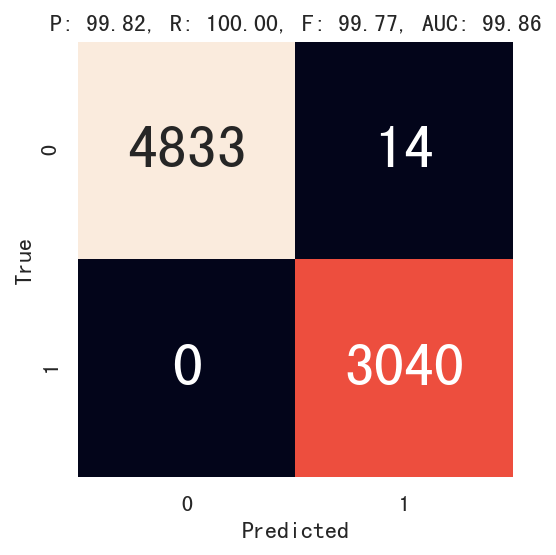

In [812]:
plot_metrics(y_train_dev, pred_y_train_dev)

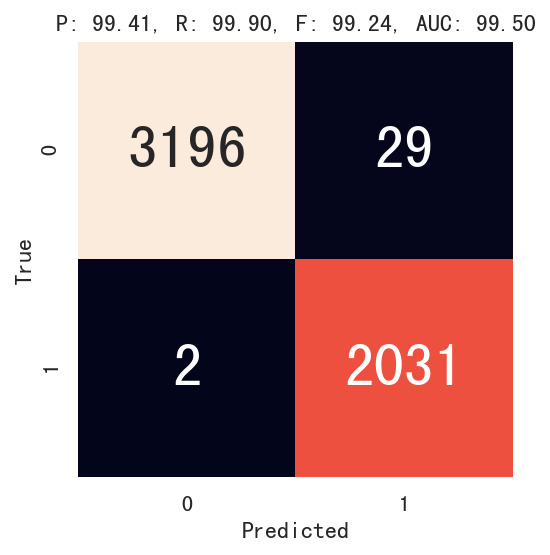

In [813]:
plot_metrics(y_val_dev, pred_y_val_dev)

In [815]:
deviation_df.columns[np.argsort(-dev_clf.feature_importances_)[:20]]

Index(['纳税总额_企业规模_总和偏差', '纳税总额_企业规模_最小值偏差', '纳税总额_区域_最小值偏差', '纳税总额_行业_总和偏差',
       '纳税总额_控制人类型_总和偏差', '纳税总额_区域_总和偏差', '所有者权益合计_控制人类型_总和偏差',
       '股权融资成本_行业_总和偏差', '负债总额_企业规模_总和偏差', '所有者权益合计_企业类型_最小值偏差',
       '从业人数_行业_均值偏差', '所有者权益合计_控制人类型_最大值偏差', '项目融资和政策融资成本_企业规模_总和偏差',
       '负债总额_企业类型_均值偏差', '股权融资成本_行业_最小值偏差', '净利润_行业_总和偏差', '净利润_区域_均值偏差',
       '资产总额_企业规模_最大值偏差', '资产总额_区域_总和偏差', '纳税总额_企业类型_最小值偏差'],
      dtype='object')

### 使用有效的生成特征

In [824]:
cross_columns = cross_feature.columns[np.argsort(-cross_clf.feature_importances_)[:10]]
cross_valid = cross_feature[cross_columns]
cross_valid.drop(columns="净利润/营业总收入", inplace=True)
cross_valid

,股权融资成本/纳税总额,债权融资成本/纳税总额,项目融资和政策融资成本/纳税总额,内部融资和贸易融资成本/纳税总额,净利润/利润总额,从业人数/净利润,从业人数/股权融资成本,净利润/债权融资成本,从业人数/主营业务收入
ID,,,,,,,,,
28,inf,NaN,NaN,inf,-0.298798,-0.026775,1.037897,-inf,0.005180
230,inf,NaN,inf,inf,-0.252179,-0.047845,11.921296,-inf,0.007302
429,inf,inf,NaN,NaN,-0.397031,-0.004266,0.317561,-203.937500,0.000744
693,inf,NaN,inf,inf,-0.294567,-0.014306,1.292738,-inf,0.003440
727,inf,NaN,NaN,inf,-0.477398,-0.005388,0.344994,-inf,0.001198
...,...,...,...,...,...,...,...,...,...
5978029,0.000000,0.000000,0.000759,0.039612,1.270349,0.315889,inf,inf,0.193068
5978030,0.000000,0.000000,0.020403,0.069765,-0.149330,-0.201615,inf,-inf,0.011110
5978031,0.005811,0.000000,0.000905,0.000000,0.498817,0.024700,1.667955,inf,0.005165


净利润/营业总收入 即为销售净利率，删除这个重复特征

In [825]:
dev_columns = deviation_df.columns[np.argsort(-dev_clf.feature_importances_)[:20]]
dev_valid = deviation_df[dev_columns]
dev_valid

,纳税总额_企业规模_总和偏差,纳税总额_企业规模_最小值偏差,纳税总额_区域_最小值偏差,纳税总额_行业_总和偏差,纳税总额_控制人类型_总和偏差,纳税总额_区域_总和偏差,所有者权益合计_控制人类型_总和偏差,股权融资成本_行业_总和偏差,负债总额_企业规模_总和偏差,所有者权益合计_企业类型_最小值偏差,从业人数_行业_均值偏差,所有者权益合计_控制人类型_最大值偏差,项目融资和政策融资成本_企业规模_总和偏差,负债总额_企业类型_均值偏差,股权融资成本_行业_最小值偏差,净利润_行业_总和偏差,净利润_区域_均值偏差,资产总额_企业规模_最大值偏差,资产总额_区域_总和偏差,纳税总额_企业类型_最小值偏差
ID,,,,,,,,,,,,,,,,,,,,
28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000174,0.001162,0.000082,477546.666667,21.939023,-295363.333333,0.000000,-74655.534148,508.400000,-0.000557,-37777.949116,-685850.000000,0.000229,0.000000
230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000106,0.000091,0.000089,489010.000000,-26.971364,-283900.000000,0.000024,-67358.867481,40.320000,-0.000241,-28228.130844,-667090.000000,0.000303,0.000000
429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000418,0.002865,0.000412,371480.000000,-65.266097,-398753.333333,0.000000,272283.665622,1412.851467,-0.002770,-120438.728621,-385460.000000,0.001395,0.000000
693,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000074,0.000915,0.000075,528790.000000,48.137246,-253440.000000,0.000270,-88298.354725,428.032000,-0.001015,-58687.607048,-651290.000000,0.000374,0.000000
727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001103,0.003918,0.000538,330223.333333,104.146982,-452006.666667,0.000000,416521.645275,1769.113600,-0.002876,-128534.161955,-370586.666667,0.001552,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,0.000004,1818.533333,1818.533333,0.000013,0.000004,0.000013,0.000004,0.000000,0.000002,506316.666667,129.272356,-266593.333333,0.000003,-158985.534148,0.000000,0.000057,-17079.164257,-741410.000000,0.000007,1818.533333
5978030,0.000007,3397.200000,3397.200000,0.000021,0.000007,0.000027,0.000017,0.000000,0.000034,522750.000000,401.651515,-324623.333333,0.000175,-122254.452969,0.000000,-0.000113,-21288.454042,-710190.000000,0.000133,3397.200000
5978031,0.000130,58912.933333,58912.933333,0.000407,0.000128,0.000461,0.000246,0.000782,0.000141,403328.333333,65.272356,-366905.000000,0.000135,-14268.001045,342.335467,0.000653,6362.679291,-640163.333333,0.000416,58912.933333


In [826]:
all_feature = pd.concat([train_feature, cross_valid, dev_valid], axis=1)
all_feature

,注册时间,注册资本,控制人持股比例,行业_交通运输业,行业_商业服务业,行业_工业,行业_服务业,行业_社区服务,行业_零售业,区域_山东,...,从业人数_行业_均值偏差,所有者权益合计_控制人类型_最大值偏差,项目融资和政策融资成本_企业规模_总和偏差,负债总额_企业类型_均值偏差,股权融资成本_行业_最小值偏差,净利润_行业_总和偏差,净利润_区域_均值偏差,资产总额_企业规模_最大值偏差,资产总额_区域_总和偏差,纳税总额_企业类型_最小值偏差
ID,,,,,,,,,,,,,,,,,,,,,
28,2007.0,2050.0,NaN,1,0,0,0,0,0,0,...,21.939023,-295363.333333,0.000000,-74655.534148,508.400000,-0.000557,-37777.949116,-685850.000000,0.000229,0.000000
230,2008.0,3360.0,1.00,0,0,0,1,0,0,0,...,-26.971364,-283900.000000,0.000024,-67358.867481,40.320000,-0.000241,-28228.130844,-667090.000000,0.000303,0.000000
429,2005.0,9670.0,0.75,0,0,1,0,0,0,0,...,-65.266097,-398753.333333,0.000000,272283.665622,1412.851467,-0.002770,-120438.728621,-385460.000000,0.001395,0.000000
693,2011.0,8360.0,0.98,0,0,0,0,1,0,1,...,48.137246,-253440.000000,0.000270,-88298.354725,428.032000,-0.001015,-58687.607048,-651290.000000,0.000374,0.000000
727,2001.0,8720.0,0.54,0,0,0,0,0,1,0,...,104.146982,-452006.666667,0.000000,416521.645275,1769.113600,-0.002876,-128534.161955,-370586.666667,0.001552,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,2014.0,460.0,0.71,1,0,0,0,0,0,0,...,129.272356,-266593.333333,0.000003,-158985.534148,0.000000,0.000057,-17079.164257,-741410.000000,0.000007,1818.533333
5978030,2004.0,1140.0,0.95,0,1,0,0,0,0,0,...,401.651515,-324623.333333,0.000175,-122254.452969,0.000000,-0.000113,-21288.454042,-710190.000000,0.000133,3397.200000
5978031,2008.0,3290.0,0.63,1,0,0,0,0,0,0,...,65.272356,-366905.000000,0.000135,-14268.001045,342.335467,0.000653,6362.679291,-640163.333333,0.000416,58912.933333


In [827]:
X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(all_feature, train_label, test_size=0.4, random_state=17)

In [847]:
all_clf = XGBClassifier(colsample_bytree=0.6, subsample=0.8)
all_clf.fit(X_train_all, y_train_all)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [848]:
pred_y_train_all = all_clf.predict(X_train_all)
pred_y_val_all = all_clf.predict(X_val_all)

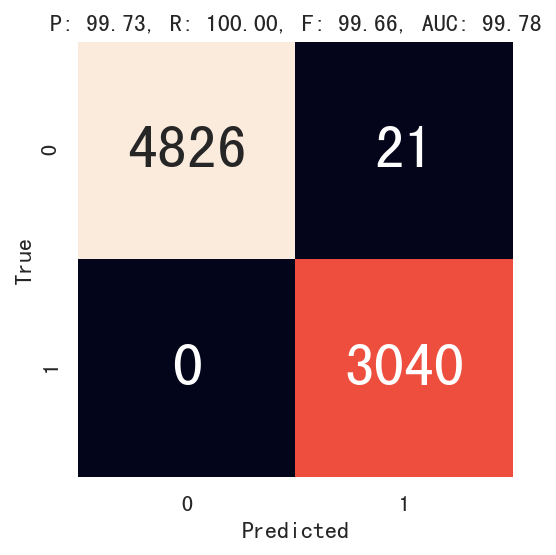

In [849]:
plot_metrics(y_train_all, pred_y_train_all)

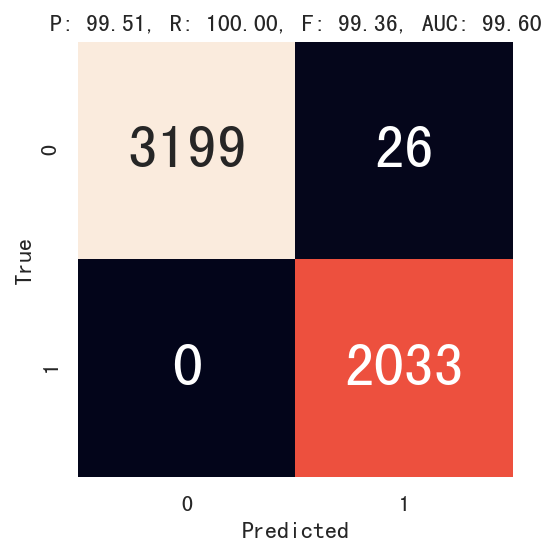

In [850]:
plot_metrics(y_val_all, pred_y_val_all)

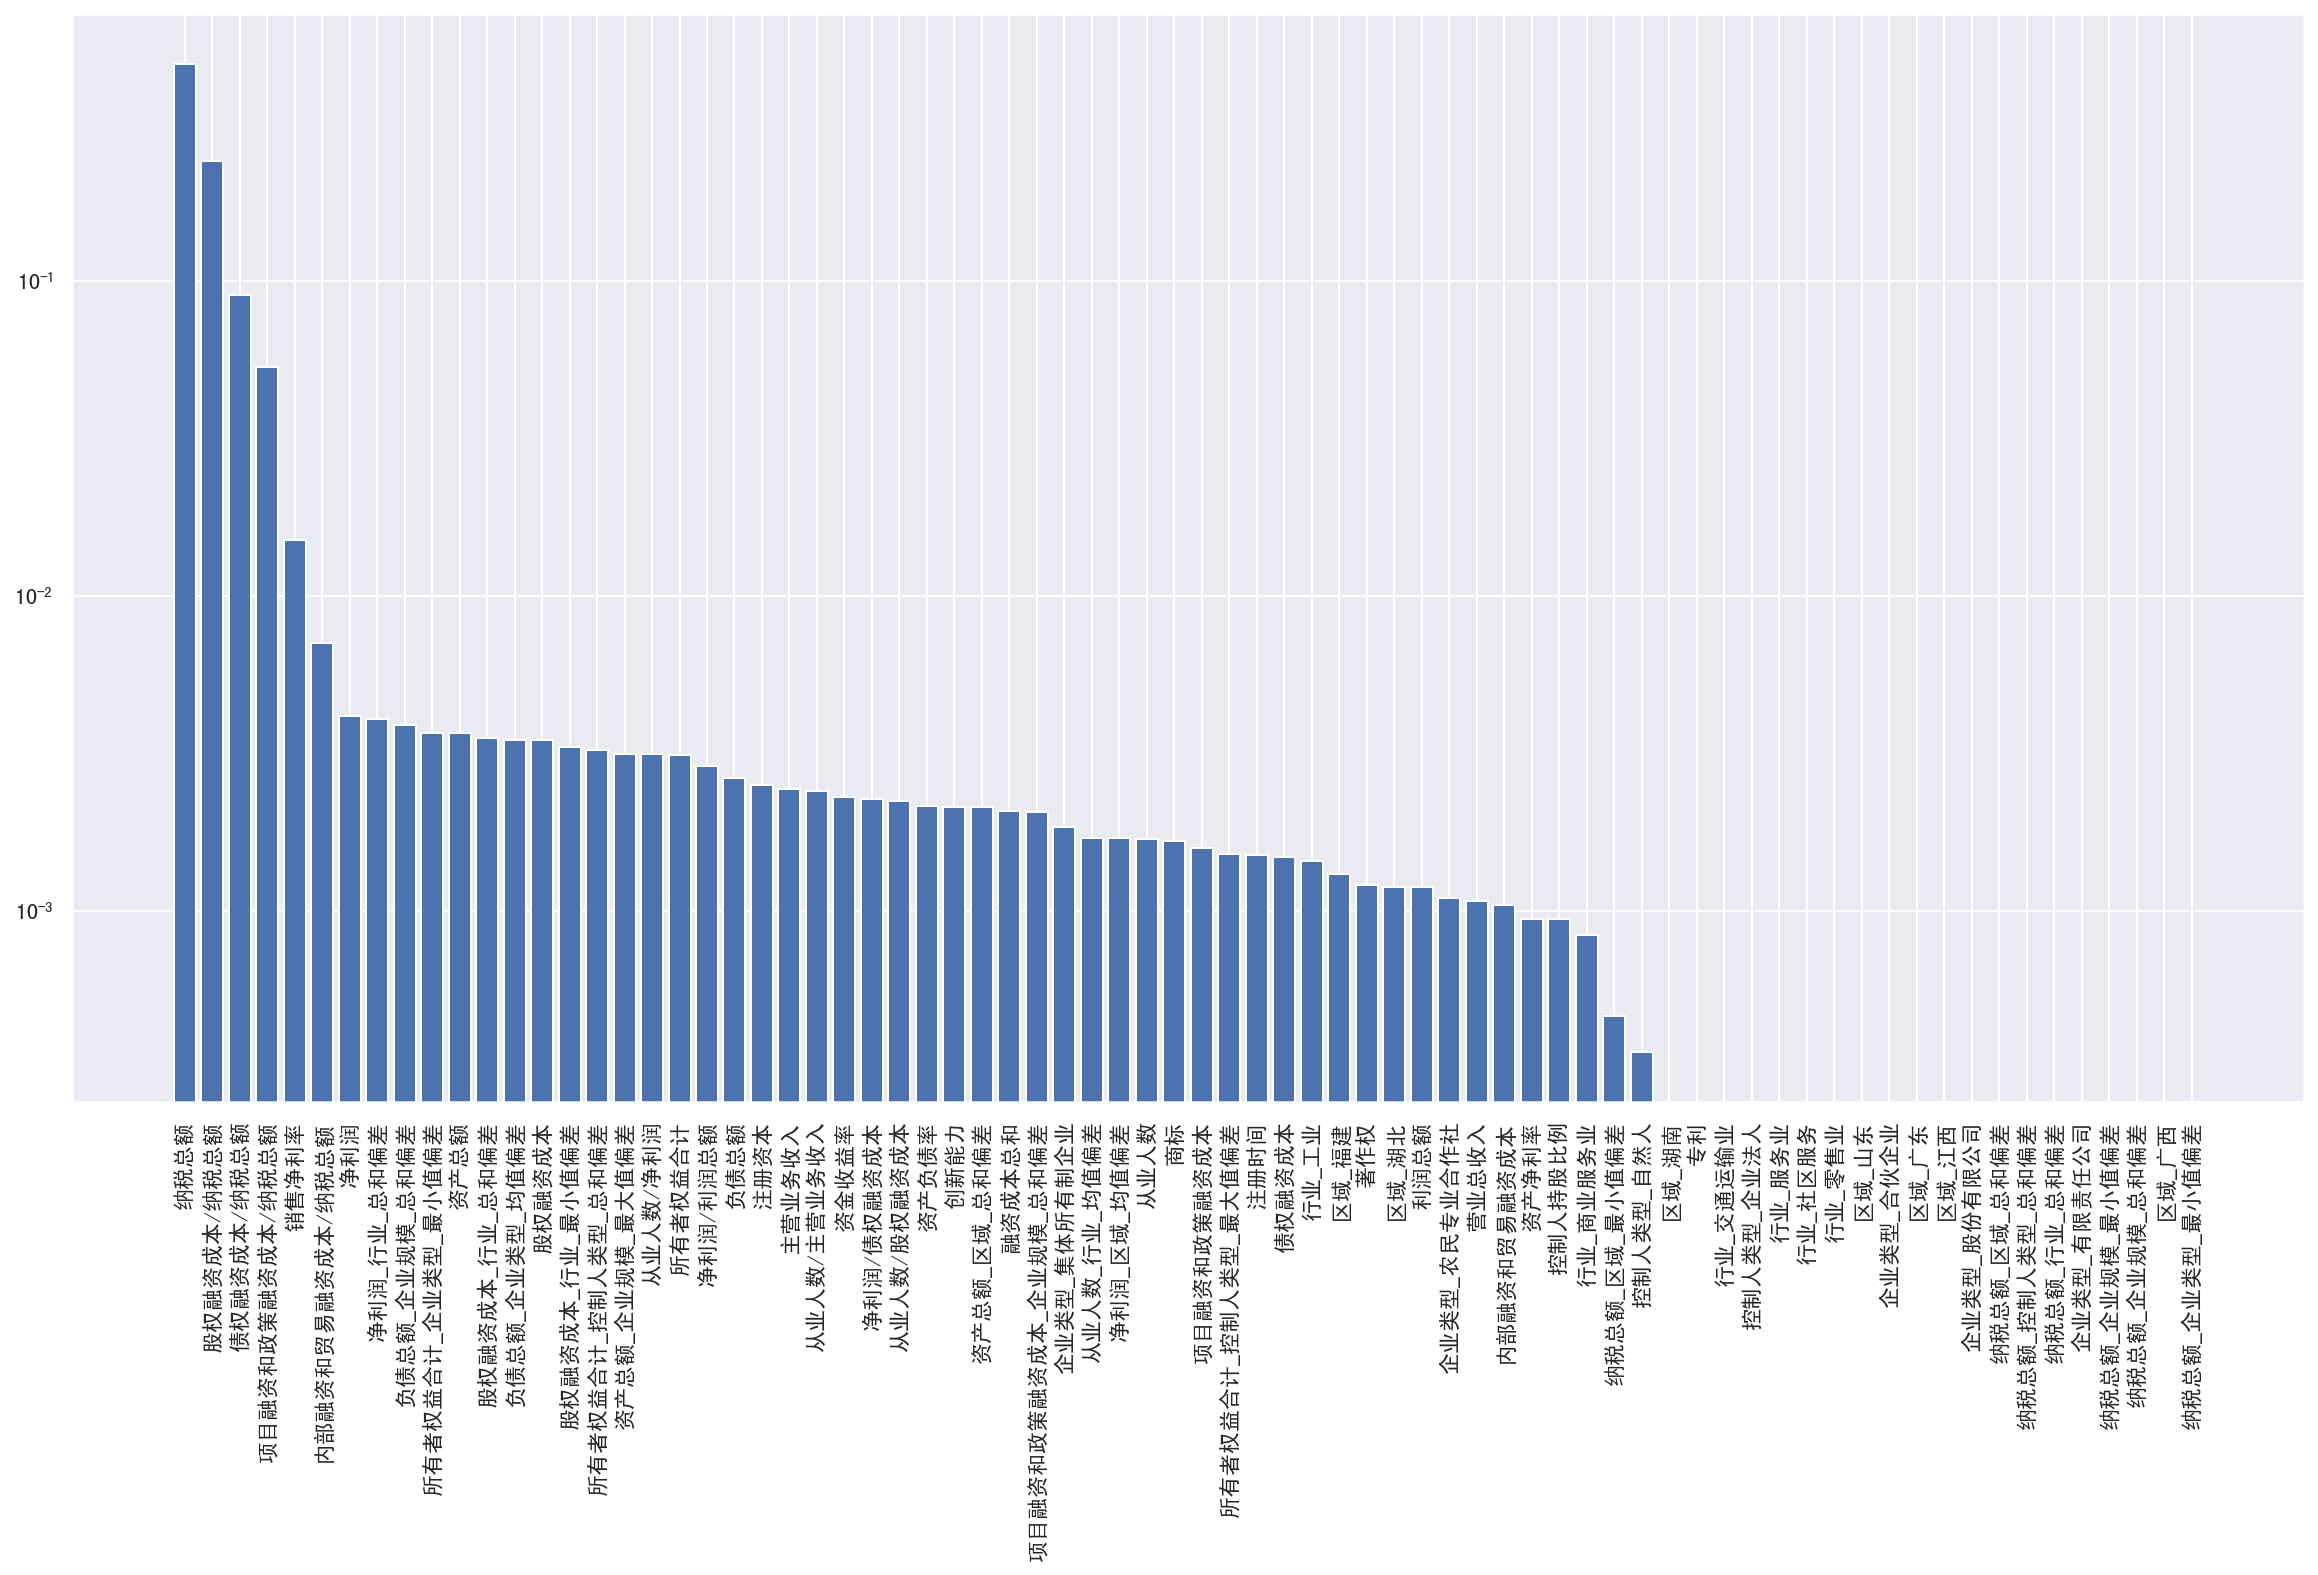

In [832]:
plot_feature_importance(all_clf, all_feature.columns)

In [835]:
all_clf_lgb = LGBMClassifier(bagging_fraction=0.6, feature_fraction=0.9, max_depth=15, min_child_sample=400, n_estimators=100, num_leaves=35)
all_clf_lgb.fit(X_train_all.values, y_train_all)

LGBMClassifier(bagging_fraction=0.6, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_sample=400, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=35, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [836]:
pred_y_train_all_lgb = all_clf_lgb.predict(X_train_all)
pred_y_val_all_lgb = all_clf_lgb.predict(X_val_all)

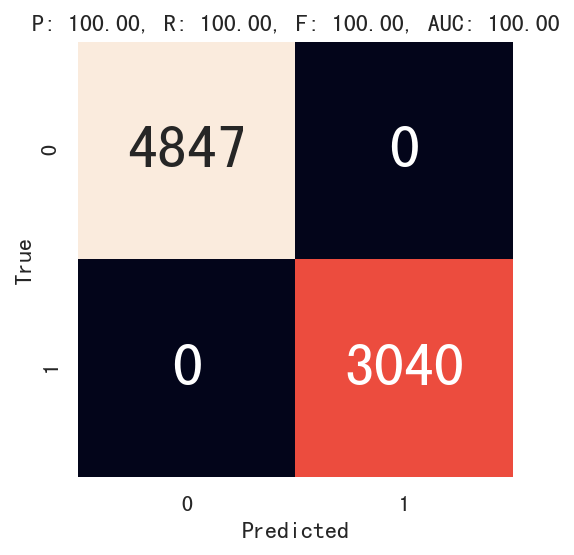

In [837]:
plot_metrics(y_train_all, pred_y_train_all_lgb)

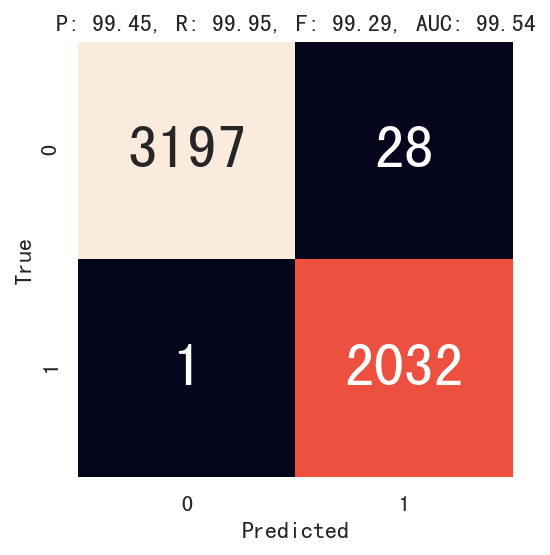

In [838]:
plot_metrics(y_val_all, pred_y_val_all_lgb)

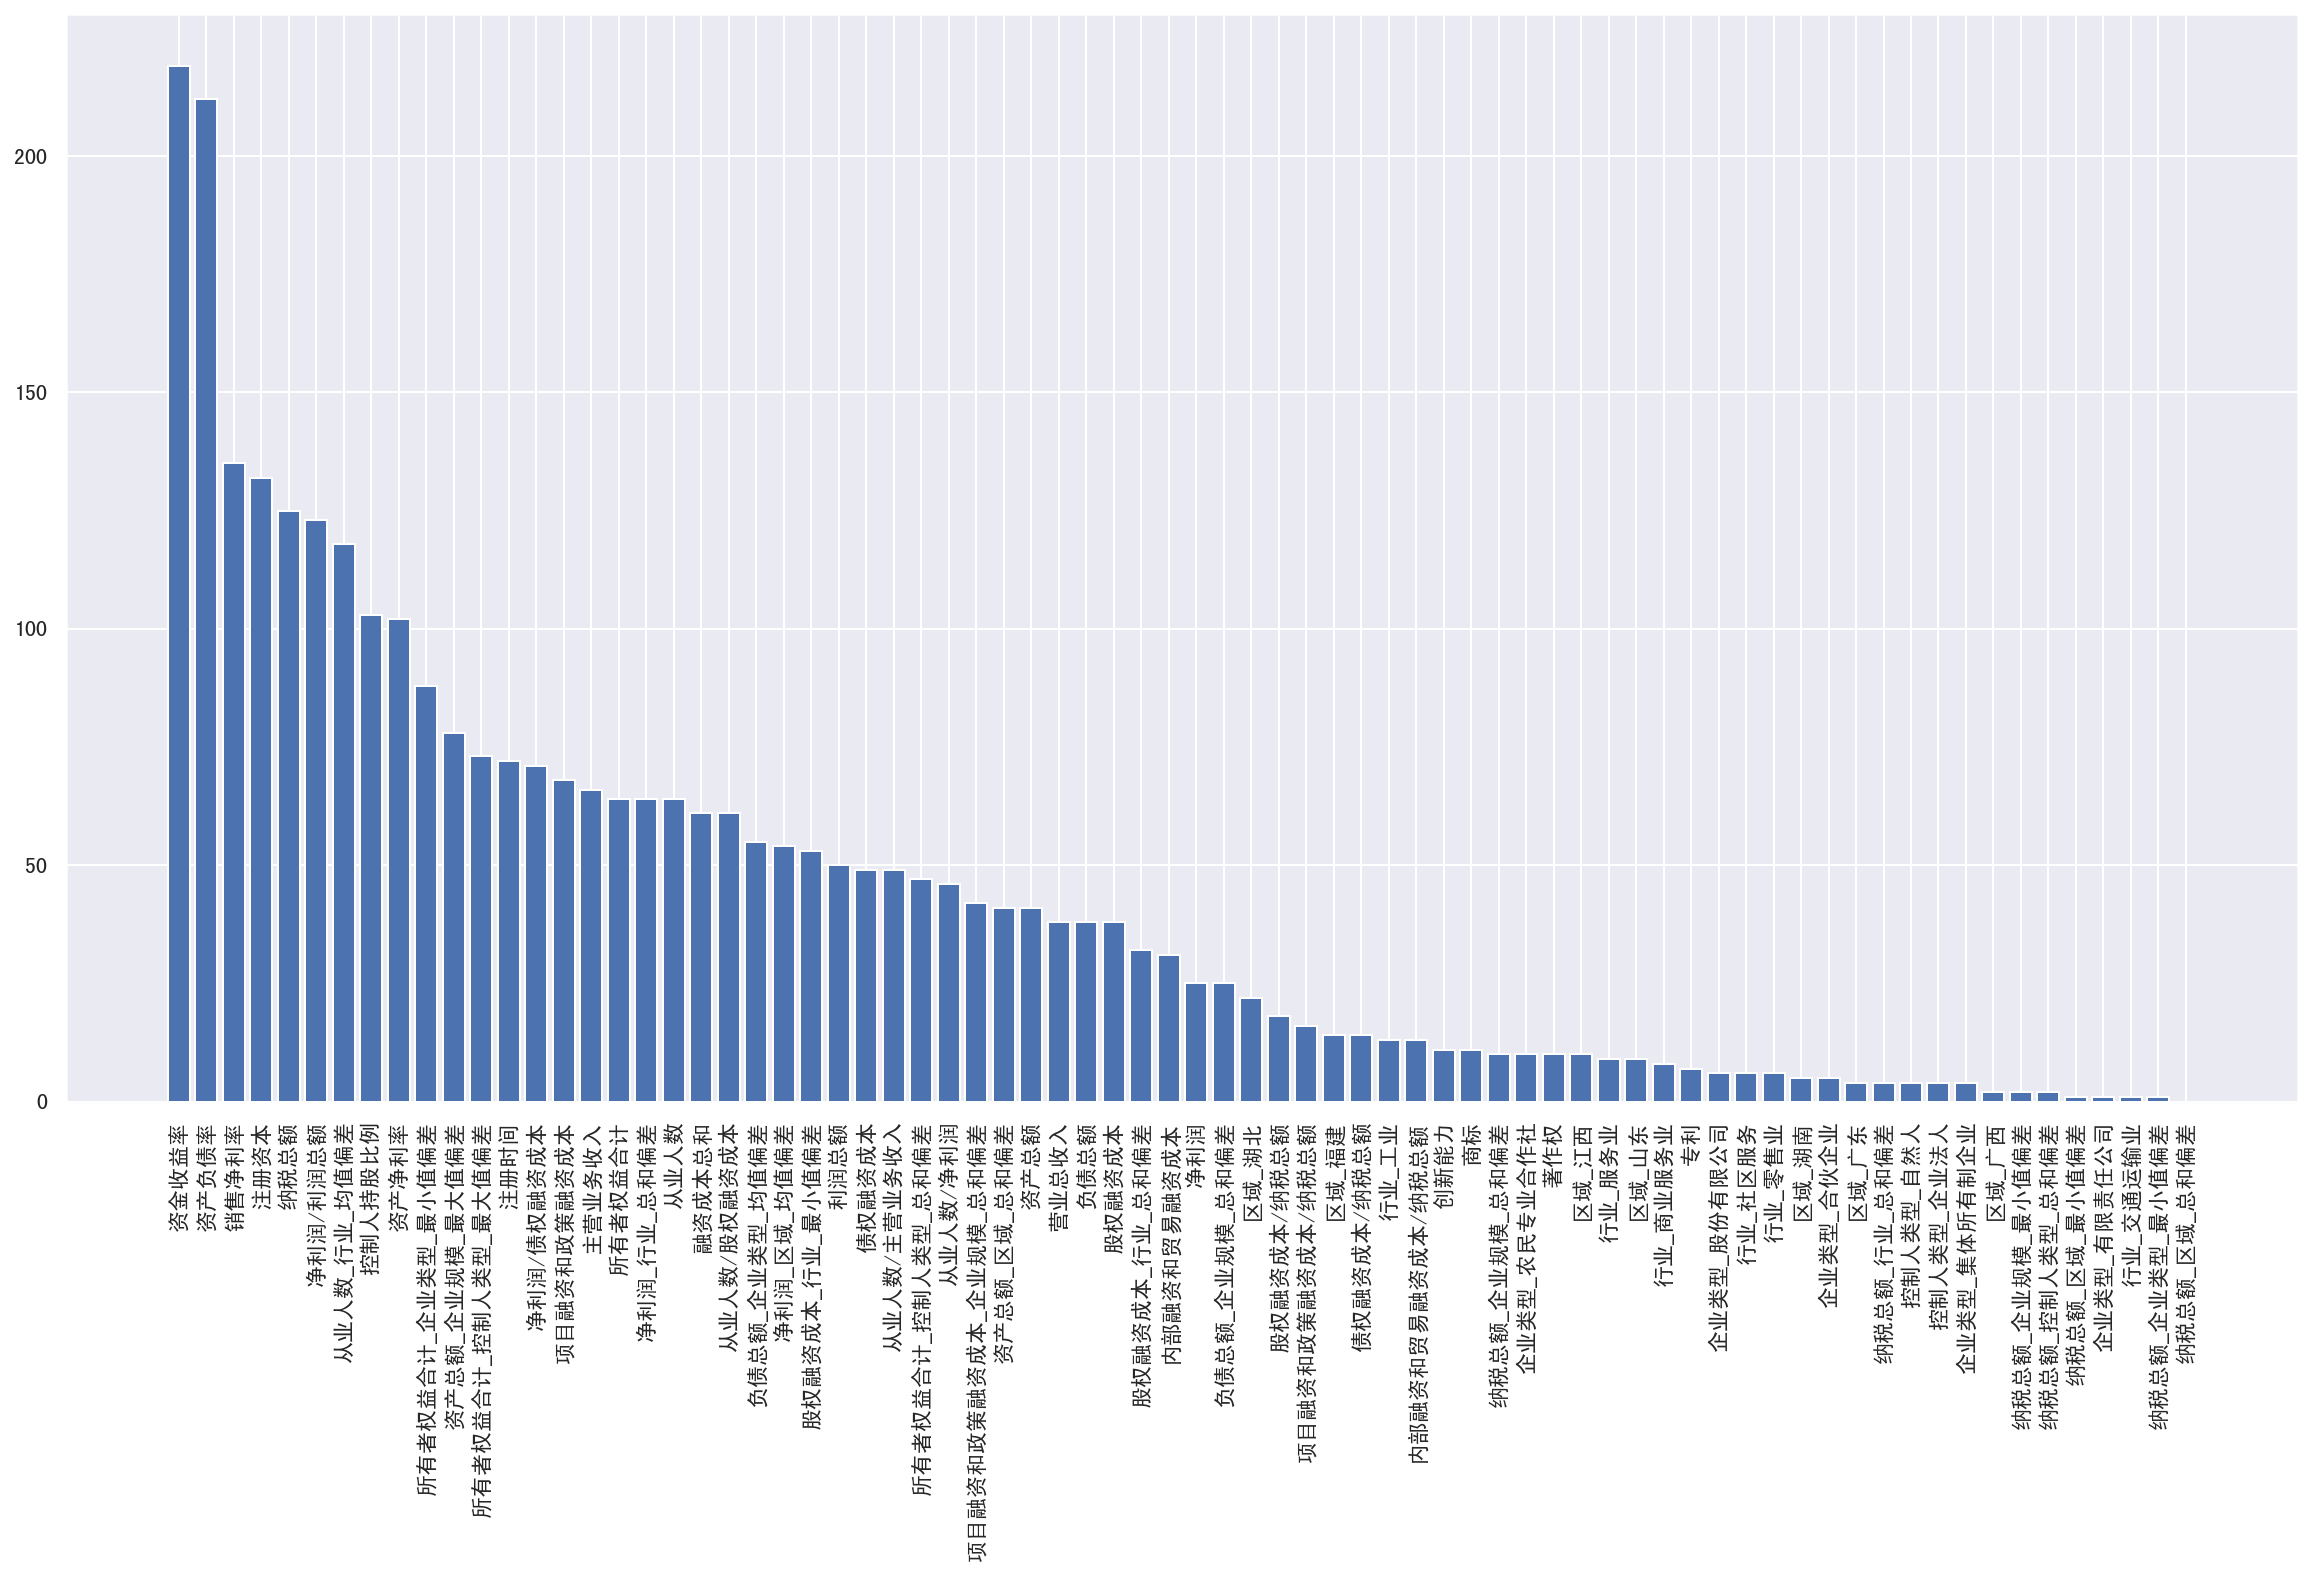

In [842]:
plot_feature_importance(all_clf_lgb, all_feature.columns, yscale="linear")

### 特征选择

In [862]:
select_feature = pd.concat([base_df["注册资本"], year_pre], axis=1, join_axes=[base_df.index])
select_feature = select_feature.loc[sel]
select_feature

,注册资本,从业人数,资产总额,负债总额,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计,销售净利率,资产净利率,资产负债率,资金收益率
ID,,,,,,,,,,,,,,
28,2050.0,527.666667,57400.000000,86783.333333,1.970733e+05,101871.333333,65955.333333,-19707.333333,0.000000,-29383.333333,-0.100000,-0.343333,1.511905,0.670698
230,3360.0,480.666667,76160.000000,94080.000000,1.004640e+05,65822.400000,39838.400000,-10046.400000,0.000000,-17920.000000,-0.100000,-0.131912,1.235294,0.560625
429,9670.0,448.666667,357790.000000,435150.000000,1.051774e+06,603279.066667,264909.650000,-105177.366667,0.000000,-77360.000000,-0.100000,-0.293964,1.216216,1.359583
693,8360.0,553.333333,91960.000000,79420.000000,3.867893e+05,160846.400000,131307.733333,-38678.933333,0.000000,12540.000000,-0.100000,-0.420606,0.863636,-3.084444
727,8720.0,610.333333,398213.333333,584240.000000,1.132728e+06,509509.600000,237271.200000,-113272.800000,0.000000,-186026.666667,-0.100000,-0.284453,1.467153,0.608906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978029,460.0,635.000000,1840.000000,2453.333333,6.608667e+03,3289.000000,1582.400000,2010.200000,1818.533333,-613.333333,0.304176,1.092500,1.333333,-3.277500
5978030,1140.0,914.000000,33060.000000,36290.000000,1.039300e+05,82266.200000,30358.200000,-4533.400000,3397.200000,-3230.000000,-0.043620,-0.137126,1.097701,1.403529
5978031,3290.0,571.000000,103086.666667,148598.333333,2.226233e+05,110544.000000,46345.133333,23117.733333,58912.933333,-45511.666667,0.103842,0.224255,1.441489,-0.507952


In [863]:
X_train_sel, X_val_sel, y_train_sel, y_val_sel = train_test_split(select_feature, train_label, test_size=0.4, random_state=17)

In [931]:
sel_clf = XGBClassifier()
sel_clf.fit(X_train_sel, y_train_sel)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [932]:
pred_y_train_sel = sel_clf.predict(X_train_sel)
pred_y_val_sel = sel_clf.predict(X_val_sel)

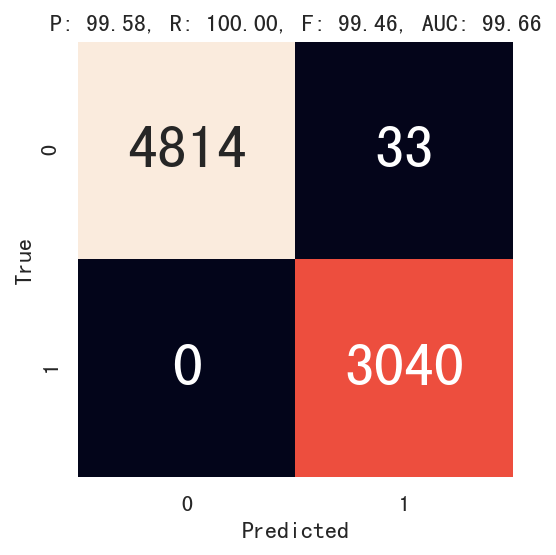

In [933]:
plot_metrics(y_train_sel, pred_y_train_sel)

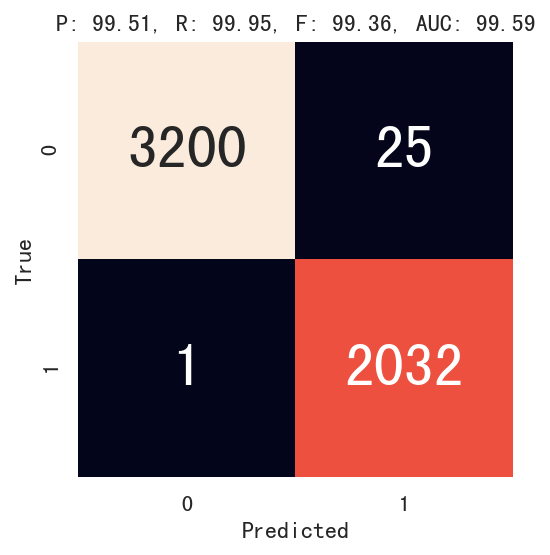

In [934]:
plot_metrics(y_val_sel, pred_y_val_sel)

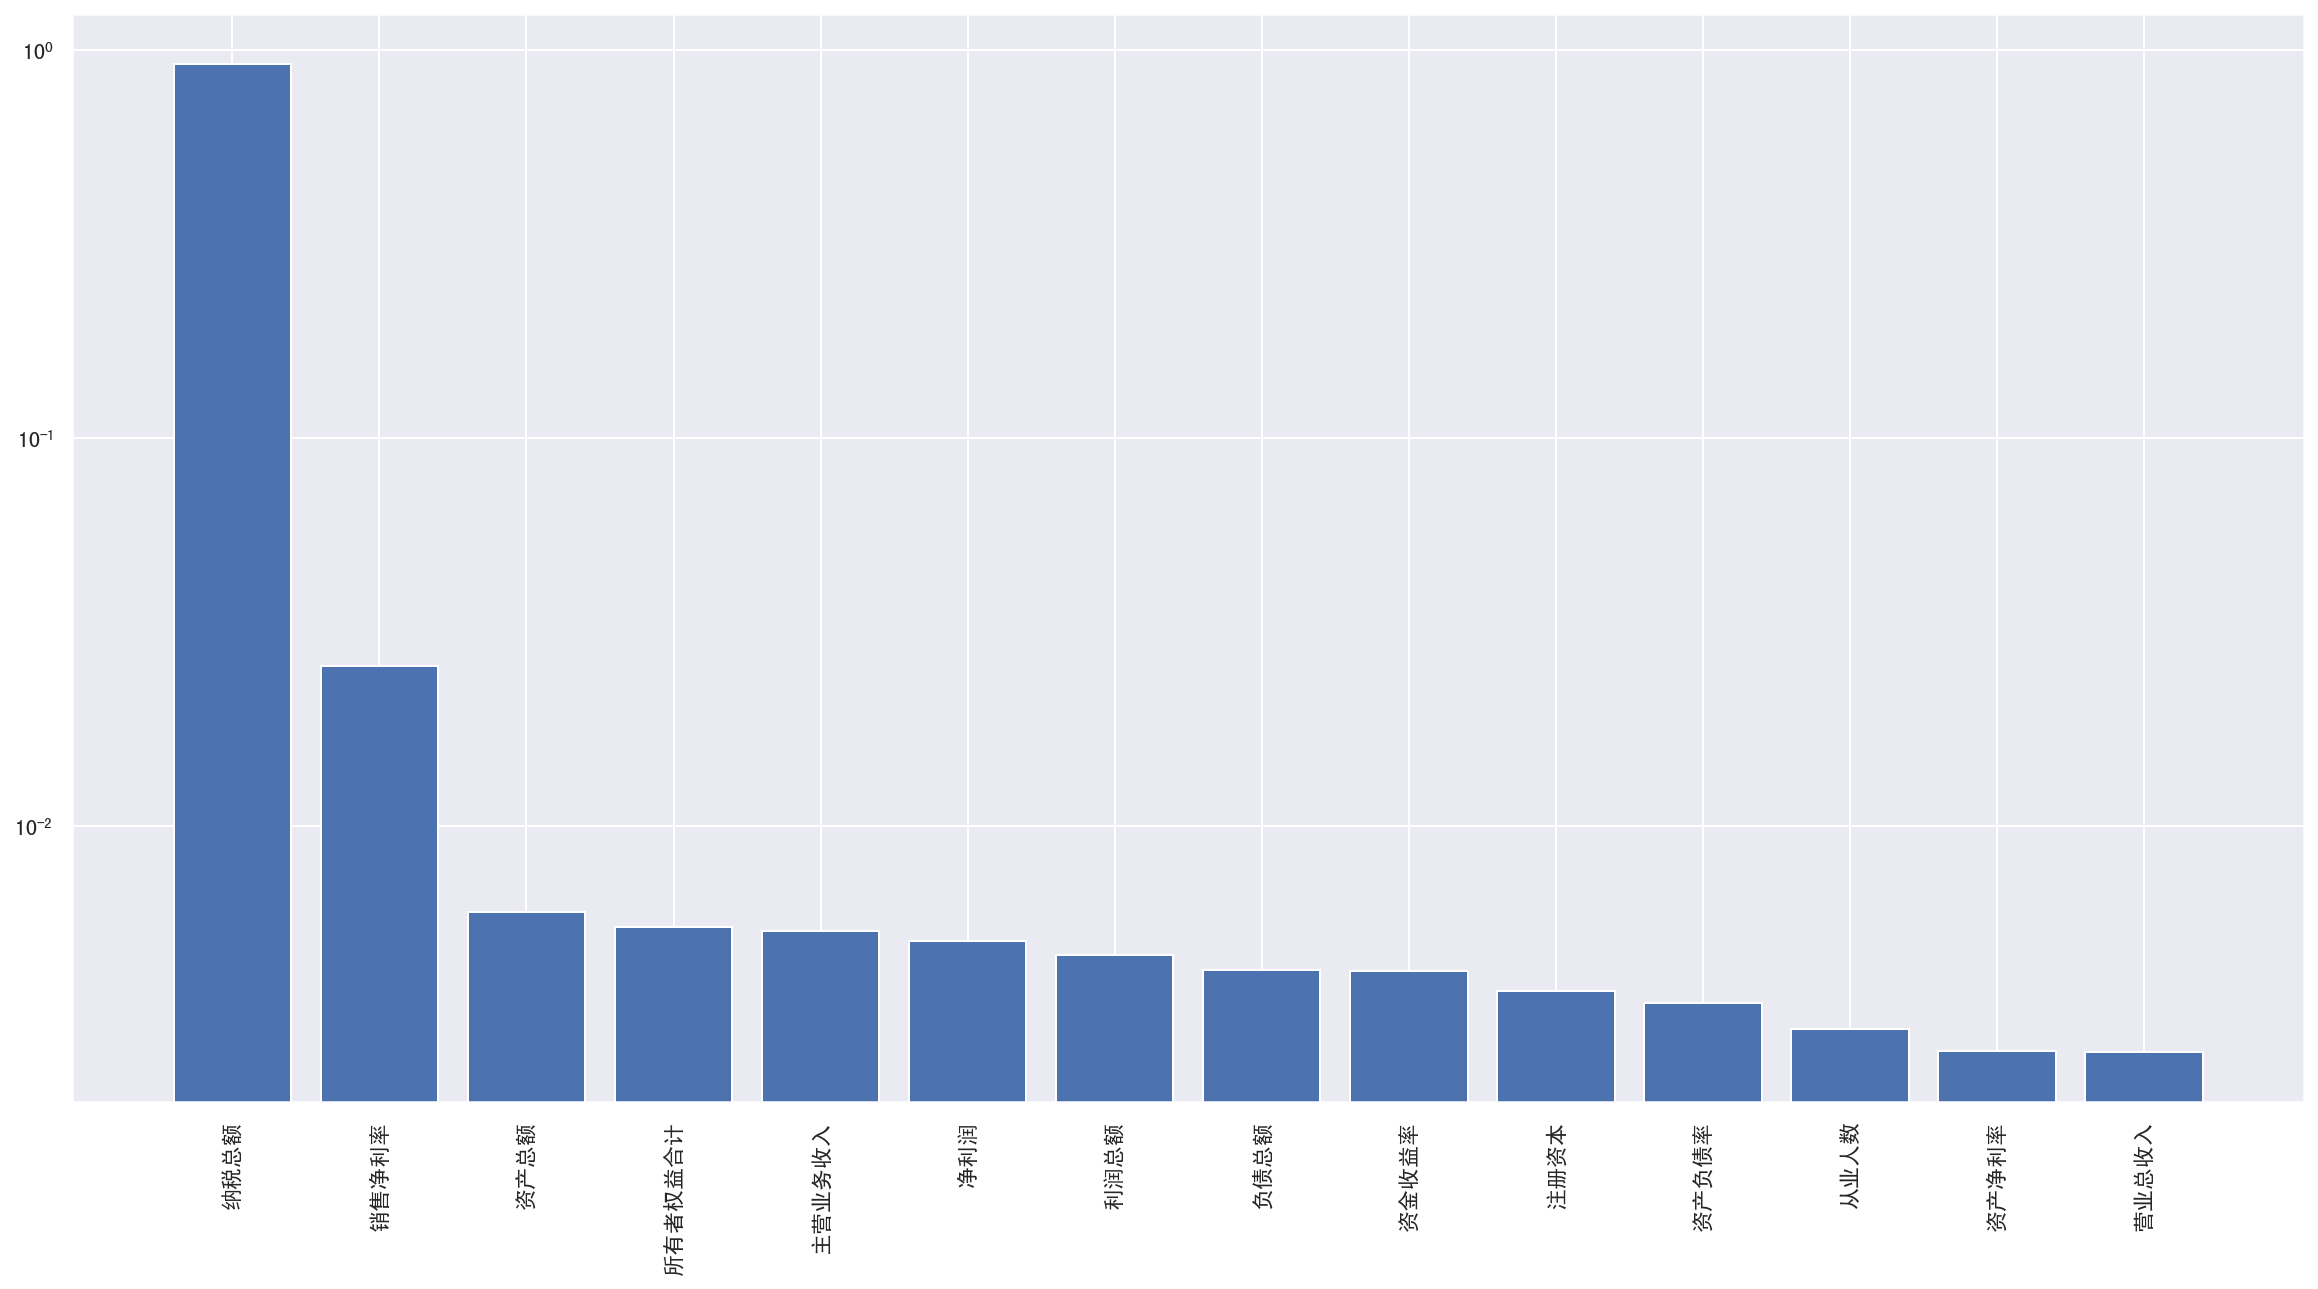

In [935]:
plot_feature_importance(sel_clf, columns=select_feature.columns)

In [892]:
sel_clf_lgb = LGBMClassifier()
sel_clf_lgb.fit(X_train_sel.values, y_train_sel)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [893]:
pred_y_train_sel_lgb = sel_clf_lgb.predict(X_train_sel)
pred_y_val_sel_lgb = sel_clf_lgb.predict(X_val_sel)

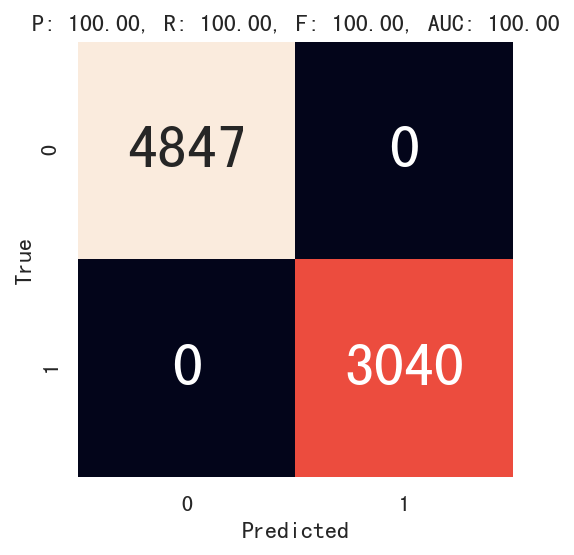

In [894]:
plot_metrics(y_train_sel, pred_y_train_sel_lgb)

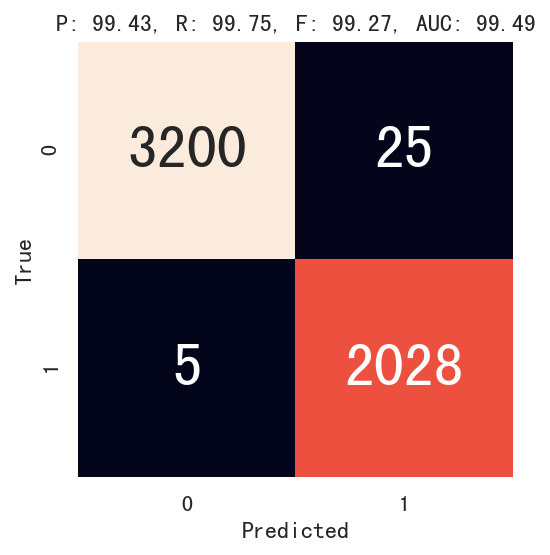

In [895]:
plot_metrics(y_val_sel, pred_y_val_sel_lgb)

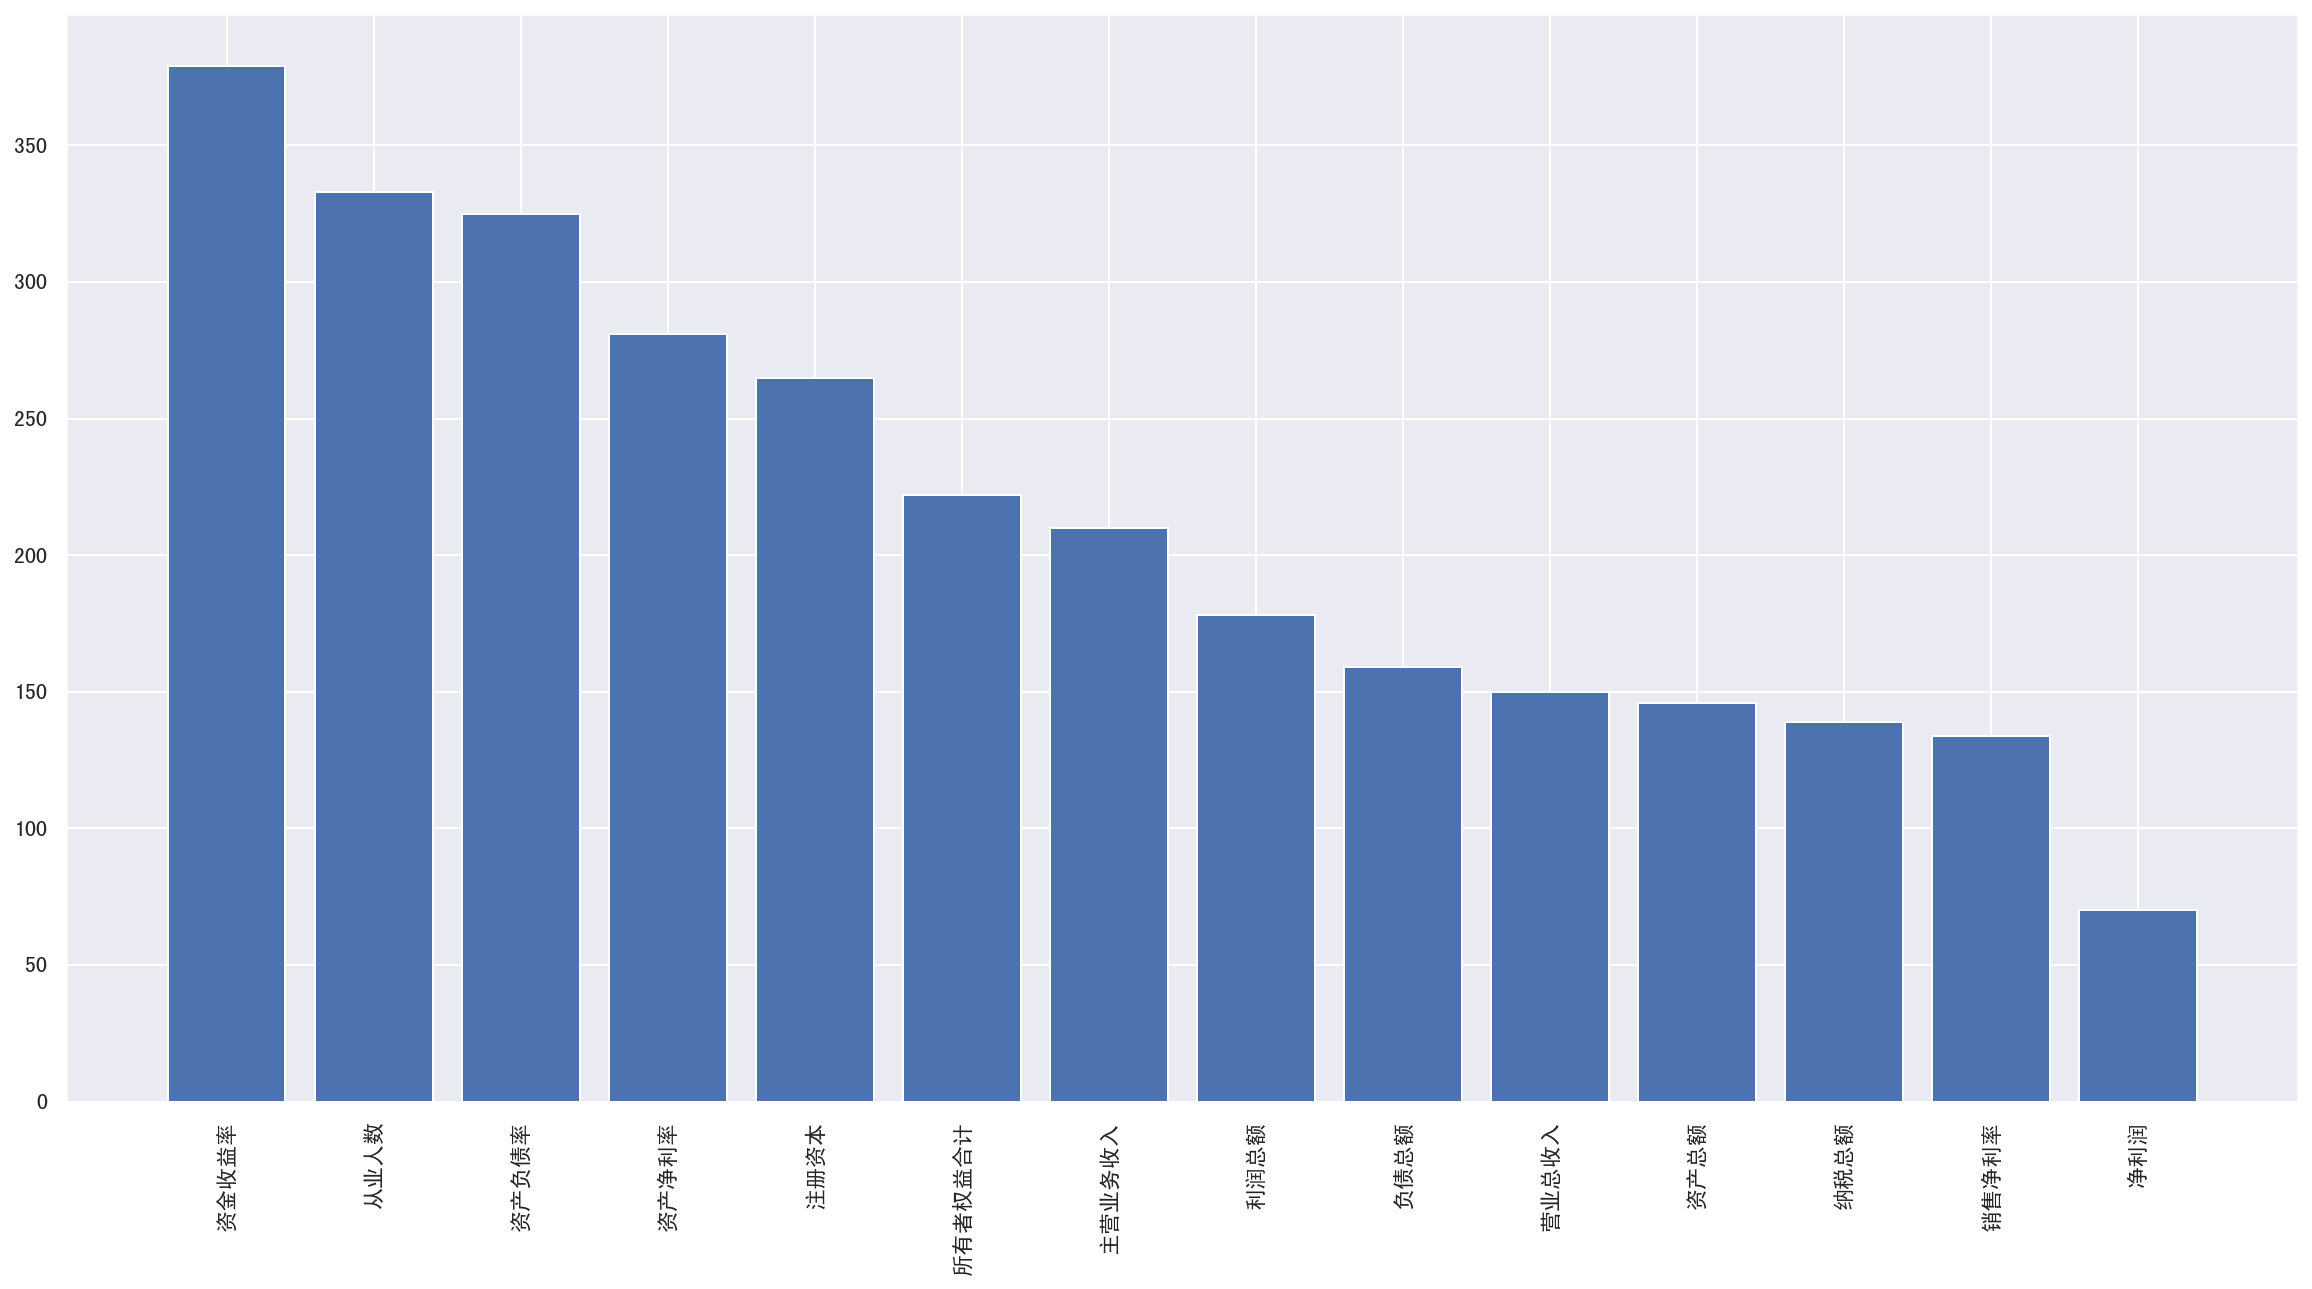

In [897]:
plot_feature_importance(sel_clf_lgb, columns=select_feature.columns, yscale="linear")

## 验证集评估

In [882]:
base_val = pd.read_csv("../data/base_verify1.csv", dtype=base_dtype)
base_val.set_index('ID', inplace=True)
flag_val = base_val.flag
base_val.drop(columns=["控制人ID", "flag"], inplace=True)
base_val

,注册时间,注册资本,行业,区域,企业类型,控制人类型,控制人持股比例
ID,,,,,,,
1500001,2010.0,6680.0,商业服务业,山东,股份有限公司,自然人,0.89
1500321,2001.0,9330.0,商业服务业,广东,股份有限公司,企业法人,0.72
1500395,2003.0,8670.0,交通运输业,广西,农民专业合作社,企业法人,0.60
1500614,2001.0,7730.0,工业,江西,集体所有制企业,企业法人,0.58
1501057,2002.0,6840.0,工业,福建,农民专业合作社,自然人,0.84
...,...,...,...,...,...,...,...
5999996,2011.0,2170.0,零售业,湖北,农民专业合作社,自然人,0.93
5999997,2013.0,9030.0,交通运输业,福建,集体所有制企业,企业法人,0.73
5999998,2014.0,4510.0,服务业,湖南,股份有限公司,自然人,0.64


In [631]:
knowledge_val = pd.read_csv("../data/paient_information_verify1.csv", dtype=knowledge_dtype)
knowledge_val.set_index('ID', inplace=True)
knowledge_val

,专利,商标,著作权
ID,,,
1500001.0,0.0,0.0,0.0
1500321.0,0.0,0.0,0.0
1500395.0,1.0,1.0,0.0
1500614.0,0.0,0.0,0.0
1501057.0,0.0,1.0,1.0
...,...,...,...
5999996.0,1.0,1.0,0.0
5999997.0,1.0,1.0,0.0
5999998.0,0.0,0.0,0.0


In [633]:
money_val = pd.read_csv("../data/money_information_verify1.csv", dtype=money_dtype)
money_val.set_index('ID', inplace=True)
money_val

,year,债权融资额度,债权融资成本,股权融资额度,股权融资成本,内部融资和贸易融资额度,内部融资和贸易融资成本,项目融资和政策融资额度,项目融资和政策融资成本
ID,,,,,,,,,
1500001,2015.0,0.0,0.00,0.00,0.0000,0.0,0.000,334.0,20.040
1500321,2015.0,0.0,0.00,0.00,0.0000,721022.4,43261.344,0.0,0.000
1500395,2015.0,0.0,0.00,0.00,0.0000,0.0,0.000,8323.2,499.392
1500614,2015.0,0.0,0.00,31167.36,1246.6944,0.0,0.000,0.0,0.000
1501057,2015.0,0.0,0.00,0.00,0.0000,490838.4,29450.304,0.0,0.000
...,...,...,...,...,...,...,...,...,...
5999996,2017.0,0.0,0.00,3958.08,158.3232,0.0,0.000,0.0,0.000
5999997,2017.0,14448.0,1155.84,0.00,0.0000,0.0,0.000,0.0,0.000
5999998,2017.0,0.0,0.00,0.00,0.0000,18265.5,1095.930,0.0,0.000


In [634]:
year_val = pd.read_csv("../data/year_report_verify1.csv", dtype=year_dtype)
year_val.set_index('ID', inplace=True)
year_val

,year,从业人数,资产总额,负债总额,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计
ID,,,,,,,,,,
1500001,2015.0,939.0,33400.0,13360.0,150300.0,120240.0,30060.0,-15030.0,0.0,20040.0
1500321,2015.0,228.0,522480.0,256575.0,2403408.0,961363.2,240340.8,NaN,0.0,265905.0
1500395,2015.0,111.0,416160.0,814980.0,957168.0,478584.0,287150.4,-95716.8,0.0,-398820.0
1500614,2015.0,543.0,108220.0,100490.0,519456.0,415564.8,155836.8,-51945.6,0.0,7730.0
1501057,2015.0,733.0,355680.0,697680.0,1636128.0,654451.2,327225.6,-163612.8,0.0,-342000.0
...,...,...,...,...,...,...,...,...,...,...
5999996,2017.0,803.0,13020.0,5425.0,49476.0,19790.4,19790.4,19790.4,19790.4,7595.0
5999997,2017.0,76.0,144480.0,203175.0,390096.0,234057.6,39009.6,0.0,156038.4,-58695.0
5999998,2017.0,841.0,67650.0,63140.0,60885.0,30442.5,30442.5,-6088.5,0.0,4510.0


In [641]:
base_val_pre = pd.get_dummies(base_val, columns=["行业", "区域", "企业类型", "控制人类型"])
base_val_pre

,注册时间,注册资本,控制人持股比例,行业_交通运输业,行业_商业服务业,行业_工业,行业_服务业,行业_社区服务,行业_零售业,区域_山东,...,区域_湖北,区域_湖南,区域_福建,企业类型_农民专业合作社,企业类型_合伙企业,企业类型_有限责任公司,企业类型_股份有限公司,企业类型_集体所有制企业,控制人类型_企业法人,控制人类型_自然人
ID,,,,,,,,,,,,,,,,,,,,,
1500001,2010.0,6680.0,0.89,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1500321,2001.0,9330.0,0.72,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1500395,2003.0,8670.0,0.60,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1500614,2001.0,7730.0,0.58,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1501057,2002.0,6840.0,0.84,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5999996,2011.0,2170.0,0.93,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
5999997,2013.0,9030.0,0.73,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
5999998,2014.0,4510.0,0.64,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [642]:
knowledge_val_pre = knowledge_val.copy()
knowledge_val_pre["创新能力"] = knowledge_val_pre.sum(axis=1)

In [643]:
money_val_pre = money_val.drop(columns=["year", "债权融资额度", "股权融资额度", "内部融资和贸易融资额度", "项目融资和政策融资额度"])
money_val_pre = money_val_pre.groupby("ID").mean()
money_val_pre["融资成本总和"] = money_val_pre.sum(axis=1)
money_val_pre

,债权融资成本,股权融资成本,内部融资和贸易融资成本,项目融资和政策融资成本,融资成本总和
ID,,,,,
1500001,0.000000,0.000000,3507.000,6.680,3513.680000
1500321,0.000000,0.000000,22302.432,139.950,22442.382000
1500395,300.560000,0.000000,1675.044,166.464,2142.068000
1500614,0.000000,415.564800,1391.400,123.680,1930.644800
1501057,0.000000,939.907200,9816.768,0.000,10756.675200
...,...,...,...,...,...
5999995,2187.333333,391.146667,0.000,57.900,2636.380000
5999996,86.800000,78.698667,0.000,0.000,165.498667
5999997,385.280000,0.000000,4773.258,0.000,5158.538000


In [644]:
year_val_pre = year_val.drop(columns="year").groupby("ID").mean()
year_val_pre["销售净利率"] = year_val_pre.apply(f1, axis=1)
year_val_pre["资产净利率"] = year_val_pre.apply(f2, axis=1)
year_val_pre["资产负债率"] = year_val_pre.apply(f3, axis=1)
year_val_pre["资金收益率"] = year_val_pre.apply(f4, axis=1)
year_val_pre

,从业人数,资产总额,负债总额,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计,销售净利率,资产净利率,资产负债率,资金收益率
ID,,,,,,,,,,,,,
1500001,886.666667,155866.666667,188153.333333,2.449333e+05,177242.666667,98084.666667,-24493.333333,0.000000,-32286.666667,-0.100000,-0.157143,1.207143,0.758621
1500321,428.666667,320330.000000,300115.000000,1.416294e+06,671822.200000,229207.000000,-92273.700000,0.000000,20215.000000,-0.065152,-0.288058,0.936893,-4.564615
1500395,555.666667,216750.000000,433500.000000,5.473660e+05,287208.200000,169296.200000,-54736.600000,0.000000,-91035.000000,-0.100000,-0.252533,2.000000,0.601270
1500614,423.000000,115950.000000,106931.666667,3.205373e+05,211492.800000,89874.133333,-32053.733333,0.000000,9018.333333,-0.100000,-0.276444,0.922222,-3.554286
1501057,588.000000,216600.000000,340860.000000,8.365320e+05,393870.000000,226563.600000,-83653.200000,0.000000,-124260.000000,-0.100000,-0.386211,1.573684,0.673211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5999995,500.333333,373133.333333,250900.000000,6.349700e+05,406972.666667,293842.500000,43199.833333,286412.000000,122233.333333,0.068034,0.115776,0.672414,0.353421
5999996,703.666667,18083.333333,19168.333333,3.761333e+04,23493.866667,13743.333333,9519.066667,17649.333333,-1085.000000,0.253077,0.526400,1.060000,-8.773333
5999997,264.666667,105350.000000,106855.000000,3.952130e+05,223853.700000,145593.700000,79584.400000,211121.400000,-1505.000000,0.201371,0.755429,1.014286,-52.880000


In [884]:
union_feature_val = pd.concat([base_val_pre, knowledge_val_pre, money_val_pre, year_val_pre], axis=1, join_axes=[base_val_pre.index])
union_feature_val

,注册时间,注册资本,控制人持股比例,行业_交通运输业,行业_商业服务业,行业_工业,行业_服务业,行业_社区服务,行业_零售业,区域_山东,...,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计,销售净利率,资产净利率,资产负债率,资金收益率
ID,,,,,,,,,,,,,,,,,,,,,
1500001,2010.0,6680.0,0.89,0,1,0,0,0,0,1,...,2.449333e+05,177242.666667,98084.666667,-24493.333333,0.000000,-32286.666667,-0.100000,-0.157143,1.207143,0.758621
1500321,2001.0,9330.0,0.72,0,1,0,0,0,0,0,...,1.416294e+06,671822.200000,229207.000000,-92273.700000,0.000000,20215.000000,-0.065152,-0.288058,0.936893,-4.564615
1500395,2003.0,8670.0,0.60,1,0,0,0,0,0,0,...,5.473660e+05,287208.200000,169296.200000,-54736.600000,0.000000,-91035.000000,-0.100000,-0.252533,2.000000,0.601270
1500614,2001.0,7730.0,0.58,0,0,1,0,0,0,0,...,3.205373e+05,211492.800000,89874.133333,-32053.733333,0.000000,9018.333333,-0.100000,-0.276444,0.922222,-3.554286
1501057,2002.0,6840.0,0.84,0,0,1,0,0,0,0,...,8.365320e+05,393870.000000,226563.600000,-83653.200000,0.000000,-124260.000000,-0.100000,-0.386211,1.573684,0.673211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5999996,2011.0,2170.0,0.93,0,0,0,0,0,1,0,...,3.761333e+04,23493.866667,13743.333333,9519.066667,17649.333333,-1085.000000,0.253077,0.526400,1.060000,-8.773333
5999997,2013.0,9030.0,0.73,1,0,0,0,0,0,0,...,3.952130e+05,223853.700000,145593.700000,79584.400000,211121.400000,-1505.000000,0.201371,0.755429,1.014286,-52.880000
5999998,2014.0,4510.0,0.64,0,0,0,1,0,0,0,...,6.975467e+04,35147.933333,25120.700000,7862.433333,10433.133333,8268.333333,0.112716,0.186786,0.803571,0.950909


In [885]:
na_id = flag_val[flag_val.isna()].index
union_feature_val.drop(index=na_id, inplace=True)
flag_val.drop(index=na_id, inplace=True)
label_val = flag_val.to_numpy(dtype=int)
label_val[label_val == 0] = -1

In [701]:
%%timeit -n10
pred_label_val = clf.predict(union_feature_val)

88.5 ms ± 7.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


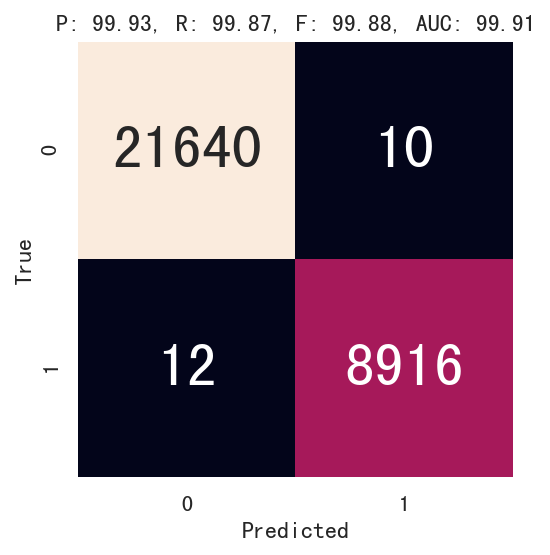

In [731]:
plot_metrics(label_val, pred_label_val)

In [703]:
%%timeit -n10
pred_label_val12 = gs_clf12.predict(union_feature_val)

374 ms ± 49.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


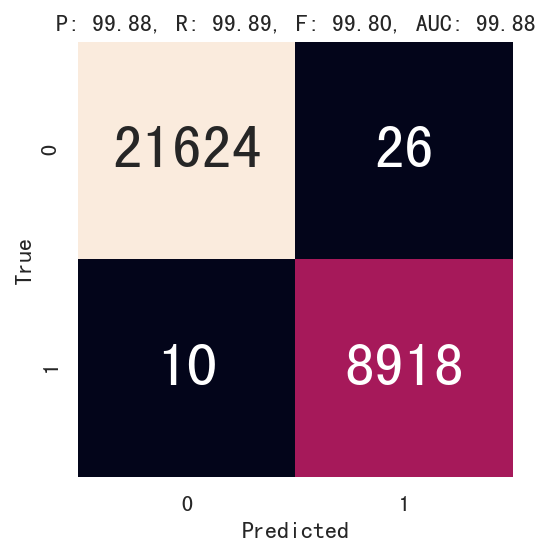

In [732]:
plot_metrics(label_val, pred_label_val12)

In [705]:
%%timeit -n10
pred_label_val_lgb = lgb_clf.predict(union_feature_val.values)

187 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


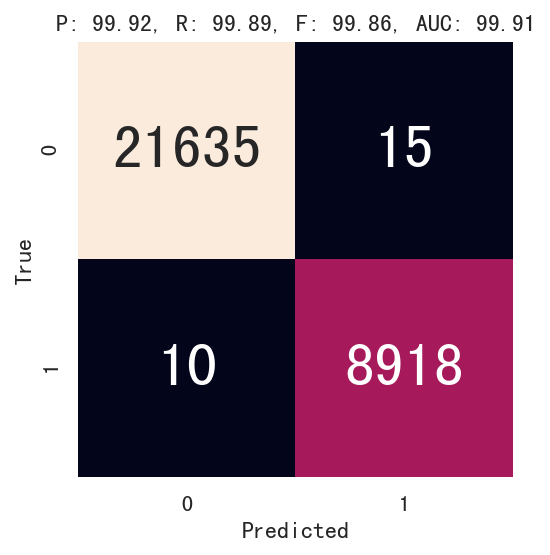

In [733]:
plot_metrics(label_val, pred_label_val_lgb)

In [707]:
%%timeit -n10
pred_label_val19 = gs_clf19.predict(union_feature_val.values)

227 ms ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


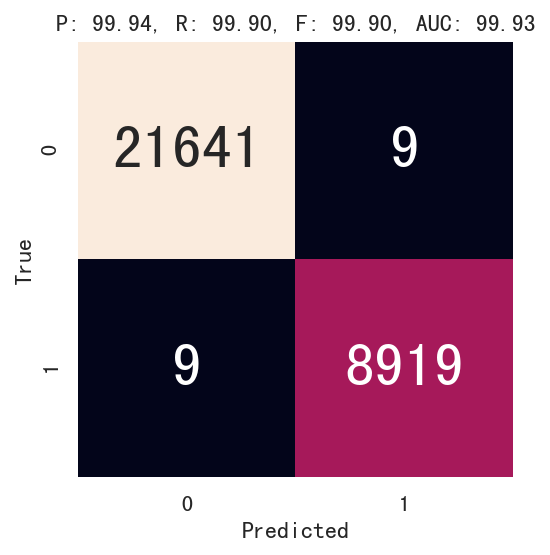

In [734]:
plot_metrics(label_val, pred_label_val19)

In [678]:
_ = union_feature_val.copy()
_["ID"] = _.index

In [681]:
_

,注册时间,注册资本,控制人持股比例,行业_交通运输业,行业_商业服务业,行业_工业,行业_服务业,行业_社区服务,行业_零售业,区域_山东,...,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计,销售净利率,资产净利率,资产负债率,资金收益率,ID
ID,,,,,,,,,,,,,,,,,,,,,
1500001,2010.0,6680.0,0.89,0,1,0,0,0,0,1,...,177242.666667,98084.666667,-24493.333333,0.000000,-32286.666667,-0.100000,-0.157143,1.207143,0.758621,1500001
1500321,2001.0,9330.0,0.72,0,1,0,0,0,0,0,...,671822.200000,229207.000000,-92273.700000,0.000000,20215.000000,-0.065152,-0.288058,0.936893,-4.564615,1500321
1500395,2003.0,8670.0,0.60,1,0,0,0,0,0,0,...,287208.200000,169296.200000,-54736.600000,0.000000,-91035.000000,-0.100000,-0.252533,2.000000,0.601270,1500395
1500614,2001.0,7730.0,0.58,0,0,1,0,0,0,0,...,211492.800000,89874.133333,-32053.733333,0.000000,9018.333333,-0.100000,-0.276444,0.922222,-3.554286,1500614
1501057,2002.0,6840.0,0.84,0,0,1,0,0,0,0,...,393870.000000,226563.600000,-83653.200000,0.000000,-124260.000000,-0.100000,-0.386211,1.573684,0.673211,1501057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5999996,2011.0,2170.0,0.93,0,0,0,0,0,1,0,...,23493.866667,13743.333333,9519.066667,17649.333333,-1085.000000,0.253077,0.526400,1.060000,-8.773333,5999996
5999997,2013.0,9030.0,0.73,1,0,0,0,0,0,0,...,223853.700000,145593.700000,79584.400000,211121.400000,-1505.000000,0.201371,0.755429,1.014286,-52.880000,5999997
5999998,2014.0,4510.0,0.64,0,0,0,1,0,0,0,...,35147.933333,25120.700000,7862.433333,10433.133333,8268.333333,0.112716,0.186786,0.803571,0.950909,5999998


In [709]:
%%timeit -n10
pred_label_val_withID = withid_clf.predict(_)

66.2 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


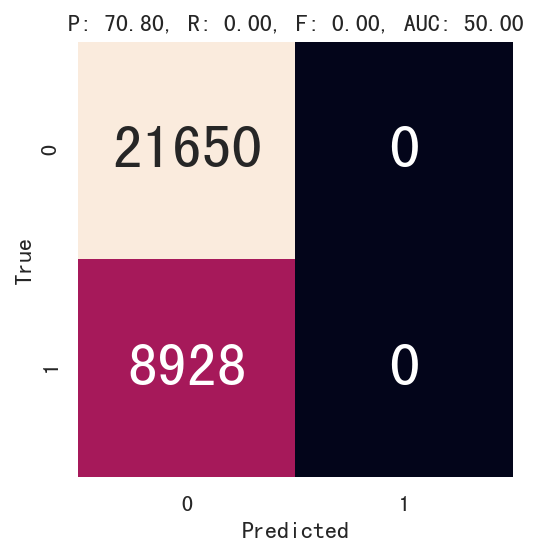

In [735]:
plot_metrics(label_val, pred_label_val_withID)

In [711]:
%%timeit -n10
pred_label_val_ = clf_.predict(union_feature_val)

64.2 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


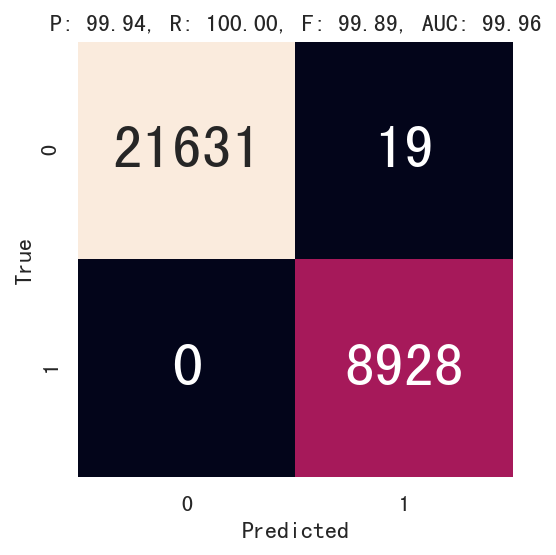

In [736]:
plot_metrics(label_val, pred_label_val_)

In [887]:
select_feature_val = pd.concat([base_val["注册资本"], year_val_pre], axis=1, join_axes=[base_val.index])
select_feature_val.drop(index=na_id, inplace=True)
select_feature_val

,注册资本,从业人数,资产总额,负债总额,营业总收入,主营业务收入,利润总额,净利润,纳税总额,所有者权益合计,销售净利率,资产净利率,资产负债率,资金收益率
ID,,,,,,,,,,,,,,
1500001,6680.0,886.666667,155866.666667,188153.333333,2.449333e+05,177242.666667,98084.666667,-24493.333333,0.000000,-32286.666667,-0.100000,-0.157143,1.207143,0.758621
1500321,9330.0,428.666667,320330.000000,300115.000000,1.416294e+06,671822.200000,229207.000000,-92273.700000,0.000000,20215.000000,-0.065152,-0.288058,0.936893,-4.564615
1500395,8670.0,555.666667,216750.000000,433500.000000,5.473660e+05,287208.200000,169296.200000,-54736.600000,0.000000,-91035.000000,-0.100000,-0.252533,2.000000,0.601270
1500614,7730.0,423.000000,115950.000000,106931.666667,3.205373e+05,211492.800000,89874.133333,-32053.733333,0.000000,9018.333333,-0.100000,-0.276444,0.922222,-3.554286
1501057,6840.0,588.000000,216600.000000,340860.000000,8.365320e+05,393870.000000,226563.600000,-83653.200000,0.000000,-124260.000000,-0.100000,-0.386211,1.573684,0.673211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5999996,2170.0,703.666667,18083.333333,19168.333333,3.761333e+04,23493.866667,13743.333333,9519.066667,17649.333333,-1085.000000,0.253077,0.526400,1.060000,-8.773333
5999997,9030.0,264.666667,105350.000000,106855.000000,3.952130e+05,223853.700000,145593.700000,79584.400000,211121.400000,-1505.000000,0.201371,0.755429,1.014286,-52.880000
5999998,4510.0,723.000000,42093.333333,33825.000000,6.975467e+04,35147.933333,25120.700000,7862.433333,10433.133333,8268.333333,0.112716,0.186786,0.803571,0.950909


In [890]:
%%timeit -n10
pred_label_val_sel = sel_clf.predict(select_feature_val)

50.1 ms ± 8.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


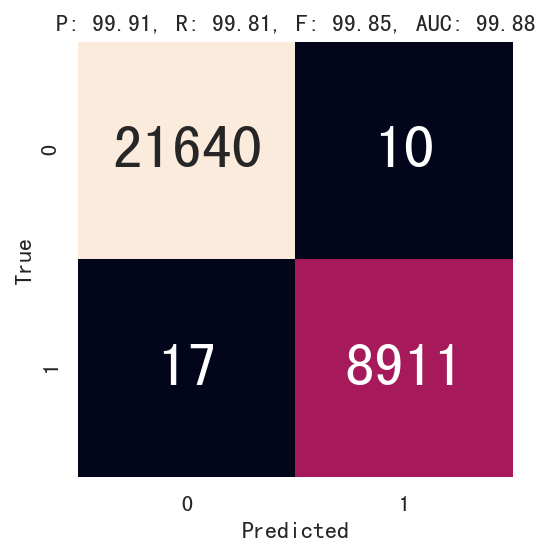

In [889]:
plot_metrics(label_val, pred_label_val_sel)

In [901]:
%%timeit -n10
pred_label_val_sel_lgb = sel_clf_lgb.predict(select_feature_val)

144 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


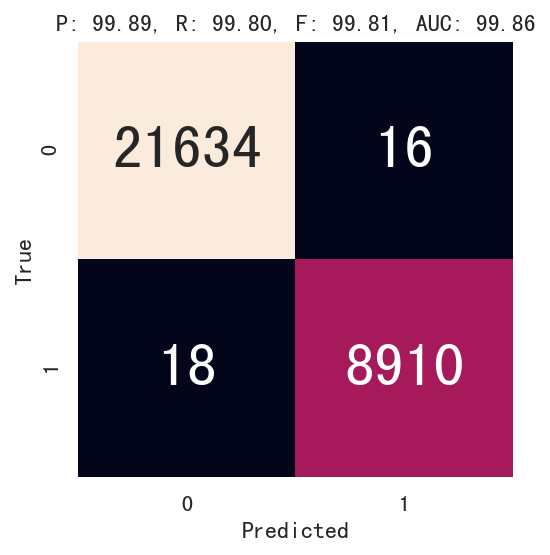

In [906]:
plot_metrics(label_val, pred_label_val_sel_lgb)